Students : Iheb BEN SALEM/ Anis Yassine BEN MABROUK 
Team: IBS/ABM

"Code made and tested on kaggle notebooks"

Execute the next few cells and once you reach the title of first method you are free to jump to any method and excute it independently.

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms_
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import balanced_accuracy_score
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset,TensorDataset
csvfile="/kaggle/input/3md3070-dlmi/trainset/trainset_true.csv"
df_raw=pd.read_csv(csvfile)  
df=df_raw


In [3]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=50)

In [4]:
df

,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,P26,1,M,11/3/1933,11.20
1,P183,1,M,5/15/1942,12.80
2,P89,1,M,6/19/1935,9.60
3,P123,1,M,1/27/1931,122.60
4,P61,1,F,3/5/1931,11.60
...,...,...,...,...,...
158,P135,1,M,27-08-1951,9.45
159,P8,0,M,16-05-1975,4.91
160,P130,0,F,16-05-1943,4.17
161,P70,1,M,05-09-1987,5.66


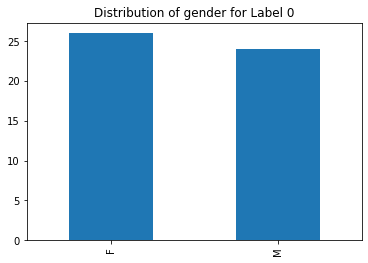

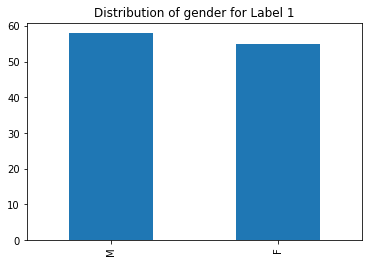

In [5]:
df.iloc[110,2]="F" #fixing a mistake in of the entries.
df[df['LABEL'] == 0]["GENDER"].value_counts().plot(kind='bar',title="Distribution of gender for Label 0")
plt.show()
df[df['LABEL'] == 1]["GENDER"].value_counts().plot(kind='bar',title="Distribution of gender for Label 1")
plt.show()


In [6]:

import random
random.seed(50)
torch.manual_seed(50)
np.random.seed(50)
#Sadly this is not enough to make all algorithms perfectly replicatable. 
#If you run into results relatively different than ours (mostly for ANN),execute the algorithm few more times.

## SVM MIL

We use pretrained resnet50 model to do the embedding of the data.

In [155]:
import torchvision.models as models
pretrained_net = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(pretrained_net.children())[:-1])
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [156]:
import torchvision.transforms as transforms_
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from PIL import Image


class DLMI_data_svm(Dataset):
    def __init__(self, dataframe, root_dir, transforms = None):
        """
        Args:
            dataframe 
            mode(string) = "train","valid","test" 
            root_dir (string): Directory with the images.
            transform (optional): Data augmentation
        """        
        super().__init__()
        self.df = dataframe
        self.image_dir = root_dir
        self.transforms = transforms    
        self.labels_list=list(self.df.iloc[:,1])
    
    def __len__(self):
        return len(self.labels_list)


    def __getitem__(self, index):
        self.bag_list=[]
        name=self.df.iloc[index,0]
        gender=self.df.iloc[index,2]
        DOB=self.df.iloc[index,3]
        DOB=int(DOB[-4:])

        path, dirs, files = next(os.walk(self.image_dir+name))
        i=0

        for file in files:
            image = Image.open(self.image_dir+name+"/"+file)


            if(self.transforms!=None):
                image=self.transforms(image)

            self.bag_list.append(image)
        label = {"name":name,"nb":len(files), "label":self.labels_list[index]*2-1,"gender":gender ,"DOB":DOB,"LYMPH_COUNT":float(self.df.iloc[index,4])}

        return self.bag_list, label


In [157]:


train_data_transforms = torchvision.transforms.Compose([


    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_svm_train=DLMI_data_svm(df_train,"/kaggle/input/3md3070-dlmi/trainset/",train_data_transforms)
dataset_svm_val=DLMI_data_svm(df_val,"/kaggle/input/3md3070-dlmi/trainset/",train_data_transforms)

We add the age and concentration data to the embdding

In [158]:


def extract_features(model,dataset):
    X=[]
    Y=[]
    patient=[]
    for i in range(len(dataset)):
        image_bag, labels = dataset[i]

        features = model(torch.stack(image_bag).to(device))
        features = features.view(features.size(0),-1)
        features = features.cpu().numpy()
        X.append(features)
        Y.append(labels["label"])
        patient.append(labels)
    return X,Y,patient





In [160]:
def process_pca(pca,X_data,P_data):
    res= []
    for i in range(len(X_data)):
        n,f=X_data[i].shape
        new_data=np.zeros((n,pca.n_components_+4))
        new_data[:,:-4]=pca.transform(X_data[i])
        new_data[:,-4]=P_data[i]["DOB"]
        new_data[:,-1]=P_data[i]["LYMPH_COUNT"]
        
        
        res.append(new_data)
    return res

In [161]:
X_train,Y_train,P_train=extract_features(model,dataset_svm_train)
X_val,Y_val,P_val=extract_features(model,dataset_svm_val)


We use PCA to reduce dimentionality of the data and keep only 95% of the variance information.

In [162]:
X_train[0].shape

(170, 2048)

In [163]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
from sklearn.model_selection import train_test_split

pca.fit(np.concatenate( X_train, axis=0 ))

X_train_pca = process_pca(pca,X_train,P_train)
X_val_pca = process_pca(pca,X_val,P_val)

In [164]:
print("number of pca components",X_train_pca[0].shape[1])

number of pca components 159


We download Multi-instance svm ,finetune it and use it on our embedding vectors.

In [16]:

!git clone https://github.com/garydoranjr/misvm
%cd misvm
!python setup.py install


Cloning into 'misvm'...
remote: Enumerating objects: 198, done.
remote: Total 198 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (198/198), 180.87 KiB | 774.00 KiB/s, done.
Resolving deltas: 100% (109/109), done.
/kaggle/working/misvm
running install
running bdist_egg
running egg_info
creating misvm.egg-info
writing misvm.egg-info/PKG-INFO
writing dependency_links to misvm.egg-info/dependency_links.txt
writing requirements to misvm.egg-info/requires.txt
writing top-level names to misvm.egg-info/top_level.txt
writing manifest file 'misvm.egg-info/SOURCES.txt'
writing manifest file 'misvm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/misvm
copying misvm/stmil.py -> build/lib/misvm
copying misvm/nsk.py -> build/lib/misvm
copying misvm/quadprog.py -> build/lib/misvm
copying misvm/kernel.py -> build/lib/misvm
copying misvm/sbmil.py -> build/lib/mi

In [17]:
pip install "cvxopt==1.2.4"

     |████████████████████████████████| 11.6 MB 9.1 MB/s eta 0:00:01
  Attempting uninstall: cvxopt
    Found existing installation: cvxopt 1.2.6
    Uninstalling cvxopt-1.2.6:
      Successfully uninstalled cvxopt-1.2.6
Note: you may need to restart the kernel to use updated packages.


In [166]:
import misvm
MILSVM = misvm.MISVM(kernel='linear',C = 80,max_iters=150)
MILSVM.fit(X_train, Y_train) 
pred_y=MILSVM.predict(X_val)


Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -7.3399e+01 -1.2258e+01  8e+03  1e+02  8e-12
 1: -5.9574e+00 -1.0733e+01  2e+02  3e+00  6e-12
 2: -3.2575e+00 -8.2128e+00  2e+01  2e-01  7e-13
 3: -2.9293e+00 -5.2181e+00  6e+00  5e-02  3e-13
 4: -2.8762e+00 -4.1163e+00  2e+00  2e-02  3e-13
 5: -2.9003e+00 -3.3410e+00  5e-01  3e-03  3e-13
 6: -2.9420e+00 -3.0897e+00  1e-01  2e-04  3e-13
 7: -2.9610e+00 -3.0187e+00  6e-02  1e-15  4e-13
 8: -2.9689e+00 -2.9888e+00  2e-02  2e-15  3e-13
 9: -2.9731e+00 -2.9808e+00  8e-03  2e-15  6e-13
10: -2.9750e+00 -2.9776e+00  3e-03  9e-17  2e-12
11: -2.9758e+00 -2.9766e+00  8e-04  1e-16  2e-12
12: -2.9762e+00 -2.9764e+00  2e-04  3e-15  3e-12
13: -2.9763e+00 -2.9763e+00  1e-05  7e-15  6e-12
14: -2.9763e+00 -2.9763e+00  5e-07  3e-15  2e-11
Optimal solution found.
Recomputing classes...
Selector differences: 2143
Updating QP...

Iteration 2...
Training SVM...
     pcost       dcost       gap    pres   d

In [167]:
pred_y=np.sign(pred_y)
from sklearn.metrics import balanced_accuracy_score
print("validation balance accuracy:",balanced_accuracy_score(Y_val, pred_y))

validation balance accuracy: 0.6478260869565218


In [168]:
csvfile="/kaggle/input/3md3070-dlmi/testset/testset_data.csv"
test_df=pd.read_csv(csvfile)  
test_svm=DLMI_data_svm(test_df,"/kaggle/input/3md3070-dlmi/testset/",train_data_transforms)

In [175]:
#uncomment this to execute pca version
#MILSVM.fit(X_train_pca, Y_train) 
#pred_y=MILSVM.predict(X_val_pca)
#pred_y=np.sign(pred_y)
#from sklearn.metrics import balanced_accuracy_score
#print("validation balance accuracy:",balanced_accuracy_score(Y_val, pred_y))

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -5.4647e+01 -1.1412e+01  1e+04  1e+02  3e-08
 1: -3.4462e+00 -1.1248e+01  3e+02  3e+00  3e-08
 2: -2.2989e+00 -8.2476e+00  6e+01  6e-01  6e-09
 3: -2.0890e+00 -5.9170e+00  3e+01  3e-01  3e-09
 4: -1.9764e+00 -4.9210e+00  2e+01  2e-01  2e-09
 5: -1.8348e+00 -4.0048e+00  1e+01  1e-01  1e-09
 6: -1.7134e+00 -3.5073e+00  9e+00  6e-02  1e-09
 7: -1.5966e+00 -3.1649e+00  8e+00  5e-02  1e-09
 8: -1.4836e+00 -2.9891e+00  6e+00  4e-02  1e-09
 9: -1.3689e+00 -2.8253e+00  5e+00  2e-02  9e-10
10: -1.2546e+00 -2.6952e+00  4e+00  2e-02  9e-10
11: -1.1711e+00 -2.4007e+00  3e+00  9e-03  8e-10
12: -1.1094e+00 -2.1576e+00  1e+00  3e-03  9e-10
13: -1.1076e+00 -1.9925e+00  1e+00  1e-03  8e-10
14: -1.1970e+00 -1.6160e+00  4e-01  1e-04  9e-10
15: -1.2208e+00 -1.6197e+00  4e-01  9e-05  9e-10
16: -1.2674e+00 -1.5340e+00  3e-01  5e-05  8e-10
17: -1.2772e+00 -1.5074e+00  2e-01  3e-05  8e-10
18: -1.2921e+00 -1

In [169]:
X_test,Y_test,P_test=extract_features(model,test_svm)

In [170]:
X_test_pca = process_pca(pca,X_test,P_test)

In [173]:
import csv
#test score :0.83116
##sometimes you need to execute this cell twice for the csv file to be properly saved
myCsv = csv.writer(open('/kaggle/working/pred_svm_no_pca.csv', 'w'))
myCsv.writerow(["ID", "Predicted"])
pred_y_test=MILSVM.predict(X_test)
#pred_y_test=MILSVM.predict(X_test_pca) uncomment this for pca
for i in range(len(pred_y_test)):
    
    myCsv.writerow([test_svm[i][1]["name"], int((np.sign(pred_y_test[i])+1)/2)])


## ANN

In [24]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input= nn.Linear(2, 4)
        self.hidden1= nn.Linear(4, 3)
        self.sig=nn.Sigmoid()
        self.output = nn.Linear(3, 1)
        self.rel=nn.ReLU()
        

    def forward(self, Y):

        X=self.rel(self.input(Y))
      
        X=self.rel(self.hidden1(X))

        X=self.sig(self.output(X).view(-1,1))
        return X


In [25]:
from sklearn.metrics import balanced_accuracy_score

def train(model,train_data_loader,val_data_loader,epochs=50):
    optimizer =torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=10e-5)
    scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.9)

    for epoch in range(1,epochs+1):
        model.train()
        
  
        for iter_num,(X, Y) in enumerate(train_data_loader):


            optimizer.zero_grad()

            pred = model(X)

            criterion1=torch.nn.BCELoss()
          
            loss = criterion1(pred,Y.view(-1,1))

            loss.backward()

            temp=[]
            for layer in model.parameters():
                temp.append(layer)

            print('Epoch: {}  | Training Loss: {:1.5f} '.format(epoch, loss))
            optimizer.step()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            total_pred=[]
            total_truth=[]
            for iter_num,(X_val, Y_val) in enumerate(val_data_loader):
                pred_val = model(X_val)




                predd=[int(score >= 0.5) for score in pred_val]
                total_pred.extend(predd)
                Y_truth=[int(i) for i in Y_val.detach().numpy()]
                total_truth.extend(Y_truth)
            #print( total_truth,total_pred)
        
            print('Epoch: {}  | Validation balanced accuracy : {:1.5f} '.format(epoch, float(balanced_accuracy_score(total_truth,total_pred))))
    torch.save(model, 'ann_model_weights.pt')
    return model

In [34]:

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset,TensorDataset
X_train=df_train.iloc[:,-2:]
Y_train=df_train.iloc[:,1]
X_train.iloc[:,0]=X_train.iloc[:,0].str[-4:]
X_train.iloc[:,0]=pd.to_numeric(X_train.DOB)
X_train = torch.FloatTensor(X_train.values)
Y_train = torch.FloatTensor(Y_train.values)
train_data_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32)

X_val=df_val.iloc[:,-2:]
Y_val=df_val.iloc[:,1]
X_val.iloc[:,0]=X_val.iloc[:,0].str[-4:]
X_val.iloc[:,0]=pd.to_numeric(X_val.DOB)



X_val = torch.FloatTensor(X_val.values)
Y_val = torch.FloatTensor(Y_val.values)
val_data_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=32)
model0 = ANN()
model0=train(model0,train_data_loader,val_data_loader,epochs=5000)


Epoch: 1  | Training Loss: 3.78080 
Epoch: 1  | Training Loss: 3.62793 
Epoch: 1  | Training Loss: 2.60591 
Epoch: 1  | Training Loss: 1.94699 
Epoch: 1  | Training Loss: 0.00038 
Epoch: 1  | Validation balanced accuracy : 0.50000 
Epoch: 2  | Training Loss: 3.09245 
Epoch: 2  | Training Loss: 2.96288 
Epoch: 2  | Training Loss: 2.12083 
Epoch: 2  | Training Loss: 1.57667 
Epoch: 2  | Training Loss: 0.00180 
Epoch: 2  | Validation balanced accuracy : 0.50000 
Epoch: 3  | Training Loss: 2.46813 
Epoch: 3  | Training Loss: 2.34354 
Epoch: 3  | Training Loss: 1.66206 
Epoch: 3  | Training Loss: 1.22317 
Epoch: 3  | Training Loss: 0.00802 
Epoch: 3  | Validation balanced accuracy : 0.50000 
Epoch: 4  | Training Loss: 1.86886 
Epoch: 4  | Training Loss: 1.74949 
Epoch: 4  | Training Loss: 1.22644 
Epoch: 4  | Training Loss: 0.89227 
Epoch: 4  | Training Loss: 0.03398 
Epoch: 4  | Validation balanced accuracy : 0.50000 
Epoch: 5  | Training Loss: 1.31222 
Epoch: 5  | Training Loss: 1.20508 


Epoch: 36  | Validation balanced accuracy : 0.50000 
Epoch: 37  | Training Loss: 0.71950 
Epoch: 37  | Training Loss: 0.71070 
Epoch: 37  | Training Loss: 0.60988 
Epoch: 37  | Training Loss: 0.53678 
Epoch: 37  | Training Loss: 0.31777 
Epoch: 37  | Validation balanced accuracy : 0.50000 
Epoch: 38  | Training Loss: 0.71945 
Epoch: 38  | Training Loss: 0.71073 
Epoch: 38  | Training Loss: 0.60981 
Epoch: 38  | Training Loss: 0.53673 
Epoch: 38  | Training Loss: 0.31755 
Epoch: 38  | Validation balanced accuracy : 0.50000 
Epoch: 39  | Training Loss: 0.71940 
Epoch: 39  | Training Loss: 0.71075 
Epoch: 39  | Training Loss: 0.60974 
Epoch: 39  | Training Loss: 0.53669 
Epoch: 39  | Training Loss: 0.31739 
Epoch: 39  | Validation balanced accuracy : 0.50000 
Epoch: 40  | Training Loss: 0.71931 
Epoch: 40  | Training Loss: 0.71073 
Epoch: 40  | Training Loss: 0.60966 
Epoch: 40  | Training Loss: 0.53665 
Epoch: 40  | Training Loss: 0.31729 
Epoch: 40  | Validation balanced accuracy : 0.50

Epoch: 73  | Training Loss: 0.70988 
Epoch: 73  | Training Loss: 0.60710 
Epoch: 73  | Training Loss: 0.53547 
Epoch: 73  | Training Loss: 0.31311 
Epoch: 73  | Validation balanced accuracy : 0.50000 
Epoch: 74  | Training Loss: 0.71605 
Epoch: 74  | Training Loss: 0.70985 
Epoch: 74  | Training Loss: 0.60702 
Epoch: 74  | Training Loss: 0.53543 
Epoch: 74  | Training Loss: 0.31298 
Epoch: 74  | Validation balanced accuracy : 0.50000 
Epoch: 75  | Training Loss: 0.71596 
Epoch: 75  | Training Loss: 0.70983 
Epoch: 75  | Training Loss: 0.60695 
Epoch: 75  | Training Loss: 0.53540 
Epoch: 75  | Training Loss: 0.31285 
Epoch: 75  | Validation balanced accuracy : 0.50000 
Epoch: 76  | Training Loss: 0.71586 
Epoch: 76  | Training Loss: 0.70980 
Epoch: 76  | Training Loss: 0.60688 
Epoch: 76  | Training Loss: 0.53536 
Epoch: 76  | Training Loss: 0.31273 
Epoch: 76  | Validation balanced accuracy : 0.50000 
Epoch: 77  | Training Loss: 0.71577 
Epoch: 77  | Training Loss: 0.70977 
Epoch: 77  

Epoch: 109  | Training Loss: 0.53424 
Epoch: 109  | Training Loss: 0.30858 
Epoch: 109  | Validation balanced accuracy : 0.50000 
Epoch: 110  | Training Loss: 0.71283 
Epoch: 110  | Training Loss: 0.70884 
Epoch: 110  | Training Loss: 0.60446 
Epoch: 110  | Training Loss: 0.53421 
Epoch: 110  | Training Loss: 0.30846 
Epoch: 110  | Validation balanced accuracy : 0.50000 
Epoch: 111  | Training Loss: 0.71275 
Epoch: 111  | Training Loss: 0.70881 
Epoch: 111  | Training Loss: 0.60439 
Epoch: 111  | Training Loss: 0.53417 
Epoch: 111  | Training Loss: 0.30833 
Epoch: 111  | Validation balanced accuracy : 0.50000 
Epoch: 112  | Training Loss: 0.71266 
Epoch: 112  | Training Loss: 0.70878 
Epoch: 112  | Training Loss: 0.60432 
Epoch: 112  | Training Loss: 0.53414 
Epoch: 112  | Training Loss: 0.30821 
Epoch: 112  | Validation balanced accuracy : 0.50000 
Epoch: 113  | Training Loss: 0.71257 
Epoch: 113  | Training Loss: 0.70875 
Epoch: 113  | Training Loss: 0.60425 
Epoch: 113  | Training L

Epoch: 145  | Training Loss: 0.30426 
Epoch: 145  | Validation balanced accuracy : 0.50000 
Epoch: 146  | Training Loss: 0.70981 
Epoch: 146  | Training Loss: 0.70780 
Epoch: 146  | Training Loss: 0.60205 
Epoch: 146  | Training Loss: 0.53305 
Epoch: 146  | Training Loss: 0.30414 
Epoch: 146  | Validation balanced accuracy : 0.50000 
Epoch: 147  | Training Loss: 0.70972 
Epoch: 147  | Training Loss: 0.70777 
Epoch: 147  | Training Loss: 0.60198 
Epoch: 147  | Training Loss: 0.53302 
Epoch: 147  | Training Loss: 0.30402 
Epoch: 147  | Validation balanced accuracy : 0.50000 
Epoch: 148  | Training Loss: 0.70964 
Epoch: 148  | Training Loss: 0.70774 
Epoch: 148  | Training Loss: 0.60192 
Epoch: 148  | Training Loss: 0.53298 
Epoch: 148  | Training Loss: 0.30391 
Epoch: 148  | Validation balanced accuracy : 0.50000 
Epoch: 149  | Training Loss: 0.70956 
Epoch: 149  | Training Loss: 0.70771 
Epoch: 149  | Training Loss: 0.60185 
Epoch: 149  | Training Loss: 0.53295 
Epoch: 149  | Training L

Epoch: 182  | Training Loss: 0.70692 
Epoch: 182  | Training Loss: 0.70674 
Epoch: 182  | Training Loss: 0.59975 
Epoch: 182  | Training Loss: 0.53194 
Epoch: 182  | Training Loss: 0.30000 
Epoch: 182  | Validation balanced accuracy : 0.50000 
Epoch: 183  | Training Loss: 0.70684 
Epoch: 183  | Training Loss: 0.70671 
Epoch: 183  | Training Loss: 0.59969 
Epoch: 183  | Training Loss: 0.53191 
Epoch: 183  | Training Loss: 0.29989 
Epoch: 183  | Validation balanced accuracy : 0.50000 
Epoch: 184  | Training Loss: 0.70676 
Epoch: 184  | Training Loss: 0.70668 
Epoch: 184  | Training Loss: 0.59963 
Epoch: 184  | Training Loss: 0.53188 
Epoch: 184  | Training Loss: 0.29978 
Epoch: 184  | Validation balanced accuracy : 0.50000 
Epoch: 185  | Training Loss: 0.70668 
Epoch: 185  | Training Loss: 0.70665 
Epoch: 185  | Training Loss: 0.59956 
Epoch: 185  | Training Loss: 0.53184 
Epoch: 185  | Training Loss: 0.29967 
Epoch: 185  | Validation balanced accuracy : 0.50000 
Epoch: 186  | Training L

Epoch: 217  | Training Loss: 0.29611 
Epoch: 217  | Validation balanced accuracy : 0.50000 
Epoch: 218  | Training Loss: 0.70412 
Epoch: 218  | Training Loss: 0.70565 
Epoch: 218  | Training Loss: 0.59753 
Epoch: 218  | Training Loss: 0.53085 
Epoch: 218  | Training Loss: 0.29600 
Epoch: 218  | Validation balanced accuracy : 0.50000 
Epoch: 219  | Training Loss: 0.70404 
Epoch: 219  | Training Loss: 0.70562 
Epoch: 219  | Training Loss: 0.59746 
Epoch: 219  | Training Loss: 0.53082 
Epoch: 219  | Training Loss: 0.29589 
Epoch: 219  | Validation balanced accuracy : 0.50000 
Epoch: 220  | Training Loss: 0.70396 
Epoch: 220  | Training Loss: 0.70559 
Epoch: 220  | Training Loss: 0.59740 
Epoch: 220  | Training Loss: 0.53079 
Epoch: 220  | Training Loss: 0.29578 
Epoch: 220  | Validation balanced accuracy : 0.50000 
Epoch: 221  | Training Loss: 0.70389 
Epoch: 221  | Training Loss: 0.70556 
Epoch: 221  | Training Loss: 0.59734 
Epoch: 221  | Training Loss: 0.53076 
Epoch: 221  | Training L

Epoch: 258  | Training Loss: 0.70105 
Epoch: 258  | Training Loss: 0.70440 
Epoch: 258  | Training Loss: 0.59509 
Epoch: 258  | Training Loss: 0.52967 
Epoch: 258  | Training Loss: 0.29164 
Epoch: 258  | Validation balanced accuracy : 0.50000 
Epoch: 259  | Training Loss: 0.70098 
Epoch: 259  | Training Loss: 0.70437 
Epoch: 259  | Training Loss: 0.59503 
Epoch: 259  | Training Loss: 0.52964 
Epoch: 259  | Training Loss: 0.29153 
Epoch: 259  | Validation balanced accuracy : 0.50000 
Epoch: 260  | Training Loss: 0.70090 
Epoch: 260  | Training Loss: 0.70433 
Epoch: 260  | Training Loss: 0.59497 
Epoch: 260  | Training Loss: 0.52961 
Epoch: 260  | Training Loss: 0.29142 
Epoch: 260  | Validation balanced accuracy : 0.50000 
Epoch: 261  | Training Loss: 0.70083 
Epoch: 261  | Training Loss: 0.70430 
Epoch: 261  | Training Loss: 0.59491 
Epoch: 261  | Training Loss: 0.52958 
Epoch: 261  | Training Loss: 0.29131 
Epoch: 261  | Validation balanced accuracy : 0.50000 
Epoch: 262  | Training L

Epoch: 292  | Training Loss: 0.59303 
Epoch: 292  | Training Loss: 0.52866 
Epoch: 292  | Training Loss: 0.28795 
Epoch: 292  | Validation balanced accuracy : 0.50000 
Epoch: 293  | Training Loss: 0.69837 
Epoch: 293  | Training Loss: 0.70325 
Epoch: 293  | Training Loss: 0.59297 
Epoch: 293  | Training Loss: 0.52863 
Epoch: 293  | Training Loss: 0.28784 
Epoch: 293  | Validation balanced accuracy : 0.50000 
Epoch: 294  | Training Loss: 0.69829 
Epoch: 294  | Training Loss: 0.70322 
Epoch: 294  | Training Loss: 0.59291 
Epoch: 294  | Training Loss: 0.52860 
Epoch: 294  | Training Loss: 0.28774 
Epoch: 294  | Validation balanced accuracy : 0.50000 
Epoch: 295  | Training Loss: 0.69822 
Epoch: 295  | Training Loss: 0.70318 
Epoch: 295  | Training Loss: 0.59284 
Epoch: 295  | Training Loss: 0.52857 
Epoch: 295  | Training Loss: 0.28763 
Epoch: 295  | Validation balanced accuracy : 0.50000 
Epoch: 296  | Training Loss: 0.69814 
Epoch: 296  | Training Loss: 0.70315 
Epoch: 296  | Training L

Epoch: 328  | Training Loss: 0.28351 
Epoch: 328  | Validation balanced accuracy : 0.50000 
Epoch: 329  | Training Loss: 0.69558 
Epoch: 329  | Training Loss: 0.70173 
Epoch: 329  | Training Loss: 0.59090 
Epoch: 329  | Training Loss: 0.52756 
Epoch: 329  | Training Loss: 0.28341 
Epoch: 329  | Validation balanced accuracy : 0.50000 
Epoch: 330  | Training Loss: 0.69551 
Epoch: 330  | Training Loss: 0.70170 
Epoch: 330  | Training Loss: 0.59084 
Epoch: 330  | Training Loss: 0.52754 
Epoch: 330  | Training Loss: 0.28331 
Epoch: 330  | Validation balanced accuracy : 0.50000 
Epoch: 331  | Training Loss: 0.69544 
Epoch: 331  | Training Loss: 0.70166 
Epoch: 331  | Training Loss: 0.59079 
Epoch: 331  | Training Loss: 0.52751 
Epoch: 331  | Training Loss: 0.28321 
Epoch: 331  | Validation balanced accuracy : 0.50000 
Epoch: 332  | Training Loss: 0.69537 
Epoch: 332  | Training Loss: 0.70163 
Epoch: 332  | Training Loss: 0.59073 
Epoch: 332  | Training Loss: 0.52748 
Epoch: 332  | Training L

Epoch: 364  | Training Loss: 0.52659 
Epoch: 364  | Training Loss: 0.27997 
Epoch: 364  | Validation balanced accuracy : 0.50000 
Epoch: 365  | Training Loss: 0.69299 
Epoch: 365  | Training Loss: 0.70054 
Epoch: 365  | Training Loss: 0.58885 
Epoch: 365  | Training Loss: 0.52656 
Epoch: 365  | Training Loss: 0.27986 
Epoch: 365  | Validation balanced accuracy : 0.50000 
Epoch: 366  | Training Loss: 0.69292 
Epoch: 366  | Training Loss: 0.70050 
Epoch: 366  | Training Loss: 0.58879 
Epoch: 366  | Training Loss: 0.52653 
Epoch: 366  | Training Loss: 0.27976 
Epoch: 366  | Validation balanced accuracy : 0.50000 
Epoch: 367  | Training Loss: 0.69285 
Epoch: 367  | Training Loss: 0.70047 
Epoch: 367  | Training Loss: 0.58873 
Epoch: 367  | Training Loss: 0.52650 
Epoch: 367  | Training Loss: 0.27966 
Epoch: 367  | Validation balanced accuracy : 0.50000 
Epoch: 368  | Training Loss: 0.69278 
Epoch: 368  | Training Loss: 0.70044 
Epoch: 368  | Training Loss: 0.58867 
Epoch: 368  | Training L

Epoch: 400  | Training Loss: 0.58678 
Epoch: 400  | Training Loss: 0.52555 
Epoch: 400  | Training Loss: 0.27634 
Epoch: 400  | Validation balanced accuracy : 0.50000 
Epoch: 401  | Training Loss: 0.69030 
Epoch: 401  | Training Loss: 0.69925 
Epoch: 401  | Training Loss: 0.58671 
Epoch: 401  | Training Loss: 0.52552 
Epoch: 401  | Training Loss: 0.27623 
Epoch: 401  | Validation balanced accuracy : 0.50000 
Epoch: 402  | Training Loss: 0.69022 
Epoch: 402  | Training Loss: 0.69922 
Epoch: 402  | Training Loss: 0.58665 
Epoch: 402  | Training Loss: 0.52549 
Epoch: 402  | Training Loss: 0.27613 
Epoch: 402  | Validation balanced accuracy : 0.50000 
Epoch: 403  | Training Loss: 0.69015 
Epoch: 403  | Training Loss: 0.69918 
Epoch: 403  | Training Loss: 0.58659 
Epoch: 403  | Training Loss: 0.52546 
Epoch: 403  | Training Loss: 0.27603 
Epoch: 403  | Validation balanced accuracy : 0.50000 
Epoch: 404  | Training Loss: 0.69007 
Epoch: 404  | Training Loss: 0.69914 
Epoch: 404  | Training L

Epoch: 436  | Training Loss: 0.58454 
Epoch: 436  | Training Loss: 0.52445 
Epoch: 436  | Training Loss: 0.27259 
Epoch: 436  | Validation balanced accuracy : 0.50000 
Epoch: 437  | Training Loss: 0.68746 
Epoch: 437  | Training Loss: 0.69786 
Epoch: 437  | Training Loss: 0.58447 
Epoch: 437  | Training Loss: 0.52442 
Epoch: 437  | Training Loss: 0.27249 
Epoch: 437  | Validation balanced accuracy : 0.50000 
Epoch: 438  | Training Loss: 0.68738 
Epoch: 438  | Training Loss: 0.69782 
Epoch: 438  | Training Loss: 0.58441 
Epoch: 438  | Training Loss: 0.52439 
Epoch: 438  | Training Loss: 0.27238 
Epoch: 438  | Validation balanced accuracy : 0.50000 
Epoch: 439  | Training Loss: 0.68730 
Epoch: 439  | Training Loss: 0.69778 
Epoch: 439  | Training Loss: 0.58434 
Epoch: 439  | Training Loss: 0.52436 
Epoch: 439  | Training Loss: 0.27227 
Epoch: 439  | Validation balanced accuracy : 0.50000 
Epoch: 440  | Training Loss: 0.68722 
Epoch: 440  | Training Loss: 0.69773 
Epoch: 440  | Training L

Epoch: 472  | Training Loss: 0.69636 
Epoch: 472  | Training Loss: 0.58216 
Epoch: 472  | Training Loss: 0.52328 
Epoch: 472  | Training Loss: 0.26870 
Epoch: 472  | Validation balanced accuracy : 0.50000 
Epoch: 473  | Training Loss: 0.68444 
Epoch: 473  | Training Loss: 0.69632 
Epoch: 473  | Training Loss: 0.58209 
Epoch: 473  | Training Loss: 0.52325 
Epoch: 473  | Training Loss: 0.26859 
Epoch: 473  | Validation balanced accuracy : 0.50000 
Epoch: 474  | Training Loss: 0.68435 
Epoch: 474  | Training Loss: 0.69627 
Epoch: 474  | Training Loss: 0.58202 
Epoch: 474  | Training Loss: 0.52322 
Epoch: 474  | Training Loss: 0.26848 
Epoch: 474  | Validation balanced accuracy : 0.50000 
Epoch: 475  | Training Loss: 0.68427 
Epoch: 475  | Training Loss: 0.69623 
Epoch: 475  | Training Loss: 0.58195 
Epoch: 475  | Training Loss: 0.52318 
Epoch: 475  | Training Loss: 0.26836 
Epoch: 475  | Validation balanced accuracy : 0.50000 
Epoch: 476  | Training Loss: 0.68418 
Epoch: 476  | Training L

Epoch: 507  | Training Loss: 0.26473 
Epoch: 507  | Validation balanced accuracy : 0.50000 
Epoch: 508  | Training Loss: 0.68128 
Epoch: 508  | Training Loss: 0.69466 
Epoch: 508  | Training Loss: 0.57959 
Epoch: 508  | Training Loss: 0.52203 
Epoch: 508  | Training Loss: 0.26461 
Epoch: 508  | Validation balanced accuracy : 0.50000 
Epoch: 509  | Training Loss: 0.68118 
Epoch: 509  | Training Loss: 0.69461 
Epoch: 509  | Training Loss: 0.57952 
Epoch: 509  | Training Loss: 0.52199 
Epoch: 509  | Training Loss: 0.26449 
Epoch: 509  | Validation balanced accuracy : 0.50000 
Epoch: 510  | Training Loss: 0.68109 
Epoch: 510  | Training Loss: 0.69456 
Epoch: 510  | Training Loss: 0.57945 
Epoch: 510  | Training Loss: 0.52195 
Epoch: 510  | Training Loss: 0.26438 
Epoch: 510  | Validation balanced accuracy : 0.50000 
Epoch: 511  | Training Loss: 0.68100 
Epoch: 511  | Training Loss: 0.69451 
Epoch: 511  | Training Loss: 0.57937 
Epoch: 511  | Training Loss: 0.52192 
Epoch: 511  | Training L

Epoch: 543  | Training Loss: 0.52070 
Epoch: 543  | Training Loss: 0.26042 
Epoch: 543  | Validation balanced accuracy : 0.50000 
Epoch: 544  | Training Loss: 0.67773 
Epoch: 544  | Training Loss: 0.69274 
Epoch: 544  | Training Loss: 0.57680 
Epoch: 544  | Training Loss: 0.52066 
Epoch: 544  | Training Loss: 0.26029 
Epoch: 544  | Validation balanced accuracy : 0.50000 
Epoch: 545  | Training Loss: 0.67763 
Epoch: 545  | Training Loss: 0.69268 
Epoch: 545  | Training Loss: 0.57672 
Epoch: 545  | Training Loss: 0.52062 
Epoch: 545  | Training Loss: 0.26017 
Epoch: 545  | Validation balanced accuracy : 0.50000 
Epoch: 546  | Training Loss: 0.67753 
Epoch: 546  | Training Loss: 0.69262 
Epoch: 546  | Training Loss: 0.57664 
Epoch: 546  | Training Loss: 0.52058 
Epoch: 546  | Training Loss: 0.26005 
Epoch: 546  | Validation balanced accuracy : 0.50000 
Epoch: 547  | Training Loss: 0.67742 
Epoch: 547  | Training Loss: 0.69257 
Epoch: 547  | Training Loss: 0.57656 
Epoch: 547  | Training L

Epoch: 579  | Training Loss: 0.25583 
Epoch: 579  | Validation balanced accuracy : 0.50000 
Epoch: 580  | Training Loss: 0.67382 
Epoch: 580  | Training Loss: 0.69055 
Epoch: 580  | Training Loss: 0.57372 
Epoch: 580  | Training Loss: 0.51914 
Epoch: 580  | Training Loss: 0.25570 
Epoch: 580  | Validation balanced accuracy : 0.50000 
Epoch: 581  | Training Loss: 0.67370 
Epoch: 581  | Training Loss: 0.69049 
Epoch: 581  | Training Loss: 0.57363 
Epoch: 581  | Training Loss: 0.51909 
Epoch: 581  | Training Loss: 0.25556 
Epoch: 581  | Validation balanced accuracy : 0.50000 
Epoch: 582  | Training Loss: 0.67359 
Epoch: 582  | Training Loss: 0.69042 
Epoch: 582  | Training Loss: 0.57354 
Epoch: 582  | Training Loss: 0.51905 
Epoch: 582  | Training Loss: 0.25543 
Epoch: 582  | Validation balanced accuracy : 0.50000 
Epoch: 583  | Training Loss: 0.67348 
Epoch: 583  | Training Loss: 0.69036 
Epoch: 583  | Training Loss: 0.57345 
Epoch: 583  | Training Loss: 0.51901 
Epoch: 583  | Training L

Epoch: 616  | Training Loss: 0.66950 
Epoch: 616  | Training Loss: 0.68793 
Epoch: 616  | Training Loss: 0.57042 
Epoch: 616  | Training Loss: 0.51747 
Epoch: 616  | Training Loss: 0.25049 
Epoch: 616  | Validation balanced accuracy : 0.50000 
Epoch: 617  | Training Loss: 0.66939 
Epoch: 617  | Training Loss: 0.68787 
Epoch: 617  | Training Loss: 0.57033 
Epoch: 617  | Training Loss: 0.51743 
Epoch: 617  | Training Loss: 0.25037 
Epoch: 617  | Validation balanced accuracy : 0.50000 
Epoch: 618  | Training Loss: 0.66927 
Epoch: 618  | Training Loss: 0.68780 
Epoch: 618  | Training Loss: 0.57023 
Epoch: 618  | Training Loss: 0.51738 
Epoch: 618  | Training Loss: 0.25024 
Epoch: 618  | Validation balanced accuracy : 0.50000 
Epoch: 619  | Training Loss: 0.66915 
Epoch: 619  | Training Loss: 0.68773 
Epoch: 619  | Training Loss: 0.57014 
Epoch: 619  | Training Loss: 0.51734 
Epoch: 619  | Training Loss: 0.25012 
Epoch: 619  | Validation balanced accuracy : 0.50000 
Epoch: 620  | Training L

Epoch: 652  | Training Loss: 0.68535 
Epoch: 652  | Training Loss: 0.56695 
Epoch: 652  | Training Loss: 0.51575 
Epoch: 652  | Training Loss: 0.24580 
Epoch: 652  | Validation balanced accuracy : 0.50000 
Epoch: 653  | Training Loss: 0.66497 
Epoch: 653  | Training Loss: 0.68527 
Epoch: 653  | Training Loss: 0.56684 
Epoch: 653  | Training Loss: 0.51570 
Epoch: 653  | Training Loss: 0.24566 
Epoch: 653  | Validation balanced accuracy : 0.50000 
Epoch: 654  | Training Loss: 0.66484 
Epoch: 654  | Training Loss: 0.68519 
Epoch: 654  | Training Loss: 0.56674 
Epoch: 654  | Training Loss: 0.51565 
Epoch: 654  | Training Loss: 0.24552 
Epoch: 654  | Validation balanced accuracy : 0.50000 
Epoch: 655  | Training Loss: 0.66471 
Epoch: 655  | Training Loss: 0.68511 
Epoch: 655  | Training Loss: 0.56664 
Epoch: 655  | Training Loss: 0.51560 
Epoch: 655  | Training Loss: 0.24539 
Epoch: 655  | Validation balanced accuracy : 0.50000 
Epoch: 656  | Training Loss: 0.66458 
Epoch: 656  | Training L

Epoch: 688  | Training Loss: 0.68232 
Epoch: 688  | Training Loss: 0.56301 
Epoch: 688  | Training Loss: 0.51378 
Epoch: 688  | Training Loss: 0.24073 
Epoch: 688  | Validation balanced accuracy : 0.50000 
Epoch: 689  | Training Loss: 0.65996 
Epoch: 689  | Training Loss: 0.68223 
Epoch: 689  | Training Loss: 0.56289 
Epoch: 689  | Training Loss: 0.51372 
Epoch: 689  | Training Loss: 0.24058 
Epoch: 689  | Validation balanced accuracy : 0.50000 
Epoch: 690  | Training Loss: 0.65981 
Epoch: 690  | Training Loss: 0.68214 
Epoch: 690  | Training Loss: 0.56278 
Epoch: 690  | Training Loss: 0.51366 
Epoch: 690  | Training Loss: 0.24044 
Epoch: 690  | Validation balanced accuracy : 0.50000 
Epoch: 691  | Training Loss: 0.65966 
Epoch: 691  | Training Loss: 0.68205 
Epoch: 691  | Training Loss: 0.56266 
Epoch: 691  | Training Loss: 0.51361 
Epoch: 691  | Training Loss: 0.24029 
Epoch: 691  | Validation balanced accuracy : 0.50000 
Epoch: 692  | Training Loss: 0.65951 
Epoch: 692  | Training L

Epoch: 724  | Training Loss: 0.55847 
Epoch: 724  | Training Loss: 0.51149 
Epoch: 724  | Training Loss: 0.23524 
Epoch: 724  | Validation balanced accuracy : 0.50000 
Epoch: 725  | Training Loss: 0.65417 
Epoch: 725  | Training Loss: 0.67862 
Epoch: 725  | Training Loss: 0.55834 
Epoch: 725  | Training Loss: 0.51142 
Epoch: 725  | Training Loss: 0.23508 
Epoch: 725  | Validation balanced accuracy : 0.50000 
Epoch: 726  | Training Loss: 0.65400 
Epoch: 726  | Training Loss: 0.67851 
Epoch: 726  | Training Loss: 0.55820 
Epoch: 726  | Training Loss: 0.51135 
Epoch: 726  | Training Loss: 0.23493 
Epoch: 726  | Validation balanced accuracy : 0.50000 
Epoch: 727  | Training Loss: 0.65382 
Epoch: 727  | Training Loss: 0.67840 
Epoch: 727  | Training Loss: 0.55806 
Epoch: 727  | Training Loss: 0.51129 
Epoch: 727  | Training Loss: 0.23477 
Epoch: 727  | Validation balanced accuracy : 0.50000 
Epoch: 728  | Training Loss: 0.65365 
Epoch: 728  | Training Loss: 0.67828 
Epoch: 728  | Training L

Epoch: 760  | Training Loss: 0.55316 
Epoch: 760  | Training Loss: 0.50878 
Epoch: 760  | Training Loss: 0.22930 
Epoch: 760  | Validation balanced accuracy : 0.50000 
Epoch: 761  | Training Loss: 0.64737 
Epoch: 761  | Training Loss: 0.67423 
Epoch: 761  | Training Loss: 0.55300 
Epoch: 761  | Training Loss: 0.50869 
Epoch: 761  | Training Loss: 0.22913 
Epoch: 761  | Validation balanced accuracy : 0.50000 
Epoch: 762  | Training Loss: 0.64717 
Epoch: 762  | Training Loss: 0.67410 
Epoch: 762  | Training Loss: 0.55284 
Epoch: 762  | Training Loss: 0.50861 
Epoch: 762  | Training Loss: 0.22896 
Epoch: 762  | Validation balanced accuracy : 0.50000 
Epoch: 763  | Training Loss: 0.64696 
Epoch: 763  | Training Loss: 0.67396 
Epoch: 763  | Training Loss: 0.55268 
Epoch: 763  | Training Loss: 0.50853 
Epoch: 763  | Training Loss: 0.22878 
Epoch: 763  | Validation balanced accuracy : 0.50000 
Epoch: 764  | Training Loss: 0.64675 
Epoch: 764  | Training Loss: 0.67382 
Epoch: 764  | Training L

Epoch: 796  | Training Loss: 0.63946 
Epoch: 796  | Training Loss: 0.66895 
Epoch: 796  | Training Loss: 0.54682 
Epoch: 796  | Training Loss: 0.50547 
Epoch: 796  | Training Loss: 0.22290 
Epoch: 796  | Validation balanced accuracy : 0.50000 
Epoch: 797  | Training Loss: 0.63921 
Epoch: 797  | Training Loss: 0.66878 
Epoch: 797  | Training Loss: 0.54662 
Epoch: 797  | Training Loss: 0.50537 
Epoch: 797  | Training Loss: 0.22272 
Epoch: 797  | Validation balanced accuracy : 0.50000 
Epoch: 798  | Training Loss: 0.63896 
Epoch: 798  | Training Loss: 0.66861 
Epoch: 798  | Training Loss: 0.54643 
Epoch: 798  | Training Loss: 0.50527 
Epoch: 798  | Training Loss: 0.22253 
Epoch: 798  | Validation balanced accuracy : 0.50000 
Epoch: 799  | Training Loss: 0.63870 
Epoch: 799  | Training Loss: 0.66844 
Epoch: 799  | Training Loss: 0.54623 
Epoch: 799  | Training Loss: 0.50517 
Epoch: 799  | Training Loss: 0.22235 
Epoch: 799  | Validation balanced accuracy : 0.50000 
Epoch: 800  | Training L

Epoch: 830  | Validation balanced accuracy : 0.50000 
Epoch: 831  | Training Loss: 0.62977 
Epoch: 831  | Training Loss: 0.66226 
Epoch: 831  | Training Loss: 0.53932 
Epoch: 831  | Training Loss: 0.50148 
Epoch: 831  | Training Loss: 0.21635 
Epoch: 831  | Validation balanced accuracy : 0.50000 
Epoch: 832  | Training Loss: 0.62946 
Epoch: 832  | Training Loss: 0.66205 
Epoch: 832  | Training Loss: 0.53908 
Epoch: 832  | Training Loss: 0.50135 
Epoch: 832  | Training Loss: 0.21616 
Epoch: 832  | Validation balanced accuracy : 0.50000 
Epoch: 833  | Training Loss: 0.62915 
Epoch: 833  | Training Loss: 0.66183 
Epoch: 833  | Training Loss: 0.53884 
Epoch: 833  | Training Loss: 0.50122 
Epoch: 833  | Training Loss: 0.21597 
Epoch: 833  | Validation balanced accuracy : 0.50000 
Epoch: 834  | Training Loss: 0.62883 
Epoch: 834  | Training Loss: 0.66161 
Epoch: 834  | Training Loss: 0.53860 
Epoch: 834  | Training Loss: 0.50109 
Epoch: 834  | Training Loss: 0.21578 
Epoch: 834  | Validation

Epoch: 866  | Training Loss: 0.20986 
Epoch: 866  | Validation balanced accuracy : 0.50000 
Epoch: 867  | Training Loss: 0.61720 
Epoch: 867  | Training Loss: 0.65327 
Epoch: 867  | Training Loss: 0.52976 
Epoch: 867  | Training Loss: 0.49623 
Epoch: 867  | Training Loss: 0.20968 
Epoch: 867  | Validation balanced accuracy : 0.50000 
Epoch: 868  | Training Loss: 0.61681 
Epoch: 868  | Training Loss: 0.65299 
Epoch: 868  | Training Loss: 0.52947 
Epoch: 868  | Training Loss: 0.49606 
Epoch: 868  | Training Loss: 0.20950 
Epoch: 868  | Validation balanced accuracy : 0.50000 
Epoch: 869  | Training Loss: 0.61641 
Epoch: 869  | Training Loss: 0.65270 
Epoch: 869  | Training Loss: 0.52917 
Epoch: 869  | Training Loss: 0.49590 
Epoch: 869  | Training Loss: 0.20933 
Epoch: 869  | Validation balanced accuracy : 0.50000 
Epoch: 870  | Training Loss: 0.61601 
Epoch: 870  | Training Loss: 0.65240 
Epoch: 870  | Training Loss: 0.52886 
Epoch: 870  | Training Loss: 0.49573 
Epoch: 870  | Training L

Epoch: 903  | Training Loss: 0.60107 
Epoch: 903  | Training Loss: 0.64131 
Epoch: 903  | Training Loss: 0.51789 
Epoch: 903  | Training Loss: 0.48938 
Epoch: 903  | Training Loss: 0.20408 
Epoch: 903  | Validation balanced accuracy : 0.50000 
Epoch: 904  | Training Loss: 0.60060 
Epoch: 904  | Training Loss: 0.64096 
Epoch: 904  | Training Loss: 0.51755 
Epoch: 904  | Training Loss: 0.48919 
Epoch: 904  | Training Loss: 0.20399 
Epoch: 904  | Validation balanced accuracy : 0.50000 
Epoch: 905  | Training Loss: 0.60013 
Epoch: 905  | Training Loss: 0.64061 
Epoch: 905  | Training Loss: 0.51722 
Epoch: 905  | Training Loss: 0.48900 
Epoch: 905  | Training Loss: 0.20389 
Epoch: 905  | Validation balanced accuracy : 0.50000 
Epoch: 906  | Training Loss: 0.59966 
Epoch: 906  | Training Loss: 0.64025 
Epoch: 906  | Training Loss: 0.51688 
Epoch: 906  | Training Loss: 0.48880 
Epoch: 906  | Training Loss: 0.20380 
Epoch: 906  | Validation balanced accuracy : 0.50000 
Epoch: 907  | Training L

Epoch: 939  | Training Loss: 0.50496 
Epoch: 939  | Training Loss: 0.48143 
Epoch: 939  | Training Loss: 0.20184 
Epoch: 939  | Validation balanced accuracy : 0.50000 
Epoch: 940  | Training Loss: 0.58222 
Epoch: 940  | Training Loss: 0.62696 
Epoch: 940  | Training Loss: 0.50458 
Epoch: 940  | Training Loss: 0.48119 
Epoch: 940  | Training Loss: 0.20183 
Epoch: 940  | Validation balanced accuracy : 0.50000 
Epoch: 941  | Training Loss: 0.58167 
Epoch: 941  | Training Loss: 0.62653 
Epoch: 941  | Training Loss: 0.50420 
Epoch: 941  | Training Loss: 0.48094 
Epoch: 941  | Training Loss: 0.20183 
Epoch: 941  | Validation balanced accuracy : 0.50000 
Epoch: 942  | Training Loss: 0.58111 
Epoch: 942  | Training Loss: 0.62609 
Epoch: 942  | Training Loss: 0.50381 
Epoch: 942  | Training Loss: 0.48069 
Epoch: 942  | Training Loss: 0.20183 
Epoch: 942  | Validation balanced accuracy : 0.50000 
Epoch: 943  | Training Loss: 0.58055 
Epoch: 943  | Training Loss: 0.62566 
Epoch: 943  | Training L

Epoch: 975  | Validation balanced accuracy : 0.50000 
Epoch: 976  | Training Loss: 0.56125 
Epoch: 976  | Training Loss: 0.61059 
Epoch: 976  | Training Loss: 0.49044 
Epoch: 976  | Training Loss: 0.47138 
Epoch: 976  | Training Loss: 0.20371 
Epoch: 976  | Validation balanced accuracy : 0.50000 
Epoch: 977  | Training Loss: 0.56066 
Epoch: 977  | Training Loss: 0.61012 
Epoch: 977  | Training Loss: 0.49005 
Epoch: 977  | Training Loss: 0.47108 
Epoch: 977  | Training Loss: 0.20382 
Epoch: 977  | Validation balanced accuracy : 0.50000 
Epoch: 978  | Training Loss: 0.56006 
Epoch: 978  | Training Loss: 0.60965 
Epoch: 978  | Training Loss: 0.48966 
Epoch: 978  | Training Loss: 0.47079 
Epoch: 978  | Training Loss: 0.20393 
Epoch: 978  | Validation balanced accuracy : 0.50000 
Epoch: 979  | Training Loss: 0.55947 
Epoch: 979  | Training Loss: 0.60917 
Epoch: 979  | Training Loss: 0.48926 
Epoch: 979  | Training Loss: 0.47049 
Epoch: 979  | Training Loss: 0.20405 
Epoch: 979  | Validation

Epoch: 1011  | Training Loss: 0.20869 
Epoch: 1011  | Validation balanced accuracy : 0.50000 
Epoch: 1012  | Training Loss: 0.54038 
Epoch: 1012  | Training Loss: 0.59378 
Epoch: 1012  | Training Loss: 0.47685 
Epoch: 1012  | Training Loss: 0.46008 
Epoch: 1012  | Training Loss: 0.20885 
Epoch: 1012  | Validation balanced accuracy : 0.50000 
Epoch: 1013  | Training Loss: 0.53983 
Epoch: 1013  | Training Loss: 0.59332 
Epoch: 1013  | Training Loss: 0.47650 
Epoch: 1013  | Training Loss: 0.45975 
Epoch: 1013  | Training Loss: 0.20902 
Epoch: 1013  | Validation balanced accuracy : 0.50000 
Epoch: 1014  | Training Loss: 0.53928 
Epoch: 1014  | Training Loss: 0.59286 
Epoch: 1014  | Training Loss: 0.47614 
Epoch: 1014  | Training Loss: 0.45942 
Epoch: 1014  | Training Loss: 0.20919 
Epoch: 1014  | Validation balanced accuracy : 0.50000 
Epoch: 1015  | Training Loss: 0.53873 
Epoch: 1015  | Training Loss: 0.59241 
Epoch: 1015  | Training Loss: 0.47579 
Epoch: 1015  | Training Loss: 0.45909 


Epoch: 1047  | Training Loss: 0.57833 
Epoch: 1047  | Training Loss: 0.46519 
Epoch: 1047  | Training Loss: 0.44827 
Epoch: 1047  | Training Loss: 0.21492 
Epoch: 1047  | Validation balanced accuracy : 0.50000 
Epoch: 1048  | Training Loss: 0.52159 
Epoch: 1048  | Training Loss: 0.57790 
Epoch: 1048  | Training Loss: 0.46488 
Epoch: 1048  | Training Loss: 0.44793 
Epoch: 1048  | Training Loss: 0.21510 
Epoch: 1048  | Validation balanced accuracy : 0.50000 
Epoch: 1049  | Training Loss: 0.52111 
Epoch: 1049  | Training Loss: 0.57747 
Epoch: 1049  | Training Loss: 0.46457 
Epoch: 1049  | Training Loss: 0.44759 
Epoch: 1049  | Training Loss: 0.21527 
Epoch: 1049  | Validation balanced accuracy : 0.50000 
Epoch: 1050  | Training Loss: 0.52062 
Epoch: 1050  | Training Loss: 0.57705 
Epoch: 1050  | Training Loss: 0.46427 
Epoch: 1050  | Training Loss: 0.44725 
Epoch: 1050  | Training Loss: 0.21545 
Epoch: 1050  | Validation balanced accuracy : 0.50000 
Epoch: 1051  | Training Loss: 0.52013 


Epoch: 1083  | Training Loss: 0.50534 
Epoch: 1083  | Training Loss: 0.56343 
Epoch: 1083  | Training Loss: 0.45477 
Epoch: 1083  | Training Loss: 0.43589 
Epoch: 1083  | Training Loss: 0.22104 
Epoch: 1083  | Validation balanced accuracy : 0.50000 
Epoch: 1084  | Training Loss: 0.50490 
Epoch: 1084  | Training Loss: 0.56303 
Epoch: 1084  | Training Loss: 0.45450 
Epoch: 1084  | Training Loss: 0.43554 
Epoch: 1084  | Training Loss: 0.22121 
Epoch: 1084  | Validation balanced accuracy : 0.50000 
Epoch: 1085  | Training Loss: 0.50446 
Epoch: 1085  | Training Loss: 0.56262 
Epoch: 1085  | Training Loss: 0.45423 
Epoch: 1085  | Training Loss: 0.43520 
Epoch: 1085  | Training Loss: 0.22137 
Epoch: 1085  | Validation balanced accuracy : 0.50000 
Epoch: 1086  | Training Loss: 0.50402 
Epoch: 1086  | Training Loss: 0.56222 
Epoch: 1086  | Training Loss: 0.45396 
Epoch: 1086  | Training Loss: 0.43486 
Epoch: 1086  | Training Loss: 0.22153 
Epoch: 1086  | Validation balanced accuracy : 0.50000 


Epoch: 1118  | Training Loss: 0.22650 
Epoch: 1118  | Validation balanced accuracy : 0.50000 
Epoch: 1119  | Training Loss: 0.49015 
Epoch: 1119  | Training Loss: 0.54929 
Epoch: 1119  | Training Loss: 0.44556 
Epoch: 1119  | Training Loss: 0.42358 
Epoch: 1119  | Training Loss: 0.22665 
Epoch: 1119  | Validation balanced accuracy : 0.50000 
Epoch: 1120  | Training Loss: 0.48975 
Epoch: 1120  | Training Loss: 0.54891 
Epoch: 1120  | Training Loss: 0.44532 
Epoch: 1120  | Training Loss: 0.42324 
Epoch: 1120  | Training Loss: 0.22680 
Epoch: 1120  | Validation balanced accuracy : 0.50000 
Epoch: 1121  | Training Loss: 0.48935 
Epoch: 1121  | Training Loss: 0.54853 
Epoch: 1121  | Training Loss: 0.44508 
Epoch: 1121  | Training Loss: 0.42290 
Epoch: 1121  | Training Loss: 0.22695 
Epoch: 1121  | Validation balanced accuracy : 0.50000 
Epoch: 1122  | Training Loss: 0.48894 
Epoch: 1122  | Training Loss: 0.54814 
Epoch: 1122  | Training Loss: 0.44484 
Epoch: 1122  | Training Loss: 0.42257 


Epoch: 1153  | Validation balanced accuracy : 0.50000 
Epoch: 1154  | Training Loss: 0.47651 
Epoch: 1154  | Training Loss: 0.53619 
Epoch: 1154  | Training Loss: 0.43749 
Epoch: 1154  | Training Loss: 0.41186 
Epoch: 1154  | Training Loss: 0.23155 
Epoch: 1154  | Validation balanced accuracy : 0.50000 
Epoch: 1155  | Training Loss: 0.47613 
Epoch: 1155  | Training Loss: 0.53582 
Epoch: 1155  | Training Loss: 0.43727 
Epoch: 1155  | Training Loss: 0.41153 
Epoch: 1155  | Training Loss: 0.23168 
Epoch: 1155  | Validation balanced accuracy : 0.50000 
Epoch: 1156  | Training Loss: 0.47575 
Epoch: 1156  | Training Loss: 0.53546 
Epoch: 1156  | Training Loss: 0.43705 
Epoch: 1156  | Training Loss: 0.41120 
Epoch: 1156  | Training Loss: 0.23181 
Epoch: 1156  | Validation balanced accuracy : 0.50000 
Epoch: 1157  | Training Loss: 0.47538 
Epoch: 1157  | Training Loss: 0.53510 
Epoch: 1157  | Training Loss: 0.43683 
Epoch: 1157  | Training Loss: 0.41087 
Epoch: 1157  | Training Loss: 0.23194 


Epoch: 1189  | Validation balanced accuracy : 0.50000 
Epoch: 1190  | Training Loss: 0.46340 
Epoch: 1190  | Training Loss: 0.52339 
Epoch: 1190  | Training Loss: 0.42987 
Epoch: 1190  | Training Loss: 0.40015 
Epoch: 1190  | Training Loss: 0.23601 
Epoch: 1190  | Validation balanced accuracy : 0.50000 
Epoch: 1191  | Training Loss: 0.46305 
Epoch: 1191  | Training Loss: 0.52305 
Epoch: 1191  | Training Loss: 0.42966 
Epoch: 1191  | Training Loss: 0.39983 
Epoch: 1191  | Training Loss: 0.23612 
Epoch: 1191  | Validation balanced accuracy : 0.50000 
Epoch: 1192  | Training Loss: 0.46270 
Epoch: 1192  | Training Loss: 0.52270 
Epoch: 1192  | Training Loss: 0.42946 
Epoch: 1192  | Training Loss: 0.39951 
Epoch: 1192  | Training Loss: 0.23624 
Epoch: 1192  | Validation balanced accuracy : 0.50000 
Epoch: 1193  | Training Loss: 0.46235 
Epoch: 1193  | Training Loss: 0.52236 
Epoch: 1193  | Training Loss: 0.42925 
Epoch: 1193  | Training Loss: 0.39920 
Epoch: 1193  | Training Loss: 0.23635 


Epoch: 1231  | Training Loss: 0.23996 
Epoch: 1231  | Validation balanced accuracy : 0.50000 
Epoch: 1232  | Training Loss: 0.45013 
Epoch: 1232  | Training Loss: 0.51037 
Epoch: 1232  | Training Loss: 0.42220 
Epoch: 1232  | Training Loss: 0.38799 
Epoch: 1232  | Training Loss: 0.24005 
Epoch: 1232  | Validation balanced accuracy : 0.50000 
Epoch: 1233  | Training Loss: 0.44983 
Epoch: 1233  | Training Loss: 0.51008 
Epoch: 1233  | Training Loss: 0.42202 
Epoch: 1233  | Training Loss: 0.38771 
Epoch: 1233  | Training Loss: 0.24014 
Epoch: 1233  | Validation balanced accuracy : 0.50000 
Epoch: 1234  | Training Loss: 0.44953 
Epoch: 1234  | Training Loss: 0.50979 
Epoch: 1234  | Training Loss: 0.42185 
Epoch: 1234  | Training Loss: 0.38743 
Epoch: 1234  | Training Loss: 0.24023 
Epoch: 1234  | Validation balanced accuracy : 0.50000 
Epoch: 1235  | Training Loss: 0.44924 
Epoch: 1235  | Training Loss: 0.50950 
Epoch: 1235  | Training Loss: 0.42168 
Epoch: 1235  | Training Loss: 0.38716 


Epoch: 1279  | Validation balanced accuracy : 0.50000 
Epoch: 1280  | Training Loss: 0.43635 
Epoch: 1280  | Training Loss: 0.49693 
Epoch: 1280  | Training Loss: 0.41414 
Epoch: 1280  | Training Loss: 0.37509 
Epoch: 1280  | Training Loss: 0.24397 
Epoch: 1280  | Validation balanced accuracy : 0.50000 
Epoch: 1281  | Training Loss: 0.43607 
Epoch: 1281  | Training Loss: 0.49666 
Epoch: 1281  | Training Loss: 0.41398 
Epoch: 1281  | Training Loss: 0.37483 
Epoch: 1281  | Training Loss: 0.24405 
Epoch: 1281  | Validation balanced accuracy : 0.50000 
Epoch: 1282  | Training Loss: 0.43579 
Epoch: 1282  | Training Loss: 0.49639 
Epoch: 1282  | Training Loss: 0.41381 
Epoch: 1282  | Training Loss: 0.37457 
Epoch: 1282  | Training Loss: 0.24412 
Epoch: 1282  | Validation balanced accuracy : 0.50000 
Epoch: 1283  | Training Loss: 0.43552 
Epoch: 1283  | Training Loss: 0.49613 
Epoch: 1283  | Training Loss: 0.41365 
Epoch: 1283  | Training Loss: 0.37431 
Epoch: 1283  | Training Loss: 0.24419 


Epoch: 1312  | Training Loss: 0.24620 
Epoch: 1312  | Validation balanced accuracy : 0.50000 
Epoch: 1313  | Training Loss: 0.42741 
Epoch: 1313  | Training Loss: 0.48833 
Epoch: 1313  | Training Loss: 0.40881 
Epoch: 1313  | Training Loss: 0.36665 
Epoch: 1313  | Training Loss: 0.24626 
Epoch: 1313  | Validation balanced accuracy : 0.50000 
Epoch: 1314  | Training Loss: 0.42714 
Epoch: 1314  | Training Loss: 0.48807 
Epoch: 1314  | Training Loss: 0.40866 
Epoch: 1314  | Training Loss: 0.36640 
Epoch: 1314  | Training Loss: 0.24633 
Epoch: 1314  | Validation balanced accuracy : 0.50000 
Epoch: 1315  | Training Loss: 0.42688 
Epoch: 1315  | Training Loss: 0.48782 
Epoch: 1315  | Training Loss: 0.40850 
Epoch: 1315  | Training Loss: 0.36615 
Epoch: 1315  | Training Loss: 0.24639 
Epoch: 1315  | Validation balanced accuracy : 0.50000 
Epoch: 1316  | Training Loss: 0.42661 
Epoch: 1316  | Training Loss: 0.48757 
Epoch: 1316  | Training Loss: 0.40834 
Epoch: 1316  | Training Loss: 0.36590 


Epoch: 1362  | Validation balanced accuracy : 0.50000 
Epoch: 1363  | Training Loss: 0.41465 
Epoch: 1363  | Training Loss: 0.47628 
Epoch: 1363  | Training Loss: 0.40102 
Epoch: 1363  | Training Loss: 0.35453 
Epoch: 1363  | Training Loss: 0.24911 
Epoch: 1363  | Validation balanced accuracy : 0.50000 
Epoch: 1364  | Training Loss: 0.41441 
Epoch: 1364  | Training Loss: 0.47605 
Epoch: 1364  | Training Loss: 0.40086 
Epoch: 1364  | Training Loss: 0.35429 
Epoch: 1364  | Training Loss: 0.24916 
Epoch: 1364  | Validation balanced accuracy : 0.50000 
Epoch: 1365  | Training Loss: 0.41416 
Epoch: 1365  | Training Loss: 0.47582 
Epoch: 1365  | Training Loss: 0.40071 
Epoch: 1365  | Training Loss: 0.35406 
Epoch: 1365  | Training Loss: 0.24921 
Epoch: 1365  | Validation balanced accuracy : 0.50000 
Epoch: 1366  | Training Loss: 0.41392 
Epoch: 1366  | Training Loss: 0.47559 
Epoch: 1366  | Training Loss: 0.40056 
Epoch: 1366  | Training Loss: 0.35383 
Epoch: 1366  | Training Loss: 0.24925 


Epoch: 1398  | Training Loss: 0.46853 
Epoch: 1398  | Training Loss: 0.39572 
Epoch: 1398  | Training Loss: 0.34653 
Epoch: 1398  | Training Loss: 0.25065 
Epoch: 1398  | Validation balanced accuracy : 0.50000 
Epoch: 1399  | Training Loss: 0.40605 
Epoch: 1399  | Training Loss: 0.46831 
Epoch: 1399  | Training Loss: 0.39558 
Epoch: 1399  | Training Loss: 0.34631 
Epoch: 1399  | Training Loss: 0.25069 
Epoch: 1399  | Validation balanced accuracy : 0.50000 
Epoch: 1400  | Training Loss: 0.40582 
Epoch: 1400  | Training Loss: 0.46810 
Epoch: 1400  | Training Loss: 0.39543 
Epoch: 1400  | Training Loss: 0.34608 
Epoch: 1400  | Training Loss: 0.25073 
Epoch: 1400  | Validation balanced accuracy : 0.50000 
Epoch: 1401  | Training Loss: 0.40559 
Epoch: 1401  | Training Loss: 0.46789 
Epoch: 1401  | Training Loss: 0.39528 
Epoch: 1401  | Training Loss: 0.34586 
Epoch: 1401  | Training Loss: 0.25077 
Epoch: 1401  | Validation balanced accuracy : 0.50000 
Epoch: 1402  | Training Loss: 0.40536 


Epoch: 1433  | Training Loss: 0.46131 
Epoch: 1433  | Training Loss: 0.39057 
Epoch: 1433  | Training Loss: 0.33893 
Epoch: 1433  | Training Loss: 0.25185 
Epoch: 1433  | Validation balanced accuracy : 0.50000 
Epoch: 1434  | Training Loss: 0.39815 
Epoch: 1434  | Training Loss: 0.46111 
Epoch: 1434  | Training Loss: 0.39043 
Epoch: 1434  | Training Loss: 0.33872 
Epoch: 1434  | Training Loss: 0.25188 
Epoch: 1434  | Validation balanced accuracy : 0.50000 
Epoch: 1435  | Training Loss: 0.39793 
Epoch: 1435  | Training Loss: 0.46092 
Epoch: 1435  | Training Loss: 0.39028 
Epoch: 1435  | Training Loss: 0.33851 
Epoch: 1435  | Training Loss: 0.25190 
Epoch: 1435  | Validation balanced accuracy : 0.50000 
Epoch: 1436  | Training Loss: 0.39771 
Epoch: 1436  | Training Loss: 0.46072 
Epoch: 1436  | Training Loss: 0.39014 
Epoch: 1436  | Training Loss: 0.33830 
Epoch: 1436  | Training Loss: 0.25193 
Epoch: 1436  | Validation balanced accuracy : 0.55000 
Epoch: 1437  | Training Loss: 0.39749 


Epoch: 1467  | Validation balanced accuracy : 0.70000 
Epoch: 1468  | Training Loss: 0.39097 
Epoch: 1468  | Training Loss: 0.45479 
Epoch: 1468  | Training Loss: 0.38561 
Epoch: 1468  | Training Loss: 0.33190 
Epoch: 1468  | Training Loss: 0.25272 
Epoch: 1468  | Validation balanced accuracy : 0.70000 
Epoch: 1469  | Training Loss: 0.39077 
Epoch: 1469  | Training Loss: 0.45461 
Epoch: 1469  | Training Loss: 0.38547 
Epoch: 1469  | Training Loss: 0.33171 
Epoch: 1469  | Training Loss: 0.25274 
Epoch: 1469  | Validation balanced accuracy : 0.70000 
Epoch: 1470  | Training Loss: 0.39057 
Epoch: 1470  | Training Loss: 0.45444 
Epoch: 1470  | Training Loss: 0.38533 
Epoch: 1470  | Training Loss: 0.33153 
Epoch: 1470  | Training Loss: 0.25276 
Epoch: 1470  | Validation balanced accuracy : 0.70000 
Epoch: 1471  | Training Loss: 0.39036 
Epoch: 1471  | Training Loss: 0.45426 
Epoch: 1471  | Training Loss: 0.38519 
Epoch: 1471  | Training Loss: 0.33134 
Epoch: 1471  | Training Loss: 0.25278 


Epoch: 1502  | Training Loss: 0.44906 
Epoch: 1502  | Training Loss: 0.38105 
Epoch: 1502  | Training Loss: 0.32578 
Epoch: 1502  | Training Loss: 0.25297 
Epoch: 1502  | Validation balanced accuracy : 0.72826 
Epoch: 1503  | Training Loss: 0.38437 
Epoch: 1503  | Training Loss: 0.44891 
Epoch: 1503  | Training Loss: 0.38093 
Epoch: 1503  | Training Loss: 0.32562 
Epoch: 1503  | Training Loss: 0.25299 
Epoch: 1503  | Validation balanced accuracy : 0.72826 
Epoch: 1504  | Training Loss: 0.38419 
Epoch: 1504  | Training Loss: 0.44876 
Epoch: 1504  | Training Loss: 0.38080 
Epoch: 1504  | Training Loss: 0.32546 
Epoch: 1504  | Training Loss: 0.25302 
Epoch: 1504  | Validation balanced accuracy : 0.72826 
Epoch: 1505  | Training Loss: 0.38402 
Epoch: 1505  | Training Loss: 0.44860 
Epoch: 1505  | Training Loss: 0.38068 
Epoch: 1505  | Training Loss: 0.32530 
Epoch: 1505  | Training Loss: 0.25304 
Epoch: 1505  | Validation balanced accuracy : 0.72826 
Epoch: 1506  | Training Loss: 0.38384 


Epoch: 1536  | Training Loss: 0.32049 
Epoch: 1536  | Training Loss: 0.25333 
Epoch: 1536  | Validation balanced accuracy : 0.75652 
Epoch: 1537  | Training Loss: 0.37875 
Epoch: 1537  | Training Loss: 0.44408 
Epoch: 1537  | Training Loss: 0.37704 
Epoch: 1537  | Training Loss: 0.32033 
Epoch: 1537  | Training Loss: 0.25332 
Epoch: 1537  | Validation balanced accuracy : 0.75652 
Epoch: 1538  | Training Loss: 0.37859 
Epoch: 1538  | Training Loss: 0.44394 
Epoch: 1538  | Training Loss: 0.37693 
Epoch: 1538  | Training Loss: 0.32018 
Epoch: 1538  | Training Loss: 0.25331 
Epoch: 1538  | Validation balanced accuracy : 0.75652 
Epoch: 1539  | Training Loss: 0.37844 
Epoch: 1539  | Training Loss: 0.44381 
Epoch: 1539  | Training Loss: 0.37682 
Epoch: 1539  | Training Loss: 0.32002 
Epoch: 1539  | Training Loss: 0.25331 
Epoch: 1539  | Validation balanced accuracy : 0.75652 
Epoch: 1540  | Training Loss: 0.37829 
Epoch: 1540  | Training Loss: 0.44368 
Epoch: 1540  | Training Loss: 0.37671 


Epoch: 1572  | Training Loss: 0.31510 
Epoch: 1572  | Training Loss: 0.25356 
Epoch: 1572  | Validation balanced accuracy : 0.75652 
Epoch: 1573  | Training Loss: 0.37313 
Epoch: 1573  | Training Loss: 0.43930 
Epoch: 1573  | Training Loss: 0.37313 
Epoch: 1573  | Training Loss: 0.31495 
Epoch: 1573  | Training Loss: 0.25355 
Epoch: 1573  | Validation balanced accuracy : 0.75652 
Epoch: 1574  | Training Loss: 0.37298 
Epoch: 1574  | Training Loss: 0.43918 
Epoch: 1574  | Training Loss: 0.37302 
Epoch: 1574  | Training Loss: 0.31480 
Epoch: 1574  | Training Loss: 0.25354 
Epoch: 1574  | Validation balanced accuracy : 0.75652 
Epoch: 1575  | Training Loss: 0.37284 
Epoch: 1575  | Training Loss: 0.43905 
Epoch: 1575  | Training Loss: 0.37291 
Epoch: 1575  | Training Loss: 0.31466 
Epoch: 1575  | Training Loss: 0.25353 
Epoch: 1575  | Validation balanced accuracy : 0.75652 
Epoch: 1576  | Training Loss: 0.37270 
Epoch: 1576  | Training Loss: 0.43893 
Epoch: 1576  | Training Loss: 0.37281 


Epoch: 1608  | Validation balanced accuracy : 0.75652 
Epoch: 1609  | Training Loss: 0.36800 
Epoch: 1609  | Training Loss: 0.43492 
Epoch: 1609  | Training Loss: 0.36931 
Epoch: 1609  | Training Loss: 0.30975 
Epoch: 1609  | Training Loss: 0.25319 
Epoch: 1609  | Validation balanced accuracy : 0.75652 
Epoch: 1610  | Training Loss: 0.36786 
Epoch: 1610  | Training Loss: 0.43480 
Epoch: 1610  | Training Loss: 0.36921 
Epoch: 1610  | Training Loss: 0.30961 
Epoch: 1610  | Training Loss: 0.25317 
Epoch: 1610  | Validation balanced accuracy : 0.75652 
Epoch: 1611  | Training Loss: 0.36772 
Epoch: 1611  | Training Loss: 0.43468 
Epoch: 1611  | Training Loss: 0.36910 
Epoch: 1611  | Training Loss: 0.30946 
Epoch: 1611  | Training Loss: 0.25316 
Epoch: 1611  | Validation balanced accuracy : 0.75652 
Epoch: 1612  | Training Loss: 0.36759 
Epoch: 1612  | Training Loss: 0.43456 
Epoch: 1612  | Training Loss: 0.36900 
Epoch: 1612  | Training Loss: 0.30932 
Epoch: 1612  | Training Loss: 0.25314 


Epoch: 1644  | Validation balanced accuracy : 0.73478 
Epoch: 1645  | Training Loss: 0.36305 
Epoch: 1645  | Training Loss: 0.43074 
Epoch: 1645  | Training Loss: 0.36557 
Epoch: 1645  | Training Loss: 0.30468 
Epoch: 1645  | Training Loss: 0.25262 
Epoch: 1645  | Validation balanced accuracy : 0.73478 
Epoch: 1646  | Training Loss: 0.36292 
Epoch: 1646  | Training Loss: 0.43063 
Epoch: 1646  | Training Loss: 0.36546 
Epoch: 1646  | Training Loss: 0.30454 
Epoch: 1646  | Training Loss: 0.25259 
Epoch: 1646  | Validation balanced accuracy : 0.73478 
Epoch: 1647  | Training Loss: 0.36278 
Epoch: 1647  | Training Loss: 0.43052 
Epoch: 1647  | Training Loss: 0.36536 
Epoch: 1647  | Training Loss: 0.30440 
Epoch: 1647  | Training Loss: 0.25257 
Epoch: 1647  | Validation balanced accuracy : 0.73478 
Epoch: 1648  | Training Loss: 0.36265 
Epoch: 1648  | Training Loss: 0.43041 
Epoch: 1648  | Training Loss: 0.36526 
Epoch: 1648  | Training Loss: 0.30426 
Epoch: 1648  | Training Loss: 0.25254 


Epoch: 1681  | Validation balanced accuracy : 0.73478 
Epoch: 1682  | Training Loss: 0.35819 
Epoch: 1682  | Training Loss: 0.42669 
Epoch: 1682  | Training Loss: 0.36185 
Epoch: 1682  | Training Loss: 0.29960 
Epoch: 1682  | Training Loss: 0.25175 
Epoch: 1682  | Validation balanced accuracy : 0.73478 
Epoch: 1683  | Training Loss: 0.35806 
Epoch: 1683  | Training Loss: 0.42659 
Epoch: 1683  | Training Loss: 0.36175 
Epoch: 1683  | Training Loss: 0.29946 
Epoch: 1683  | Training Loss: 0.25172 
Epoch: 1683  | Validation balanced accuracy : 0.73478 
Epoch: 1684  | Training Loss: 0.35793 
Epoch: 1684  | Training Loss: 0.42649 
Epoch: 1684  | Training Loss: 0.36165 
Epoch: 1684  | Training Loss: 0.29932 
Epoch: 1684  | Training Loss: 0.25169 
Epoch: 1684  | Validation balanced accuracy : 0.73478 
Epoch: 1685  | Training Loss: 0.35781 
Epoch: 1685  | Training Loss: 0.42638 
Epoch: 1685  | Training Loss: 0.36155 
Epoch: 1685  | Training Loss: 0.29919 
Epoch: 1685  | Training Loss: 0.25166 


Epoch: 1718  | Validation balanced accuracy : 0.73478 
Epoch: 1719  | Training Loss: 0.34973 
Epoch: 1719  | Training Loss: 0.41896 
Epoch: 1719  | Training Loss: 0.35793 
Epoch: 1719  | Training Loss: 0.29465 
Epoch: 1719  | Training Loss: 0.25682 
Epoch: 1719  | Validation balanced accuracy : 0.73478 
Epoch: 1720  | Training Loss: 0.34960 
Epoch: 1720  | Training Loss: 0.41881 
Epoch: 1720  | Training Loss: 0.35783 
Epoch: 1720  | Training Loss: 0.29450 
Epoch: 1720  | Training Loss: 0.25677 
Epoch: 1720  | Validation balanced accuracy : 0.73478 
Epoch: 1721  | Training Loss: 0.34948 
Epoch: 1721  | Training Loss: 0.41866 
Epoch: 1721  | Training Loss: 0.35773 
Epoch: 1721  | Training Loss: 0.29436 
Epoch: 1721  | Training Loss: 0.25671 
Epoch: 1721  | Validation balanced accuracy : 0.73478 
Epoch: 1722  | Training Loss: 0.34936 
Epoch: 1722  | Training Loss: 0.41851 
Epoch: 1722  | Training Loss: 0.35762 
Epoch: 1722  | Training Loss: 0.29421 
Epoch: 1722  | Training Loss: 0.25666 


Epoch: 1755  | Training Loss: 0.34495 
Epoch: 1755  | Training Loss: 0.41336 
Epoch: 1755  | Training Loss: 0.35431 
Epoch: 1755  | Training Loss: 0.28957 
Epoch: 1755  | Training Loss: 0.25559 
Epoch: 1755  | Validation balanced accuracy : 0.78478 
Epoch: 1756  | Training Loss: 0.34483 
Epoch: 1756  | Training Loss: 0.41321 
Epoch: 1756  | Training Loss: 0.35421 
Epoch: 1756  | Training Loss: 0.28944 
Epoch: 1756  | Training Loss: 0.25554 
Epoch: 1756  | Validation balanced accuracy : 0.78478 
Epoch: 1757  | Training Loss: 0.34470 
Epoch: 1757  | Training Loss: 0.41306 
Epoch: 1757  | Training Loss: 0.35411 
Epoch: 1757  | Training Loss: 0.28930 
Epoch: 1757  | Training Loss: 0.25550 
Epoch: 1757  | Validation balanced accuracy : 0.78478 
Epoch: 1758  | Training Loss: 0.34458 
Epoch: 1758  | Training Loss: 0.41291 
Epoch: 1758  | Training Loss: 0.35402 
Epoch: 1758  | Training Loss: 0.28916 
Epoch: 1758  | Training Loss: 0.25545 
Epoch: 1758  | Validation balanced accuracy : 0.78478 


Epoch: 1791  | Training Loss: 0.25389 
Epoch: 1791  | Validation balanced accuracy : 0.76304 
Epoch: 1792  | Training Loss: 0.34041 
Epoch: 1792  | Training Loss: 0.40788 
Epoch: 1792  | Training Loss: 0.35075 
Epoch: 1792  | Training Loss: 0.28454 
Epoch: 1792  | Training Loss: 0.25384 
Epoch: 1792  | Validation balanced accuracy : 0.76304 
Epoch: 1793  | Training Loss: 0.34029 
Epoch: 1793  | Training Loss: 0.40773 
Epoch: 1793  | Training Loss: 0.35066 
Epoch: 1793  | Training Loss: 0.28441 
Epoch: 1793  | Training Loss: 0.25379 
Epoch: 1793  | Validation balanced accuracy : 0.76304 
Epoch: 1794  | Training Loss: 0.34017 
Epoch: 1794  | Training Loss: 0.40759 
Epoch: 1794  | Training Loss: 0.35057 
Epoch: 1794  | Training Loss: 0.28427 
Epoch: 1794  | Training Loss: 0.25374 
Epoch: 1794  | Validation balanced accuracy : 0.76304 
Epoch: 1795  | Training Loss: 0.34005 
Epoch: 1795  | Training Loss: 0.40744 
Epoch: 1795  | Training Loss: 0.35047 
Epoch: 1795  | Training Loss: 0.28414 


Epoch: 1826  | Training Loss: 0.33668 
Epoch: 1826  | Training Loss: 0.40328 
Epoch: 1826  | Training Loss: 0.34787 
Epoch: 1826  | Training Loss: 0.28036 
Epoch: 1826  | Training Loss: 0.25187 
Epoch: 1826  | Validation balanced accuracy : 0.76304 
Epoch: 1827  | Training Loss: 0.33658 
Epoch: 1827  | Training Loss: 0.40315 
Epoch: 1827  | Training Loss: 0.34779 
Epoch: 1827  | Training Loss: 0.28024 
Epoch: 1827  | Training Loss: 0.25182 
Epoch: 1827  | Validation balanced accuracy : 0.76304 
Epoch: 1828  | Training Loss: 0.33648 
Epoch: 1828  | Training Loss: 0.40303 
Epoch: 1828  | Training Loss: 0.34771 
Epoch: 1828  | Training Loss: 0.28013 
Epoch: 1828  | Training Loss: 0.25176 
Epoch: 1828  | Validation balanced accuracy : 0.76304 
Epoch: 1829  | Training Loss: 0.33637 
Epoch: 1829  | Training Loss: 0.40290 
Epoch: 1829  | Training Loss: 0.34762 
Epoch: 1829  | Training Loss: 0.28001 
Epoch: 1829  | Training Loss: 0.25173 
Epoch: 1829  | Validation balanced accuracy : 0.76304 


Epoch: 1862  | Training Loss: 0.39867 
Epoch: 1862  | Training Loss: 0.34505 
Epoch: 1862  | Training Loss: 0.27614 
Epoch: 1862  | Training Loss: 0.25010 
Epoch: 1862  | Validation balanced accuracy : 0.76304 
Epoch: 1863  | Training Loss: 0.33285 
Epoch: 1863  | Training Loss: 0.39855 
Epoch: 1863  | Training Loss: 0.34497 
Epoch: 1863  | Training Loss: 0.27603 
Epoch: 1863  | Training Loss: 0.25004 
Epoch: 1863  | Validation balanced accuracy : 0.76304 
Epoch: 1864  | Training Loss: 0.33275 
Epoch: 1864  | Training Loss: 0.39843 
Epoch: 1864  | Training Loss: 0.34490 
Epoch: 1864  | Training Loss: 0.27591 
Epoch: 1864  | Training Loss: 0.24998 
Epoch: 1864  | Validation balanced accuracy : 0.76304 
Epoch: 1865  | Training Loss: 0.33266 
Epoch: 1865  | Training Loss: 0.39831 
Epoch: 1865  | Training Loss: 0.34482 
Epoch: 1865  | Training Loss: 0.27579 
Epoch: 1865  | Training Loss: 0.24993 
Epoch: 1865  | Validation balanced accuracy : 0.76304 
Epoch: 1866  | Training Loss: 0.33255 


Epoch: 1898  | Training Loss: 0.27203 
Epoch: 1898  | Training Loss: 0.24812 
Epoch: 1898  | Validation balanced accuracy : 0.76304 
Epoch: 1899  | Training Loss: 0.32933 
Epoch: 1899  | Training Loss: 0.39412 
Epoch: 1899  | Training Loss: 0.34231 
Epoch: 1899  | Training Loss: 0.27192 
Epoch: 1899  | Training Loss: 0.24805 
Epoch: 1899  | Validation balanced accuracy : 0.76304 
Epoch: 1900  | Training Loss: 0.32924 
Epoch: 1900  | Training Loss: 0.39400 
Epoch: 1900  | Training Loss: 0.34224 
Epoch: 1900  | Training Loss: 0.27180 
Epoch: 1900  | Training Loss: 0.24799 
Epoch: 1900  | Validation balanced accuracy : 0.76304 
Epoch: 1901  | Training Loss: 0.32915 
Epoch: 1901  | Training Loss: 0.39389 
Epoch: 1901  | Training Loss: 0.34217 
Epoch: 1901  | Training Loss: 0.27169 
Epoch: 1901  | Training Loss: 0.24792 
Epoch: 1901  | Validation balanced accuracy : 0.76304 
Epoch: 1902  | Training Loss: 0.32906 
Epoch: 1902  | Training Loss: 0.39377 
Epoch: 1902  | Training Loss: 0.34210 


Epoch: 1933  | Training Loss: 0.24566 
Epoch: 1933  | Validation balanced accuracy : 0.76304 
Epoch: 1934  | Training Loss: 0.32627 
Epoch: 1934  | Training Loss: 0.39009 
Epoch: 1934  | Training Loss: 0.33990 
Epoch: 1934  | Training Loss: 0.26801 
Epoch: 1934  | Training Loss: 0.24562 
Epoch: 1934  | Validation balanced accuracy : 0.76304 
Epoch: 1935  | Training Loss: 0.32617 
Epoch: 1935  | Training Loss: 0.38996 
Epoch: 1935  | Training Loss: 0.33983 
Epoch: 1935  | Training Loss: 0.26790 
Epoch: 1935  | Training Loss: 0.24559 
Epoch: 1935  | Validation balanced accuracy : 0.76304 
Epoch: 1936  | Training Loss: 0.32605 
Epoch: 1936  | Training Loss: 0.38982 
Epoch: 1936  | Training Loss: 0.33977 
Epoch: 1936  | Training Loss: 0.26779 
Epoch: 1936  | Training Loss: 0.24557 
Epoch: 1936  | Validation balanced accuracy : 0.76304 
Epoch: 1937  | Training Loss: 0.32594 
Epoch: 1937  | Training Loss: 0.38969 
Epoch: 1937  | Training Loss: 0.33970 
Epoch: 1937  | Training Loss: 0.26768 


Epoch: 1969  | Training Loss: 0.24304 
Epoch: 1969  | Validation balanced accuracy : 0.76304 
Epoch: 1970  | Training Loss: 0.32326 
Epoch: 1970  | Training Loss: 0.38606 
Epoch: 1970  | Training Loss: 0.33761 
Epoch: 1970  | Training Loss: 0.26409 
Epoch: 1970  | Training Loss: 0.24296 
Epoch: 1970  | Validation balanced accuracy : 0.76304 
Epoch: 1971  | Training Loss: 0.32319 
Epoch: 1971  | Training Loss: 0.38595 
Epoch: 1971  | Training Loss: 0.33755 
Epoch: 1971  | Training Loss: 0.26399 
Epoch: 1971  | Training Loss: 0.24288 
Epoch: 1971  | Validation balanced accuracy : 0.76304 
Epoch: 1972  | Training Loss: 0.32311 
Epoch: 1972  | Training Loss: 0.38585 
Epoch: 1972  | Training Loss: 0.33748 
Epoch: 1972  | Training Loss: 0.26388 
Epoch: 1972  | Training Loss: 0.24280 
Epoch: 1972  | Validation balanced accuracy : 0.76304 
Epoch: 1973  | Training Loss: 0.32303 
Epoch: 1973  | Training Loss: 0.38574 
Epoch: 1973  | Training Loss: 0.33742 
Epoch: 1973  | Training Loss: 0.26377 


Epoch: 2004  | Validation balanced accuracy : 0.76304 
Epoch: 2005  | Training Loss: 0.32065 
Epoch: 2005  | Training Loss: 0.38238 
Epoch: 2005  | Training Loss: 0.33558 
Epoch: 2005  | Training Loss: 0.26038 
Epoch: 2005  | Training Loss: 0.24001 
Epoch: 2005  | Validation balanced accuracy : 0.76304 
Epoch: 2006  | Training Loss: 0.32057 
Epoch: 2006  | Training Loss: 0.38227 
Epoch: 2006  | Training Loss: 0.33552 
Epoch: 2006  | Training Loss: 0.26028 
Epoch: 2006  | Training Loss: 0.23993 
Epoch: 2006  | Validation balanced accuracy : 0.76304 
Epoch: 2007  | Training Loss: 0.32050 
Epoch: 2007  | Training Loss: 0.38217 
Epoch: 2007  | Training Loss: 0.33547 
Epoch: 2007  | Training Loss: 0.26017 
Epoch: 2007  | Training Loss: 0.23984 
Epoch: 2007  | Validation balanced accuracy : 0.76304 
Epoch: 2008  | Training Loss: 0.32043 
Epoch: 2008  | Training Loss: 0.38207 
Epoch: 2008  | Training Loss: 0.33542 
Epoch: 2008  | Training Loss: 0.26007 
Epoch: 2008  | Training Loss: 0.23975 


Epoch: 2039  | Training Loss: 0.25640 
Epoch: 2039  | Training Loss: 0.23688 
Epoch: 2039  | Validation balanced accuracy : 0.76304 
Epoch: 2040  | Training Loss: 0.31829 
Epoch: 2040  | Training Loss: 0.37904 
Epoch: 2040  | Training Loss: 0.33339 
Epoch: 2040  | Training Loss: 0.25629 
Epoch: 2040  | Training Loss: 0.23678 
Epoch: 2040  | Validation balanced accuracy : 0.76304 
Epoch: 2041  | Training Loss: 0.31822 
Epoch: 2041  | Training Loss: 0.37893 
Epoch: 2041  | Training Loss: 0.33334 
Epoch: 2041  | Training Loss: 0.25618 
Epoch: 2041  | Training Loss: 0.23667 
Epoch: 2041  | Validation balanced accuracy : 0.76304 
Epoch: 2042  | Training Loss: 0.31816 
Epoch: 2042  | Training Loss: 0.37884 
Epoch: 2042  | Training Loss: 0.33329 
Epoch: 2042  | Training Loss: 0.25608 
Epoch: 2042  | Training Loss: 0.23653 
Epoch: 2042  | Validation balanced accuracy : 0.76304 
Epoch: 2043  | Training Loss: 0.31812 
Epoch: 2043  | Training Loss: 0.37875 
Epoch: 2043  | Training Loss: 0.33324 


Epoch: 2075  | Training Loss: 0.37672 
Epoch: 2075  | Training Loss: 0.33209 
Epoch: 2075  | Training Loss: 0.25264 
Epoch: 2075  | Training Loss: 0.23066 
Epoch: 2075  | Validation balanced accuracy : 0.76304 
Epoch: 2076  | Training Loss: 0.31700 
Epoch: 2076  | Training Loss: 0.37656 
Epoch: 2076  | Training Loss: 0.33208 
Epoch: 2076  | Training Loss: 0.25253 
Epoch: 2076  | Training Loss: 0.23069 
Epoch: 2076  | Validation balanced accuracy : 0.76304 
Epoch: 2077  | Training Loss: 0.31685 
Epoch: 2077  | Training Loss: 0.37642 
Epoch: 2077  | Training Loss: 0.33206 
Epoch: 2077  | Training Loss: 0.25242 
Epoch: 2077  | Training Loss: 0.23067 
Epoch: 2077  | Validation balanced accuracy : 0.76304 
Epoch: 2078  | Training Loss: 0.31674 
Epoch: 2078  | Training Loss: 0.37631 
Epoch: 2078  | Training Loss: 0.33205 
Epoch: 2078  | Training Loss: 0.25232 
Epoch: 2078  | Training Loss: 0.23060 
Epoch: 2078  | Validation balanced accuracy : 0.76304 
Epoch: 2079  | Training Loss: 0.31665 


Epoch: 2117  | Validation balanced accuracy : 0.76304 
Epoch: 2118  | Training Loss: 0.31621 
Epoch: 2118  | Training Loss: 0.37491 
Epoch: 2118  | Training Loss: 0.33053 
Epoch: 2118  | Training Loss: 0.24855 
Epoch: 2118  | Training Loss: 0.22289 
Epoch: 2118  | Validation balanced accuracy : 0.76304 
Epoch: 2119  | Training Loss: 0.31647 
Epoch: 2119  | Training Loss: 0.37504 
Epoch: 2119  | Training Loss: 0.33048 
Epoch: 2119  | Training Loss: 0.24847 
Epoch: 2119  | Training Loss: 0.22276 
Epoch: 2119  | Validation balanced accuracy : 0.76304 
Epoch: 2120  | Training Loss: 0.31639 
Epoch: 2120  | Training Loss: 0.37491 
Epoch: 2120  | Training Loss: 0.33047 
Epoch: 2120  | Training Loss: 0.24838 
Epoch: 2120  | Training Loss: 0.22300 
Epoch: 2120  | Validation balanced accuracy : 0.76304 
Epoch: 2121  | Training Loss: 0.31612 
Epoch: 2121  | Training Loss: 0.37476 
Epoch: 2121  | Training Loss: 0.33045 
Epoch: 2121  | Training Loss: 0.24830 
Epoch: 2121  | Training Loss: 0.22262 


Epoch: 2156  | Training Loss: 0.21806 
Epoch: 2156  | Validation balanced accuracy : 0.76304 
Epoch: 2157  | Training Loss: 0.31552 
Epoch: 2157  | Training Loss: 0.37355 
Epoch: 2157  | Training Loss: 0.32938 
Epoch: 2157  | Training Loss: 0.24539 
Epoch: 2157  | Training Loss: 0.21863 
Epoch: 2157  | Validation balanced accuracy : 0.76304 
Epoch: 2158  | Training Loss: 0.31503 
Epoch: 2158  | Training Loss: 0.37315 
Epoch: 2158  | Training Loss: 0.32942 
Epoch: 2158  | Training Loss: 0.24529 
Epoch: 2158  | Training Loss: 0.21890 
Epoch: 2158  | Validation balanced accuracy : 0.76304 
Epoch: 2159  | Training Loss: 0.31484 
Epoch: 2159  | Training Loss: 0.37301 
Epoch: 2159  | Training Loss: 0.32941 
Epoch: 2159  | Training Loss: 0.24522 
Epoch: 2159  | Training Loss: 0.21874 
Epoch: 2159  | Validation balanced accuracy : 0.76304 
Epoch: 2160  | Training Loss: 0.31487 
Epoch: 2160  | Training Loss: 0.37305 
Epoch: 2160  | Training Loss: 0.32937 
Epoch: 2160  | Training Loss: 0.24515 


Epoch: 2196  | Validation balanced accuracy : 0.76304 
Epoch: 2197  | Training Loss: 0.31370 
Epoch: 2197  | Training Loss: 0.37144 
Epoch: 2197  | Training Loss: 0.32868 
Epoch: 2197  | Training Loss: 0.24228 
Epoch: 2197  | Training Loss: 0.21476 
Epoch: 2197  | Validation balanced accuracy : 0.76304 
Epoch: 2198  | Training Loss: 0.31366 
Epoch: 2198  | Training Loss: 0.37138 
Epoch: 2198  | Training Loss: 0.32867 
Epoch: 2198  | Training Loss: 0.24221 
Epoch: 2198  | Training Loss: 0.21468 
Epoch: 2198  | Validation balanced accuracy : 0.76304 
Epoch: 2199  | Training Loss: 0.31362 
Epoch: 2199  | Training Loss: 0.37133 
Epoch: 2199  | Training Loss: 0.32866 
Epoch: 2199  | Training Loss: 0.24213 
Epoch: 2199  | Training Loss: 0.21459 
Epoch: 2199  | Validation balanced accuracy : 0.76304 
Epoch: 2200  | Training Loss: 0.31358 
Epoch: 2200  | Training Loss: 0.37128 
Epoch: 2200  | Training Loss: 0.32865 
Epoch: 2200  | Training Loss: 0.24206 
Epoch: 2200  | Training Loss: 0.21451 


Epoch: 2245  | Validation balanced accuracy : 0.76304 
Epoch: 2246  | Training Loss: 0.31271 
Epoch: 2246  | Training Loss: 0.36975 
Epoch: 2246  | Training Loss: 0.32814 
Epoch: 2246  | Training Loss: 0.23874 
Epoch: 2246  | Training Loss: 0.20916 
Epoch: 2246  | Validation balanced accuracy : 0.76304 
Epoch: 2247  | Training Loss: 0.31265 
Epoch: 2247  | Training Loss: 0.36974 
Epoch: 2247  | Training Loss: 0.32811 
Epoch: 2247  | Training Loss: 0.23868 
Epoch: 2247  | Training Loss: 0.20875 
Epoch: 2247  | Validation balanced accuracy : 0.76304 
Epoch: 2248  | Training Loss: 0.31284 
Epoch: 2248  | Training Loss: 0.36992 
Epoch: 2248  | Training Loss: 0.32805 
Epoch: 2248  | Training Loss: 0.23862 
Epoch: 2248  | Training Loss: 0.20859 
Epoch: 2248  | Validation balanced accuracy : 0.76304 
Epoch: 2249  | Training Loss: 0.31275 
Epoch: 2249  | Training Loss: 0.36976 
Epoch: 2249  | Training Loss: 0.32808 
Epoch: 2249  | Training Loss: 0.23854 
Epoch: 2249  | Training Loss: 0.20866 


Epoch: 2293  | Validation balanced accuracy : 0.76304 
Epoch: 2294  | Training Loss: 0.31129 
Epoch: 2294  | Training Loss: 0.36807 
Epoch: 2294  | Training Loss: 0.32797 
Epoch: 2294  | Training Loss: 0.23548 
Epoch: 2294  | Training Loss: 0.20465 
Epoch: 2294  | Validation balanced accuracy : 0.76304 
Epoch: 2295  | Training Loss: 0.31135 
Epoch: 2295  | Training Loss: 0.36812 
Epoch: 2295  | Training Loss: 0.32794 
Epoch: 2295  | Training Loss: 0.23543 
Epoch: 2295  | Training Loss: 0.20430 
Epoch: 2295  | Validation balanced accuracy : 0.76304 
Epoch: 2296  | Training Loss: 0.31149 
Epoch: 2296  | Training Loss: 0.36823 
Epoch: 2296  | Training Loss: 0.32790 
Epoch: 2296  | Training Loss: 0.23537 
Epoch: 2296  | Training Loss: 0.20395 
Epoch: 2296  | Validation balanced accuracy : 0.76304 
Epoch: 2297  | Training Loss: 0.31161 
Epoch: 2297  | Training Loss: 0.36831 
Epoch: 2297  | Training Loss: 0.32787 
Epoch: 2297  | Training Loss: 0.23532 
Epoch: 2297  | Training Loss: 0.20369 


Epoch: 2327  | Training Loss: 0.23342 
Epoch: 2327  | Training Loss: 0.20092 
Epoch: 2327  | Validation balanced accuracy : 0.76304 
Epoch: 2328  | Training Loss: 0.31094 
Epoch: 2328  | Training Loss: 0.36733 
Epoch: 2328  | Training Loss: 0.32808 
Epoch: 2328  | Training Loss: 0.23335 
Epoch: 2328  | Training Loss: 0.20082 
Epoch: 2328  | Validation balanced accuracy : 0.76304 
Epoch: 2329  | Training Loss: 0.31092 
Epoch: 2329  | Training Loss: 0.36729 
Epoch: 2329  | Training Loss: 0.32809 
Epoch: 2329  | Training Loss: 0.23329 
Epoch: 2329  | Training Loss: 0.20075 
Epoch: 2329  | Validation balanced accuracy : 0.76304 
Epoch: 2330  | Training Loss: 0.31089 
Epoch: 2330  | Training Loss: 0.36725 
Epoch: 2330  | Training Loss: 0.32810 
Epoch: 2330  | Training Loss: 0.23323 
Epoch: 2330  | Training Loss: 0.20068 
Epoch: 2330  | Validation balanced accuracy : 0.76304 
Epoch: 2331  | Training Loss: 0.31085 
Epoch: 2331  | Training Loss: 0.36720 
Epoch: 2331  | Training Loss: 0.32812 


Epoch: 2361  | Training Loss: 0.32850 
Epoch: 2361  | Training Loss: 0.23138 
Epoch: 2361  | Training Loss: 0.19770 
Epoch: 2361  | Validation balanced accuracy : 0.76304 
Epoch: 2362  | Training Loss: 0.31032 
Epoch: 2362  | Training Loss: 0.36633 
Epoch: 2362  | Training Loss: 0.32852 
Epoch: 2362  | Training Loss: 0.23132 
Epoch: 2362  | Training Loss: 0.19761 
Epoch: 2362  | Validation balanced accuracy : 0.76304 
Epoch: 2363  | Training Loss: 0.31030 
Epoch: 2363  | Training Loss: 0.36630 
Epoch: 2363  | Training Loss: 0.32854 
Epoch: 2363  | Training Loss: 0.23127 
Epoch: 2363  | Training Loss: 0.19752 
Epoch: 2363  | Validation balanced accuracy : 0.76304 
Epoch: 2364  | Training Loss: 0.31028 
Epoch: 2364  | Training Loss: 0.36627 
Epoch: 2364  | Training Loss: 0.32856 
Epoch: 2364  | Training Loss: 0.23121 
Epoch: 2364  | Training Loss: 0.19743 
Epoch: 2364  | Validation balanced accuracy : 0.76304 
Epoch: 2365  | Training Loss: 0.31026 
Epoch: 2365  | Training Loss: 0.36624 


Epoch: 2395  | Validation balanced accuracy : 0.76304 
Epoch: 2396  | Training Loss: 0.31003 
Epoch: 2396  | Training Loss: 0.36556 
Epoch: 2396  | Training Loss: 0.32914 
Epoch: 2396  | Training Loss: 0.22944 
Epoch: 2396  | Training Loss: 0.19411 
Epoch: 2396  | Validation balanced accuracy : 0.76304 
Epoch: 2397  | Training Loss: 0.31002 
Epoch: 2397  | Training Loss: 0.36554 
Epoch: 2397  | Training Loss: 0.32916 
Epoch: 2397  | Training Loss: 0.22938 
Epoch: 2397  | Training Loss: 0.19401 
Epoch: 2397  | Validation balanced accuracy : 0.76304 
Epoch: 2398  | Training Loss: 0.31001 
Epoch: 2398  | Training Loss: 0.36552 
Epoch: 2398  | Training Loss: 0.32918 
Epoch: 2398  | Training Loss: 0.22933 
Epoch: 2398  | Training Loss: 0.19391 
Epoch: 2398  | Validation balanced accuracy : 0.76304 
Epoch: 2399  | Training Loss: 0.31000 
Epoch: 2399  | Training Loss: 0.36550 
Epoch: 2399  | Training Loss: 0.32920 
Epoch: 2399  | Training Loss: 0.22928 
Epoch: 2399  | Training Loss: 0.19382 


Epoch: 2431  | Training Loss: 0.22780 
Epoch: 2431  | Training Loss: 0.19058 
Epoch: 2431  | Validation balanced accuracy : 0.76304 
Epoch: 2432  | Training Loss: 0.30977 
Epoch: 2432  | Training Loss: 0.36479 
Epoch: 2432  | Training Loss: 0.32990 
Epoch: 2432  | Training Loss: 0.22774 
Epoch: 2432  | Training Loss: 0.19041 
Epoch: 2432  | Validation balanced accuracy : 0.76304 
Epoch: 2433  | Training Loss: 0.30991 
Epoch: 2433  | Training Loss: 0.36497 
Epoch: 2433  | Training Loss: 0.32981 
Epoch: 2433  | Training Loss: 0.22772 
Epoch: 2433  | Training Loss: 0.19004 
Epoch: 2433  | Validation balanced accuracy : 0.76304 
Epoch: 2434  | Training Loss: 0.31002 
Epoch: 2434  | Training Loss: 0.36501 
Epoch: 2434  | Training Loss: 0.32983 
Epoch: 2434  | Training Loss: 0.22768 
Epoch: 2434  | Training Loss: 0.19007 
Epoch: 2434  | Validation balanced accuracy : 0.76304 
Epoch: 2435  | Training Loss: 0.30991 
Epoch: 2435  | Training Loss: 0.36488 
Epoch: 2435  | Training Loss: 0.32990 


Epoch: 2466  | Training Loss: 0.22632 
Epoch: 2466  | Training Loss: 0.18677 
Epoch: 2466  | Validation balanced accuracy : 0.76304 
Epoch: 2467  | Training Loss: 0.31021 
Epoch: 2467  | Training Loss: 0.36494 
Epoch: 2467  | Training Loss: 0.33032 
Epoch: 2467  | Training Loss: 0.22628 
Epoch: 2467  | Training Loss: 0.18684 
Epoch: 2467  | Validation balanced accuracy : 0.76304 
Epoch: 2468  | Training Loss: 0.31003 
Epoch: 2468  | Training Loss: 0.36473 
Epoch: 2468  | Training Loss: 0.33044 
Epoch: 2468  | Training Loss: 0.22622 
Epoch: 2468  | Training Loss: 0.18693 
Epoch: 2468  | Validation balanced accuracy : 0.76304 
Epoch: 2469  | Training Loss: 0.31001 
Epoch: 2469  | Training Loss: 0.36477 
Epoch: 2469  | Training Loss: 0.33042 
Epoch: 2469  | Training Loss: 0.22619 
Epoch: 2469  | Training Loss: 0.18650 
Epoch: 2469  | Validation balanced accuracy : 0.76304 
Epoch: 2470  | Training Loss: 0.31026 
Epoch: 2470  | Training Loss: 0.36500 
Epoch: 2470  | Training Loss: 0.33033 


Epoch: 2500  | Validation balanced accuracy : 0.76304 
Epoch: 2501  | Training Loss: 0.31007 
Epoch: 2501  | Training Loss: 0.36466 
Epoch: 2501  | Training Loss: 0.33099 
Epoch: 2501  | Training Loss: 0.22492 
Epoch: 2501  | Training Loss: 0.18386 
Epoch: 2501  | Validation balanced accuracy : 0.76304 
Epoch: 2502  | Training Loss: 0.31022 
Epoch: 2502  | Training Loss: 0.36480 
Epoch: 2502  | Training Loss: 0.33094 
Epoch: 2502  | Training Loss: 0.22490 
Epoch: 2502  | Training Loss: 0.18344 
Epoch: 2502  | Validation balanced accuracy : 0.76304 
Epoch: 2503  | Training Loss: 0.31044 
Epoch: 2503  | Training Loss: 0.36497 
Epoch: 2503  | Training Loss: 0.33089 
Epoch: 2503  | Training Loss: 0.22487 
Epoch: 2503  | Training Loss: 0.18342 
Epoch: 2503  | Validation balanced accuracy : 0.76304 
Epoch: 2504  | Training Loss: 0.31029 
Epoch: 2504  | Training Loss: 0.36477 
Epoch: 2504  | Training Loss: 0.33102 
Epoch: 2504  | Training Loss: 0.22481 
Epoch: 2504  | Training Loss: 0.18366 


Epoch: 2536  | Training Loss: 0.18061 
Epoch: 2536  | Validation balanced accuracy : 0.76304 
Epoch: 2537  | Training Loss: 0.31055 
Epoch: 2537  | Training Loss: 0.36488 
Epoch: 2537  | Training Loss: 0.33161 
Epoch: 2537  | Training Loss: 0.22363 
Epoch: 2537  | Training Loss: 0.18043 
Epoch: 2537  | Validation balanced accuracy : 0.76304 
Epoch: 2538  | Training Loss: 0.31060 
Epoch: 2538  | Training Loss: 0.36491 
Epoch: 2538  | Training Loss: 0.33163 
Epoch: 2538  | Training Loss: 0.22360 
Epoch: 2538  | Training Loss: 0.18037 
Epoch: 2538  | Validation balanced accuracy : 0.76304 
Epoch: 2539  | Training Loss: 0.31058 
Epoch: 2539  | Training Loss: 0.36488 
Epoch: 2539  | Training Loss: 0.33166 
Epoch: 2539  | Training Loss: 0.22356 
Epoch: 2539  | Training Loss: 0.18038 
Epoch: 2539  | Validation balanced accuracy : 0.76304 
Epoch: 2540  | Training Loss: 0.31053 
Epoch: 2540  | Training Loss: 0.36483 
Epoch: 2540  | Training Loss: 0.33170 
Epoch: 2540  | Training Loss: 0.22351 


Epoch: 2572  | Validation balanced accuracy : 0.76304 
Epoch: 2573  | Training Loss: 0.31045 
Epoch: 2573  | Training Loss: 0.36464 
Epoch: 2573  | Training Loss: 0.33252 
Epoch: 2573  | Training Loss: 0.22239 
Epoch: 2573  | Training Loss: 0.17814 
Epoch: 2573  | Validation balanced accuracy : 0.76304 
Epoch: 2574  | Training Loss: 0.31045 
Epoch: 2574  | Training Loss: 0.36464 
Epoch: 2574  | Training Loss: 0.33255 
Epoch: 2574  | Training Loss: 0.22235 
Epoch: 2574  | Training Loss: 0.17807 
Epoch: 2574  | Validation balanced accuracy : 0.76304 
Epoch: 2575  | Training Loss: 0.31045 
Epoch: 2575  | Training Loss: 0.36463 
Epoch: 2575  | Training Loss: 0.33258 
Epoch: 2575  | Training Loss: 0.22232 
Epoch: 2575  | Training Loss: 0.17800 
Epoch: 2575  | Validation balanced accuracy : 0.76304 
Epoch: 2576  | Training Loss: 0.31045 
Epoch: 2576  | Training Loss: 0.36463 
Epoch: 2576  | Training Loss: 0.33261 
Epoch: 2576  | Training Loss: 0.22229 
Epoch: 2576  | Training Loss: 0.17793 


Epoch: 2609  | Training Loss: 0.33362 
Epoch: 2609  | Training Loss: 0.22126 
Epoch: 2609  | Training Loss: 0.17574 
Epoch: 2609  | Validation balanced accuracy : 0.76304 
Epoch: 2610  | Training Loss: 0.31048 
Epoch: 2610  | Training Loss: 0.36440 
Epoch: 2610  | Training Loss: 0.33366 
Epoch: 2610  | Training Loss: 0.22123 
Epoch: 2610  | Training Loss: 0.17568 
Epoch: 2610  | Validation balanced accuracy : 0.76304 
Epoch: 2611  | Training Loss: 0.31048 
Epoch: 2611  | Training Loss: 0.36439 
Epoch: 2611  | Training Loss: 0.33369 
Epoch: 2611  | Training Loss: 0.22120 
Epoch: 2611  | Training Loss: 0.17561 
Epoch: 2611  | Validation balanced accuracy : 0.76304 
Epoch: 2612  | Training Loss: 0.31049 
Epoch: 2612  | Training Loss: 0.36438 
Epoch: 2612  | Training Loss: 0.33372 
Epoch: 2612  | Training Loss: 0.22117 
Epoch: 2612  | Training Loss: 0.17555 
Epoch: 2612  | Validation balanced accuracy : 0.76304 
Epoch: 2613  | Training Loss: 0.31049 
Epoch: 2613  | Training Loss: 0.36438 


Epoch: 2645  | Training Loss: 0.36412 
Epoch: 2645  | Training Loss: 0.33487 
Epoch: 2645  | Training Loss: 0.22022 
Epoch: 2645  | Training Loss: 0.17346 
Epoch: 2645  | Validation balanced accuracy : 0.76304 
Epoch: 2646  | Training Loss: 0.31055 
Epoch: 2646  | Training Loss: 0.36411 
Epoch: 2646  | Training Loss: 0.33491 
Epoch: 2646  | Training Loss: 0.22019 
Epoch: 2646  | Training Loss: 0.17339 
Epoch: 2646  | Validation balanced accuracy : 0.76304 
Epoch: 2647  | Training Loss: 0.31055 
Epoch: 2647  | Training Loss: 0.36411 
Epoch: 2647  | Training Loss: 0.33495 
Epoch: 2647  | Training Loss: 0.22016 
Epoch: 2647  | Training Loss: 0.17333 
Epoch: 2647  | Validation balanced accuracy : 0.76304 
Epoch: 2648  | Training Loss: 0.31056 
Epoch: 2648  | Training Loss: 0.36410 
Epoch: 2648  | Training Loss: 0.33498 
Epoch: 2648  | Training Loss: 0.22014 
Epoch: 2648  | Training Loss: 0.17328 
Epoch: 2648  | Validation balanced accuracy : 0.76304 
Epoch: 2649  | Training Loss: 0.31055 


Epoch: 2680  | Validation balanced accuracy : 0.76304 
Epoch: 2681  | Training Loss: 0.31117 
Epoch: 2681  | Training Loss: 0.36435 
Epoch: 2681  | Training Loss: 0.33585 
Epoch: 2681  | Training Loss: 0.21933 
Epoch: 2681  | Training Loss: 0.17082 
Epoch: 2681  | Validation balanced accuracy : 0.76304 
Epoch: 2682  | Training Loss: 0.31097 
Epoch: 2682  | Training Loss: 0.36420 
Epoch: 2682  | Training Loss: 0.33591 
Epoch: 2682  | Training Loss: 0.21931 
Epoch: 2682  | Training Loss: 0.17056 
Epoch: 2682  | Validation balanced accuracy : 0.76304 
Epoch: 2683  | Training Loss: 0.31120 
Epoch: 2683  | Training Loss: 0.36443 
Epoch: 2683  | Training Loss: 0.33584 
Epoch: 2683  | Training Loss: 0.21930 
Epoch: 2683  | Training Loss: 0.17032 
Epoch: 2683  | Validation balanced accuracy : 0.76304 
Epoch: 2684  | Training Loss: 0.31127 
Epoch: 2684  | Training Loss: 0.36445 
Epoch: 2684  | Training Loss: 0.33588 
Epoch: 2684  | Training Loss: 0.21927 
Epoch: 2684  | Training Loss: 0.17041 


Epoch: 2716  | Training Loss: 0.36472 
Epoch: 2716  | Training Loss: 0.33648 
Epoch: 2716  | Training Loss: 0.21862 
Epoch: 2716  | Training Loss: 0.16815 
Epoch: 2716  | Validation balanced accuracy : 0.76304 
Epoch: 2717  | Training Loss: 0.31144 
Epoch: 2717  | Training Loss: 0.36451 
Epoch: 2717  | Training Loss: 0.33662 
Epoch: 2717  | Training Loss: 0.21856 
Epoch: 2717  | Training Loss: 0.16858 
Epoch: 2717  | Validation balanced accuracy : 0.76304 
Epoch: 2718  | Training Loss: 0.31113 
Epoch: 2718  | Training Loss: 0.36434 
Epoch: 2718  | Training Loss: 0.33664 
Epoch: 2718  | Training Loss: 0.21856 
Epoch: 2718  | Training Loss: 0.16803 
Epoch: 2718  | Validation balanced accuracy : 0.76304 
Epoch: 2719  | Training Loss: 0.31160 
Epoch: 2719  | Training Loss: 0.36474 
Epoch: 2719  | Training Loss: 0.33651 
Epoch: 2719  | Training Loss: 0.21858 
Epoch: 2719  | Training Loss: 0.16769 
Epoch: 2719  | Validation balanced accuracy : 0.76304 
Epoch: 2720  | Training Loss: 0.31172 


Epoch: 2751  | Training Loss: 0.21798 
Epoch: 2751  | Training Loss: 0.16624 
Epoch: 2751  | Validation balanced accuracy : 0.76304 
Epoch: 2752  | Training Loss: 0.31187 
Epoch: 2752  | Training Loss: 0.36487 
Epoch: 2752  | Training Loss: 0.33725 
Epoch: 2752  | Training Loss: 0.21794 
Epoch: 2752  | Training Loss: 0.16646 
Epoch: 2752  | Validation balanced accuracy : 0.76304 
Epoch: 2753  | Training Loss: 0.31165 
Epoch: 2753  | Training Loss: 0.36466 
Epoch: 2753  | Training Loss: 0.33739 
Epoch: 2753  | Training Loss: 0.21789 
Epoch: 2753  | Training Loss: 0.16690 
Epoch: 2753  | Validation balanced accuracy : 0.76304 
Epoch: 2754  | Training Loss: 0.31133 
Epoch: 2754  | Training Loss: 0.36448 
Epoch: 2754  | Training Loss: 0.33743 
Epoch: 2754  | Training Loss: 0.21789 
Epoch: 2754  | Training Loss: 0.16638 
Epoch: 2754  | Validation balanced accuracy : 0.76304 
Epoch: 2755  | Training Loss: 0.31179 
Epoch: 2755  | Training Loss: 0.36486 
Epoch: 2755  | Training Loss: 0.33729 


Epoch: 2786  | Training Loss: 0.16469 
Epoch: 2786  | Validation balanced accuracy : 0.76304 
Epoch: 2787  | Training Loss: 0.31216 
Epoch: 2787  | Training Loss: 0.36509 
Epoch: 2787  | Training Loss: 0.33795 
Epoch: 2787  | Training Loss: 0.21737 
Epoch: 2787  | Training Loss: 0.16457 
Epoch: 2787  | Validation balanced accuracy : 0.76304 
Epoch: 2788  | Training Loss: 0.31213 
Epoch: 2788  | Training Loss: 0.36500 
Epoch: 2788  | Training Loss: 0.33804 
Epoch: 2788  | Training Loss: 0.21733 
Epoch: 2788  | Training Loss: 0.16495 
Epoch: 2788  | Validation balanced accuracy : 0.76304 
Epoch: 2789  | Training Loss: 0.31181 
Epoch: 2789  | Training Loss: 0.36481 
Epoch: 2789  | Training Loss: 0.33809 
Epoch: 2789  | Training Loss: 0.21732 
Epoch: 2789  | Training Loss: 0.16457 
Epoch: 2789  | Validation balanced accuracy : 0.76304 
Epoch: 2790  | Training Loss: 0.31217 
Epoch: 2790  | Training Loss: 0.36510 
Epoch: 2790  | Training Loss: 0.33801 
Epoch: 2790  | Training Loss: 0.21732 


Epoch: 2822  | Training Loss: 0.33872 
Epoch: 2822  | Training Loss: 0.21683 
Epoch: 2822  | Training Loss: 0.16317 
Epoch: 2822  | Validation balanced accuracy : 0.76304 
Epoch: 2823  | Training Loss: 0.31234 
Epoch: 2823  | Training Loss: 0.36515 
Epoch: 2823  | Training Loss: 0.33874 
Epoch: 2823  | Training Loss: 0.21682 
Epoch: 2823  | Training Loss: 0.16306 
Epoch: 2823  | Validation balanced accuracy : 0.76304 
Epoch: 2824  | Training Loss: 0.31241 
Epoch: 2824  | Training Loss: 0.36521 
Epoch: 2824  | Training Loss: 0.33876 
Epoch: 2824  | Training Loss: 0.21679 
Epoch: 2824  | Training Loss: 0.16327 
Epoch: 2824  | Validation balanced accuracy : 0.76304 
Epoch: 2825  | Training Loss: 0.31219 
Epoch: 2825  | Training Loss: 0.36508 
Epoch: 2825  | Training Loss: 0.33879 
Epoch: 2825  | Training Loss: 0.21679 
Epoch: 2825  | Training Loss: 0.16289 
Epoch: 2825  | Validation balanced accuracy : 0.76304 
Epoch: 2826  | Training Loss: 0.31253 
Epoch: 2826  | Training Loss: 0.36534 


Epoch: 2858  | Training Loss: 0.16179 
Epoch: 2858  | Validation balanced accuracy : 0.76304 
Epoch: 2859  | Training Loss: 0.31249 
Epoch: 2859  | Training Loss: 0.36527 
Epoch: 2859  | Training Loss: 0.33945 
Epoch: 2859  | Training Loss: 0.21632 
Epoch: 2859  | Training Loss: 0.16179 
Epoch: 2859  | Validation balanced accuracy : 0.76304 
Epoch: 2860  | Training Loss: 0.31261 
Epoch: 2860  | Training Loss: 0.36537 
Epoch: 2860  | Training Loss: 0.33941 
Epoch: 2860  | Training Loss: 0.21632 
Epoch: 2860  | Training Loss: 0.16156 
Epoch: 2860  | Validation balanced accuracy : 0.76304 
Epoch: 2861  | Training Loss: 0.31275 
Epoch: 2861  | Training Loss: 0.36548 
Epoch: 2861  | Training Loss: 0.33942 
Epoch: 2861  | Training Loss: 0.21630 
Epoch: 2861  | Training Loss: 0.16176 
Epoch: 2861  | Validation balanced accuracy : 0.76304 
Epoch: 2862  | Training Loss: 0.31251 
Epoch: 2862  | Training Loss: 0.36533 
Epoch: 2862  | Training Loss: 0.33946 
Epoch: 2862  | Training Loss: 0.21629 


Epoch: 2894  | Validation balanced accuracy : 0.76304 
Epoch: 2895  | Training Loss: 0.31278 
Epoch: 2895  | Training Loss: 0.36558 
Epoch: 2895  | Training Loss: 0.34000 
Epoch: 2895  | Training Loss: 0.21591 
Epoch: 2895  | Training Loss: 0.15993 
Epoch: 2895  | Validation balanced accuracy : 0.76304 
Epoch: 2896  | Training Loss: 0.31332 
Epoch: 2896  | Training Loss: 0.36595 
Epoch: 2896  | Training Loss: 0.33989 
Epoch: 2896  | Training Loss: 0.21592 
Epoch: 2896  | Training Loss: 0.15992 
Epoch: 2896  | Validation balanced accuracy : 0.76304 
Epoch: 2897  | Training Loss: 0.31318 
Epoch: 2897  | Training Loss: 0.36575 
Epoch: 2897  | Training Loss: 0.34006 
Epoch: 2897  | Training Loss: 0.21586 
Epoch: 2897  | Training Loss: 0.16062 
Epoch: 2897  | Validation balanced accuracy : 0.76304 
Epoch: 2898  | Training Loss: 0.31264 
Epoch: 2898  | Training Loss: 0.36538 
Epoch: 2898  | Training Loss: 0.34021 
Epoch: 2898  | Training Loss: 0.21583 
Epoch: 2898  | Training Loss: 0.16059 


Epoch: 2930  | Training Loss: 0.34079 
Epoch: 2930  | Training Loss: 0.21547 
Epoch: 2930  | Training Loss: 0.15960 
Epoch: 2930  | Validation balanced accuracy : 0.76304 
Epoch: 2931  | Training Loss: 0.31295 
Epoch: 2931  | Training Loss: 0.36570 
Epoch: 2931  | Training Loss: 0.34066 
Epoch: 2931  | Training Loss: 0.21551 
Epoch: 2931  | Training Loss: 0.15886 
Epoch: 2931  | Validation balanced accuracy : 0.76304 
Epoch: 2932  | Training Loss: 0.31350 
Epoch: 2932  | Training Loss: 0.36607 
Epoch: 2932  | Training Loss: 0.34055 
Epoch: 2932  | Training Loss: 0.21551 
Epoch: 2932  | Training Loss: 0.15883 
Epoch: 2932  | Validation balanced accuracy : 0.76304 
Epoch: 2933  | Training Loss: 0.31337 
Epoch: 2933  | Training Loss: 0.36588 
Epoch: 2933  | Training Loss: 0.34071 
Epoch: 2933  | Training Loss: 0.21545 
Epoch: 2933  | Training Loss: 0.15951 
Epoch: 2933  | Validation balanced accuracy : 0.76304 
Epoch: 2934  | Training Loss: 0.31285 
Epoch: 2934  | Training Loss: 0.36553 


Epoch: 2966  | Training Loss: 0.31371 
Epoch: 2966  | Training Loss: 0.36620 
Epoch: 2966  | Training Loss: 0.34114 
Epoch: 2966  | Training Loss: 0.21516 
Epoch: 2966  | Training Loss: 0.15801 
Epoch: 2966  | Validation balanced accuracy : 0.76304 
Epoch: 2967  | Training Loss: 0.31344 
Epoch: 2967  | Training Loss: 0.36599 
Epoch: 2967  | Training Loss: 0.34122 
Epoch: 2967  | Training Loss: 0.21515 
Epoch: 2967  | Training Loss: 0.15793 
Epoch: 2967  | Validation balanced accuracy : 0.76304 
Epoch: 2968  | Training Loss: 0.31357 
Epoch: 2968  | Training Loss: 0.36607 
Epoch: 2968  | Training Loss: 0.34125 
Epoch: 2968  | Training Loss: 0.21512 
Epoch: 2968  | Training Loss: 0.15826 
Epoch: 2968  | Validation balanced accuracy : 0.76304 
Epoch: 2969  | Training Loss: 0.31325 
Epoch: 2969  | Training Loss: 0.36585 
Epoch: 2969  | Training Loss: 0.34133 
Epoch: 2969  | Training Loss: 0.21511 
Epoch: 2969  | Training Loss: 0.15806 
Epoch: 2969  | Validation balanced accuracy : 0.76304 


Epoch: 3008  | Validation balanced accuracy : 0.76304 
Epoch: 3009  | Training Loss: 0.31372 
Epoch: 3009  | Training Loss: 0.36626 
Epoch: 3009  | Training Loss: 0.34170 
Epoch: 3009  | Training Loss: 0.21483 
Epoch: 3009  | Training Loss: 0.15616 
Epoch: 3009  | Validation balanced accuracy : 0.76304 
Epoch: 3010  | Training Loss: 0.31409 
Epoch: 3010  | Training Loss: 0.36648 
Epoch: 3010  | Training Loss: 0.34167 
Epoch: 3010  | Training Loss: 0.21481 
Epoch: 3010  | Training Loss: 0.15643 
Epoch: 3010  | Validation balanced accuracy : 0.76304 
Epoch: 3011  | Training Loss: 0.31376 
Epoch: 3011  | Training Loss: 0.36623 
Epoch: 3011  | Training Loss: 0.34179 
Epoch: 3011  | Training Loss: 0.21479 
Epoch: 3011  | Training Loss: 0.15652 
Epoch: 3011  | Validation balanced accuracy : 0.76304 
Epoch: 3012  | Training Loss: 0.31376 
Epoch: 3012  | Training Loss: 0.36627 
Epoch: 3012  | Training Loss: 0.34175 
Epoch: 3012  | Training Loss: 0.21480 
Epoch: 3012  | Training Loss: 0.15620 


Epoch: 3057  | Training Loss: 0.36670 
Epoch: 3057  | Training Loss: 0.34221 
Epoch: 3057  | Training Loss: 0.21449 
Epoch: 3057  | Training Loss: 0.15543 
Epoch: 3057  | Validation balanced accuracy : 0.76304 
Epoch: 3058  | Training Loss: 0.31401 
Epoch: 3058  | Training Loss: 0.36638 
Epoch: 3058  | Training Loss: 0.34239 
Epoch: 3058  | Training Loss: 0.21444 
Epoch: 3058  | Training Loss: 0.15590 
Epoch: 3058  | Validation balanced accuracy : 0.76304 
Epoch: 3059  | Training Loss: 0.31371 
Epoch: 3059  | Training Loss: 0.36626 
Epoch: 3059  | Training Loss: 0.34242 
Epoch: 3059  | Training Loss: 0.21444 
Epoch: 3059  | Training Loss: 0.15561 
Epoch: 3059  | Validation balanced accuracy : 0.76304 
Epoch: 3060  | Training Loss: 0.31399 
Epoch: 3060  | Training Loss: 0.36651 
Epoch: 3060  | Training Loss: 0.34227 
Epoch: 3060  | Training Loss: 0.21448 
Epoch: 3060  | Training Loss: 0.15501 
Epoch: 3060  | Validation balanced accuracy : 0.76304 
Epoch: 3061  | Training Loss: 0.31441 


Epoch: 3092  | Training Loss: 0.36649 
Epoch: 3092  | Training Loss: 0.34275 
Epoch: 3092  | Training Loss: 0.21424 
Epoch: 3092  | Training Loss: 0.15499 
Epoch: 3092  | Validation balanced accuracy : 0.76304 
Epoch: 3093  | Training Loss: 0.31410 
Epoch: 3093  | Training Loss: 0.36658 
Epoch: 3093  | Training Loss: 0.34268 
Epoch: 3093  | Training Loss: 0.21426 
Epoch: 3093  | Training Loss: 0.15455 
Epoch: 3093  | Validation balanced accuracy : 0.76304 
Epoch: 3094  | Training Loss: 0.31443 
Epoch: 3094  | Training Loss: 0.36679 
Epoch: 3094  | Training Loss: 0.34264 
Epoch: 3094  | Training Loss: 0.21425 
Epoch: 3094  | Training Loss: 0.15479 
Epoch: 3094  | Validation balanced accuracy : 0.76304 
Epoch: 3095  | Training Loss: 0.31414 
Epoch: 3095  | Training Loss: 0.36656 
Epoch: 3095  | Training Loss: 0.34275 
Epoch: 3095  | Training Loss: 0.21423 
Epoch: 3095  | Training Loss: 0.15482 
Epoch: 3095  | Validation balanced accuracy : 0.76304 
Epoch: 3096  | Training Loss: 0.31419 


Epoch: 3127  | Training Loss: 0.15415 
Epoch: 3127  | Validation balanced accuracy : 0.76304 
Epoch: 3128  | Training Loss: 0.31432 
Epoch: 3128  | Training Loss: 0.36670 
Epoch: 3128  | Training Loss: 0.34308 
Epoch: 3128  | Training Loss: 0.21405 
Epoch: 3128  | Training Loss: 0.15424 
Epoch: 3128  | Validation balanced accuracy : 0.76304 
Epoch: 3129  | Training Loss: 0.31433 
Epoch: 3129  | Training Loss: 0.36676 
Epoch: 3129  | Training Loss: 0.34302 
Epoch: 3129  | Training Loss: 0.21406 
Epoch: 3129  | Training Loss: 0.15387 
Epoch: 3129  | Validation balanced accuracy : 0.76304 
Epoch: 3130  | Training Loss: 0.31462 
Epoch: 3130  | Training Loss: 0.36693 
Epoch: 3130  | Training Loss: 0.34301 
Epoch: 3130  | Training Loss: 0.21405 
Epoch: 3130  | Training Loss: 0.15419 
Epoch: 3130  | Validation balanced accuracy : 0.76304 
Epoch: 3131  | Training Loss: 0.31428 
Epoch: 3131  | Training Loss: 0.36668 
Epoch: 3131  | Training Loss: 0.34312 
Epoch: 3131  | Training Loss: 0.21403 


Epoch: 3163  | Training Loss: 0.21390 
Epoch: 3163  | Training Loss: 0.15326 
Epoch: 3163  | Validation balanced accuracy : 0.76304 
Epoch: 3164  | Training Loss: 0.31481 
Epoch: 3164  | Training Loss: 0.36708 
Epoch: 3164  | Training Loss: 0.34331 
Epoch: 3164  | Training Loss: 0.21388 
Epoch: 3164  | Training Loss: 0.15360 
Epoch: 3164  | Validation balanced accuracy : 0.76304 
Epoch: 3165  | Training Loss: 0.31445 
Epoch: 3165  | Training Loss: 0.36682 
Epoch: 3165  | Training Loss: 0.34342 
Epoch: 3165  | Training Loss: 0.21386 
Epoch: 3165  | Training Loss: 0.15364 
Epoch: 3165  | Validation balanced accuracy : 0.76304 
Epoch: 3166  | Training Loss: 0.31450 
Epoch: 3166  | Training Loss: 0.36690 
Epoch: 3166  | Training Loss: 0.34336 
Epoch: 3166  | Training Loss: 0.21388 
Epoch: 3166  | Training Loss: 0.15327 
Epoch: 3166  | Validation balanced accuracy : 0.76304 
Epoch: 3167  | Training Loss: 0.31479 
Epoch: 3167  | Training Loss: 0.36706 
Epoch: 3167  | Training Loss: 0.34335 


Epoch: 3199  | Training Loss: 0.34365 
Epoch: 3199  | Training Loss: 0.21371 
Epoch: 3199  | Training Loss: 0.15316 
Epoch: 3199  | Validation balanced accuracy : 0.76304 
Epoch: 3200  | Training Loss: 0.31457 
Epoch: 3200  | Training Loss: 0.36695 
Epoch: 3200  | Training Loss: 0.34370 
Epoch: 3200  | Training Loss: 0.21371 
Epoch: 3200  | Training Loss: 0.15301 
Epoch: 3200  | Validation balanced accuracy : 0.76304 
Epoch: 3201  | Training Loss: 0.31474 
Epoch: 3201  | Training Loss: 0.36711 
Epoch: 3201  | Training Loss: 0.34360 
Epoch: 3201  | Training Loss: 0.21373 
Epoch: 3201  | Training Loss: 0.15264 
Epoch: 3201  | Validation balanced accuracy : 0.76304 
Epoch: 3202  | Training Loss: 0.31500 
Epoch: 3202  | Training Loss: 0.36724 
Epoch: 3202  | Training Loss: 0.34361 
Epoch: 3202  | Training Loss: 0.21371 
Epoch: 3202  | Training Loss: 0.15305 
Epoch: 3202  | Validation balanced accuracy : 0.76304 
Epoch: 3203  | Training Loss: 0.31458 
Epoch: 3203  | Training Loss: 0.36693 


Epoch: 3235  | Training Loss: 0.36714 
Epoch: 3235  | Training Loss: 0.34391 
Epoch: 3235  | Training Loss: 0.21358 
Epoch: 3235  | Training Loss: 0.15243 
Epoch: 3235  | Validation balanced accuracy : 0.76304 
Epoch: 3236  | Training Loss: 0.31493 
Epoch: 3236  | Training Loss: 0.36719 
Epoch: 3236  | Training Loss: 0.34392 
Epoch: 3236  | Training Loss: 0.21357 
Epoch: 3236  | Training Loss: 0.15256 
Epoch: 3236  | Validation balanced accuracy : 0.76304 
Epoch: 3237  | Training Loss: 0.31480 
Epoch: 3237  | Training Loss: 0.36713 
Epoch: 3237  | Training Loss: 0.34394 
Epoch: 3237  | Training Loss: 0.21357 
Epoch: 3237  | Training Loss: 0.15243 
Epoch: 3237  | Validation balanced accuracy : 0.76304 
Epoch: 3238  | Training Loss: 0.31493 
Epoch: 3238  | Training Loss: 0.36719 
Epoch: 3238  | Training Loss: 0.34394 
Epoch: 3238  | Training Loss: 0.21356 
Epoch: 3238  | Training Loss: 0.15251 
Epoch: 3238  | Validation balanced accuracy : 0.76304 
Epoch: 3239  | Training Loss: 0.31483 


Epoch: 3270  | Validation balanced accuracy : 0.76304 
Epoch: 3271  | Training Loss: 0.31514 
Epoch: 3271  | Training Loss: 0.36734 
Epoch: 3271  | Training Loss: 0.34415 
Epoch: 3271  | Training Loss: 0.21344 
Epoch: 3271  | Training Loss: 0.15209 
Epoch: 3271  | Validation balanced accuracy : 0.76304 
Epoch: 3272  | Training Loss: 0.31493 
Epoch: 3272  | Training Loss: 0.36723 
Epoch: 3272  | Training Loss: 0.34419 
Epoch: 3272  | Training Loss: 0.21343 
Epoch: 3272  | Training Loss: 0.15205 
Epoch: 3272  | Validation balanced accuracy : 0.76304 
Epoch: 3273  | Training Loss: 0.31501 
Epoch: 3273  | Training Loss: 0.36731 
Epoch: 3273  | Training Loss: 0.34414 
Epoch: 3273  | Training Loss: 0.21345 
Epoch: 3273  | Training Loss: 0.15177 
Epoch: 3273  | Validation balanced accuracy : 0.76304 
Epoch: 3274  | Training Loss: 0.31522 
Epoch: 3274  | Training Loss: 0.36741 
Epoch: 3274  | Training Loss: 0.34412 
Epoch: 3274  | Training Loss: 0.21344 
Epoch: 3274  | Training Loss: 0.15189 


Epoch: 3306  | Training Loss: 0.36734 
Epoch: 3306  | Training Loss: 0.34434 
Epoch: 3306  | Training Loss: 0.21334 
Epoch: 3306  | Training Loss: 0.15141 
Epoch: 3306  | Validation balanced accuracy : 0.76304 
Epoch: 3307  | Training Loss: 0.31509 
Epoch: 3307  | Training Loss: 0.36738 
Epoch: 3307  | Training Loss: 0.34430 
Epoch: 3307  | Training Loss: 0.21335 
Epoch: 3307  | Training Loss: 0.15121 
Epoch: 3307  | Validation balanced accuracy : 0.76304 
Epoch: 3308  | Training Loss: 0.31525 
Epoch: 3308  | Training Loss: 0.36745 
Epoch: 3308  | Training Loss: 0.34430 
Epoch: 3308  | Training Loss: 0.21334 
Epoch: 3308  | Training Loss: 0.15136 
Epoch: 3308  | Validation balanced accuracy : 0.76304 
Epoch: 3309  | Training Loss: 0.31508 
Epoch: 3309  | Training Loss: 0.36736 
Epoch: 3309  | Training Loss: 0.34434 
Epoch: 3309  | Training Loss: 0.21333 
Epoch: 3309  | Training Loss: 0.15135 
Epoch: 3309  | Validation balanced accuracy : 0.76304 
Epoch: 3310  | Training Loss: 0.31512 


Epoch: 3341  | Training Loss: 0.36744 
Epoch: 3341  | Training Loss: 0.34449 
Epoch: 3341  | Training Loss: 0.21325 
Epoch: 3341  | Training Loss: 0.15097 
Epoch: 3341  | Validation balanced accuracy : 0.76304 
Epoch: 3342  | Training Loss: 0.31529 
Epoch: 3342  | Training Loss: 0.36750 
Epoch: 3342  | Training Loss: 0.34449 
Epoch: 3342  | Training Loss: 0.21324 
Epoch: 3342  | Training Loss: 0.15113 
Epoch: 3342  | Validation balanced accuracy : 0.76304 
Epoch: 3343  | Training Loss: 0.31512 
Epoch: 3343  | Training Loss: 0.36741 
Epoch: 3343  | Training Loss: 0.34453 
Epoch: 3343  | Training Loss: 0.21324 
Epoch: 3343  | Training Loss: 0.15110 
Epoch: 3343  | Validation balanced accuracy : 0.76304 
Epoch: 3344  | Training Loss: 0.31517 
Epoch: 3344  | Training Loss: 0.36747 
Epoch: 3344  | Training Loss: 0.34449 
Epoch: 3344  | Training Loss: 0.21325 
Epoch: 3344  | Training Loss: 0.15094 
Epoch: 3344  | Validation balanced accuracy : 0.76304 
Epoch: 3345  | Training Loss: 0.31530 


Epoch: 3377  | Training Loss: 0.36747 
Epoch: 3377  | Training Loss: 0.34470 
Epoch: 3377  | Training Loss: 0.21315 
Epoch: 3377  | Training Loss: 0.15085 
Epoch: 3377  | Validation balanced accuracy : 0.76304 
Epoch: 3378  | Training Loss: 0.31523 
Epoch: 3378  | Training Loss: 0.36753 
Epoch: 3378  | Training Loss: 0.34466 
Epoch: 3378  | Training Loss: 0.21316 
Epoch: 3378  | Training Loss: 0.15070 
Epoch: 3378  | Validation balanced accuracy : 0.76304 
Epoch: 3379  | Training Loss: 0.31535 
Epoch: 3379  | Training Loss: 0.36756 
Epoch: 3379  | Training Loss: 0.34468 
Epoch: 3379  | Training Loss: 0.21315 
Epoch: 3379  | Training Loss: 0.15089 
Epoch: 3379  | Validation balanced accuracy : 0.76304 
Epoch: 3380  | Training Loss: 0.31516 
Epoch: 3380  | Training Loss: 0.36745 
Epoch: 3380  | Training Loss: 0.34473 
Epoch: 3380  | Training Loss: 0.21314 
Epoch: 3380  | Training Loss: 0.15088 
Epoch: 3380  | Validation balanced accuracy : 0.76304 
Epoch: 3381  | Training Loss: 0.31520 


Epoch: 3412  | Training Loss: 0.21308 
Epoch: 3412  | Training Loss: 0.15058 
Epoch: 3412  | Validation balanced accuracy : 0.76304 
Epoch: 3413  | Training Loss: 0.31528 
Epoch: 3413  | Training Loss: 0.36754 
Epoch: 3413  | Training Loss: 0.34487 
Epoch: 3413  | Training Loss: 0.21307 
Epoch: 3413  | Training Loss: 0.15056 
Epoch: 3413  | Validation balanced accuracy : 0.76304 
Epoch: 3414  | Training Loss: 0.31532 
Epoch: 3414  | Training Loss: 0.36759 
Epoch: 3414  | Training Loss: 0.34483 
Epoch: 3414  | Training Loss: 0.21308 
Epoch: 3414  | Training Loss: 0.15035 
Epoch: 3414  | Validation balanced accuracy : 0.76304 
Epoch: 3415  | Training Loss: 0.31549 
Epoch: 3415  | Training Loss: 0.36766 
Epoch: 3415  | Training Loss: 0.34483 
Epoch: 3415  | Training Loss: 0.21307 
Epoch: 3415  | Training Loss: 0.15055 
Epoch: 3415  | Validation balanced accuracy : 0.76304 
Epoch: 3416  | Training Loss: 0.31528 
Epoch: 3416  | Training Loss: 0.36754 
Epoch: 3416  | Training Loss: 0.34489 


Epoch: 3447  | Training Loss: 0.15015 
Epoch: 3447  | Validation balanced accuracy : 0.76304 
Epoch: 3448  | Training Loss: 0.31553 
Epoch: 3448  | Training Loss: 0.36770 
Epoch: 3448  | Training Loss: 0.34498 
Epoch: 3448  | Training Loss: 0.21300 
Epoch: 3448  | Training Loss: 0.15033 
Epoch: 3448  | Validation balanced accuracy : 0.76304 
Epoch: 3449  | Training Loss: 0.31535 
Epoch: 3449  | Training Loss: 0.36759 
Epoch: 3449  | Training Loss: 0.34503 
Epoch: 3449  | Training Loss: 0.21299 
Epoch: 3449  | Training Loss: 0.15034 
Epoch: 3449  | Validation balanced accuracy : 0.76304 
Epoch: 3450  | Training Loss: 0.31537 
Epoch: 3450  | Training Loss: 0.36763 
Epoch: 3450  | Training Loss: 0.34500 
Epoch: 3450  | Training Loss: 0.21300 
Epoch: 3450  | Training Loss: 0.15018 
Epoch: 3450  | Validation balanced accuracy : 0.76304 
Epoch: 3451  | Training Loss: 0.31550 
Epoch: 3451  | Training Loss: 0.36768 
Epoch: 3451  | Training Loss: 0.34500 
Epoch: 3451  | Training Loss: 0.21299 


Epoch: 3483  | Validation balanced accuracy : 0.76304 
Epoch: 3484  | Training Loss: 0.31558 
Epoch: 3484  | Training Loss: 0.36774 
Epoch: 3484  | Training Loss: 0.34512 
Epoch: 3484  | Training Loss: 0.21293 
Epoch: 3484  | Training Loss: 0.15010 
Epoch: 3484  | Validation balanced accuracy : 0.76304 
Epoch: 3485  | Training Loss: 0.31542 
Epoch: 3485  | Training Loss: 0.36766 
Epoch: 3485  | Training Loss: 0.34516 
Epoch: 3485  | Training Loss: 0.21292 
Epoch: 3485  | Training Loss: 0.15009 
Epoch: 3485  | Validation balanced accuracy : 0.76304 
Epoch: 3486  | Training Loss: 0.31546 
Epoch: 3486  | Training Loss: 0.36771 
Epoch: 3486  | Training Loss: 0.34512 
Epoch: 3486  | Training Loss: 0.21294 
Epoch: 3486  | Training Loss: 0.14989 
Epoch: 3486  | Validation balanced accuracy : 0.76304 
Epoch: 3487  | Training Loss: 0.31561 
Epoch: 3487  | Training Loss: 0.36777 
Epoch: 3487  | Training Loss: 0.34512 
Epoch: 3487  | Training Loss: 0.21293 
Epoch: 3487  | Training Loss: 0.15006 


Epoch: 3519  | Training Loss: 0.14983 
Epoch: 3519  | Validation balanced accuracy : 0.76304 
Epoch: 3520  | Training Loss: 0.31551 
Epoch: 3520  | Training Loss: 0.36772 
Epoch: 3520  | Training Loss: 0.34528 
Epoch: 3520  | Training Loss: 0.21286 
Epoch: 3520  | Training Loss: 0.14991 
Epoch: 3520  | Validation balanced accuracy : 0.76304 
Epoch: 3521  | Training Loss: 0.31549 
Epoch: 3521  | Training Loss: 0.36774 
Epoch: 3521  | Training Loss: 0.34526 
Epoch: 3521  | Training Loss: 0.21287 
Epoch: 3521  | Training Loss: 0.14972 
Epoch: 3521  | Validation balanced accuracy : 0.76304 
Epoch: 3522  | Training Loss: 0.31565 
Epoch: 3522  | Training Loss: 0.36781 
Epoch: 3522  | Training Loss: 0.34525 
Epoch: 3522  | Training Loss: 0.21287 
Epoch: 3522  | Training Loss: 0.14982 
Epoch: 3522  | Validation balanced accuracy : 0.76304 
Epoch: 3523  | Training Loss: 0.31553 
Epoch: 3523  | Training Loss: 0.36775 
Epoch: 3523  | Training Loss: 0.34527 
Epoch: 3523  | Training Loss: 0.21286 


Epoch: 3555  | Training Loss: 0.21282 
Epoch: 3555  | Training Loss: 0.14965 
Epoch: 3555  | Validation balanced accuracy : 0.76304 
Epoch: 3556  | Training Loss: 0.31558 
Epoch: 3556  | Training Loss: 0.36779 
Epoch: 3556  | Training Loss: 0.34538 
Epoch: 3556  | Training Loss: 0.21281 
Epoch: 3556  | Training Loss: 0.14964 
Epoch: 3556  | Validation balanced accuracy : 0.76304 
Epoch: 3557  | Training Loss: 0.31561 
Epoch: 3557  | Training Loss: 0.36783 
Epoch: 3557  | Training Loss: 0.34535 
Epoch: 3557  | Training Loss: 0.21282 
Epoch: 3557  | Training Loss: 0.14947 
Epoch: 3557  | Validation balanced accuracy : 0.76304 
Epoch: 3558  | Training Loss: 0.31574 
Epoch: 3558  | Training Loss: 0.36787 
Epoch: 3558  | Training Loss: 0.34536 
Epoch: 3558  | Training Loss: 0.21281 
Epoch: 3558  | Training Loss: 0.14963 
Epoch: 3558  | Validation balanced accuracy : 0.76304 
Epoch: 3559  | Training Loss: 0.31558 
Epoch: 3559  | Training Loss: 0.36779 
Epoch: 3559  | Training Loss: 0.34539 


Epoch: 3591  | Training Loss: 0.34547 
Epoch: 3591  | Training Loss: 0.21277 
Epoch: 3591  | Training Loss: 0.14938 
Epoch: 3591  | Validation balanced accuracy : 0.76304 
Epoch: 3592  | Training Loss: 0.31574 
Epoch: 3592  | Training Loss: 0.36794 
Epoch: 3592  | Training Loss: 0.34542 
Epoch: 3592  | Training Loss: 0.21278 
Epoch: 3592  | Training Loss: 0.14921 
Epoch: 3592  | Validation balanced accuracy : 0.76304 
Epoch: 3593  | Training Loss: 0.31585 
Epoch: 3593  | Training Loss: 0.36795 
Epoch: 3593  | Training Loss: 0.34545 
Epoch: 3593  | Training Loss: 0.21276 
Epoch: 3593  | Training Loss: 0.14948 
Epoch: 3593  | Validation balanced accuracy : 0.76304 
Epoch: 3594  | Training Loss: 0.31560 
Epoch: 3594  | Training Loss: 0.36779 
Epoch: 3594  | Training Loss: 0.34552 
Epoch: 3594  | Training Loss: 0.21275 
Epoch: 3594  | Training Loss: 0.14958 
Epoch: 3594  | Validation balanced accuracy : 0.76304 
Epoch: 3595  | Training Loss: 0.31557 
Epoch: 3595  | Training Loss: 0.36781 


Epoch: 3640  | Training Loss: 0.14908 
Epoch: 3640  | Validation balanced accuracy : 0.76304 
Epoch: 3641  | Training Loss: 0.31562 
Epoch: 3641  | Training Loss: 0.36782 
Epoch: 3641  | Training Loss: 0.34559 
Epoch: 3641  | Training Loss: 0.21270 
Epoch: 3641  | Training Loss: 0.14917 
Epoch: 3641  | Validation balanced accuracy : 0.76304 
Epoch: 3642  | Training Loss: 0.31559 
Epoch: 3642  | Training Loss: 0.36783 
Epoch: 3642  | Training Loss: 0.34558 
Epoch: 3642  | Training Loss: 0.21271 
Epoch: 3642  | Training Loss: 0.14901 
Epoch: 3642  | Validation balanced accuracy : 0.76304 
Epoch: 3643  | Training Loss: 0.31573 
Epoch: 3643  | Training Loss: 0.36794 
Epoch: 3643  | Training Loss: 0.34551 
Epoch: 3643  | Training Loss: 0.21273 
Epoch: 3643  | Training Loss: 0.14879 
Epoch: 3643  | Validation balanced accuracy : 0.76304 
Epoch: 3644  | Training Loss: 0.31588 
Epoch: 3644  | Training Loss: 0.36799 
Epoch: 3644  | Training Loss: 0.34552 
Epoch: 3644  | Training Loss: 0.21272 


Epoch: 3675  | Training Loss: 0.34559 
Epoch: 3675  | Training Loss: 0.21269 
Epoch: 3675  | Training Loss: 0.14874 
Epoch: 3675  | Validation balanced accuracy : 0.76304 
Epoch: 3676  | Training Loss: 0.31586 
Epoch: 3676  | Training Loss: 0.36798 
Epoch: 3676  | Training Loss: 0.34561 
Epoch: 3676  | Training Loss: 0.21268 
Epoch: 3676  | Training Loss: 0.14893 
Epoch: 3676  | Validation balanced accuracy : 0.76304 
Epoch: 3677  | Training Loss: 0.31569 
Epoch: 3677  | Training Loss: 0.36788 
Epoch: 3677  | Training Loss: 0.34566 
Epoch: 3677  | Training Loss: 0.21267 
Epoch: 3677  | Training Loss: 0.14899 
Epoch: 3677  | Validation balanced accuracy : 0.76304 
Epoch: 3678  | Training Loss: 0.31567 
Epoch: 3678  | Training Loss: 0.36790 
Epoch: 3678  | Training Loss: 0.34563 
Epoch: 3678  | Training Loss: 0.21268 
Epoch: 3678  | Training Loss: 0.14882 
Epoch: 3678  | Validation balanced accuracy : 0.76304 
Epoch: 3679  | Training Loss: 0.31581 
Epoch: 3679  | Training Loss: 0.36800 


Epoch: 3710  | Training Loss: 0.34570 
Epoch: 3710  | Training Loss: 0.21264 
Epoch: 3710  | Training Loss: 0.14874 
Epoch: 3710  | Validation balanced accuracy : 0.76304 
Epoch: 3711  | Training Loss: 0.31581 
Epoch: 3711  | Training Loss: 0.36800 
Epoch: 3711  | Training Loss: 0.34566 
Epoch: 3711  | Training Loss: 0.21265 
Epoch: 3711  | Training Loss: 0.14860 
Epoch: 3711  | Validation balanced accuracy : 0.76304 
Epoch: 3712  | Training Loss: 0.31591 
Epoch: 3712  | Training Loss: 0.36802 
Epoch: 3712  | Training Loss: 0.34567 
Epoch: 3712  | Training Loss: 0.21264 
Epoch: 3712  | Training Loss: 0.14879 
Epoch: 3712  | Validation balanced accuracy : 0.76304 
Epoch: 3713  | Training Loss: 0.31574 
Epoch: 3713  | Training Loss: 0.36792 
Epoch: 3713  | Training Loss: 0.34573 
Epoch: 3713  | Training Loss: 0.21263 
Epoch: 3713  | Training Loss: 0.14886 
Epoch: 3713  | Validation balanced accuracy : 0.76304 
Epoch: 3714  | Training Loss: 0.31571 
Epoch: 3714  | Training Loss: 0.36793 


Epoch: 3746  | Training Loss: 0.21260 
Epoch: 3746  | Training Loss: 0.14869 
Epoch: 3746  | Validation balanced accuracy : 0.76304 
Epoch: 3747  | Training Loss: 0.31581 
Epoch: 3747  | Training Loss: 0.36801 
Epoch: 3747  | Training Loss: 0.34574 
Epoch: 3747  | Training Loss: 0.21262 
Epoch: 3747  | Training Loss: 0.14848 
Epoch: 3747  | Validation balanced accuracy : 0.76304 
Epoch: 3748  | Training Loss: 0.31595 
Epoch: 3748  | Training Loss: 0.36806 
Epoch: 3748  | Training Loss: 0.34574 
Epoch: 3748  | Training Loss: 0.21261 
Epoch: 3748  | Training Loss: 0.14864 
Epoch: 3748  | Validation balanced accuracy : 0.76304 
Epoch: 3749  | Training Loss: 0.31579 
Epoch: 3749  | Training Loss: 0.36796 
Epoch: 3749  | Training Loss: 0.34579 
Epoch: 3749  | Training Loss: 0.21260 
Epoch: 3749  | Training Loss: 0.14870 
Epoch: 3749  | Validation balanced accuracy : 0.76304 
Epoch: 3750  | Training Loss: 0.31577 
Epoch: 3750  | Training Loss: 0.36797 
Epoch: 3750  | Training Loss: 0.34577 


Epoch: 3782  | Training Loss: 0.21257 
Epoch: 3782  | Training Loss: 0.14854 
Epoch: 3782  | Validation balanced accuracy : 0.76304 
Epoch: 3783  | Training Loss: 0.31587 
Epoch: 3783  | Training Loss: 0.36805 
Epoch: 3783  | Training Loss: 0.34579 
Epoch: 3783  | Training Loss: 0.21259 
Epoch: 3783  | Training Loss: 0.14836 
Epoch: 3783  | Validation balanced accuracy : 0.76304 
Epoch: 3784  | Training Loss: 0.31600 
Epoch: 3784  | Training Loss: 0.36809 
Epoch: 3784  | Training Loss: 0.34580 
Epoch: 3784  | Training Loss: 0.21258 
Epoch: 3784  | Training Loss: 0.14853 
Epoch: 3784  | Validation balanced accuracy : 0.76304 
Epoch: 3785  | Training Loss: 0.31582 
Epoch: 3785  | Training Loss: 0.36799 
Epoch: 3785  | Training Loss: 0.34585 
Epoch: 3785  | Training Loss: 0.21257 
Epoch: 3785  | Training Loss: 0.14861 
Epoch: 3785  | Validation balanced accuracy : 0.76304 
Epoch: 3786  | Training Loss: 0.31579 
Epoch: 3786  | Training Loss: 0.36798 
Epoch: 3786  | Training Loss: 0.34585 


Epoch: 3818  | Training Loss: 0.36800 
Epoch: 3818  | Training Loss: 0.34591 
Epoch: 3818  | Training Loss: 0.21254 
Epoch: 3818  | Training Loss: 0.14848 
Epoch: 3818  | Validation balanced accuracy : 0.76304 
Epoch: 3819  | Training Loss: 0.31586 
Epoch: 3819  | Training Loss: 0.36803 
Epoch: 3819  | Training Loss: 0.34588 
Epoch: 3819  | Training Loss: 0.21255 
Epoch: 3819  | Training Loss: 0.14837 
Epoch: 3819  | Validation balanced accuracy : 0.76304 
Epoch: 3820  | Training Loss: 0.31594 
Epoch: 3820  | Training Loss: 0.36810 
Epoch: 3820  | Training Loss: 0.34584 
Epoch: 3820  | Training Loss: 0.21256 
Epoch: 3820  | Training Loss: 0.14823 
Epoch: 3820  | Validation balanced accuracy : 0.76304 
Epoch: 3821  | Training Loss: 0.31604 
Epoch: 3821  | Training Loss: 0.36811 
Epoch: 3821  | Training Loss: 0.34587 
Epoch: 3821  | Training Loss: 0.21255 
Epoch: 3821  | Training Loss: 0.14847 
Epoch: 3821  | Validation balanced accuracy : 0.76304 
Epoch: 3822  | Training Loss: 0.31582 


Epoch: 3853  | Training Loss: 0.21253 
Epoch: 3853  | Training Loss: 0.14821 
Epoch: 3853  | Validation balanced accuracy : 0.76304 
Epoch: 3854  | Training Loss: 0.31602 
Epoch: 3854  | Training Loss: 0.36817 
Epoch: 3854  | Training Loss: 0.34587 
Epoch: 3854  | Training Loss: 0.21254 
Epoch: 3854  | Training Loss: 0.14811 
Epoch: 3854  | Validation balanced accuracy : 0.76304 
Epoch: 3855  | Training Loss: 0.31608 
Epoch: 3855  | Training Loss: 0.36814 
Epoch: 3855  | Training Loss: 0.34592 
Epoch: 3855  | Training Loss: 0.21252 
Epoch: 3855  | Training Loss: 0.14839 
Epoch: 3855  | Validation balanced accuracy : 0.76304 
Epoch: 3856  | Training Loss: 0.31584 
Epoch: 3856  | Training Loss: 0.36801 
Epoch: 3856  | Training Loss: 0.34598 
Epoch: 3856  | Training Loss: 0.21251 
Epoch: 3856  | Training Loss: 0.14845 
Epoch: 3856  | Validation balanced accuracy : 0.76304 
Epoch: 3857  | Training Loss: 0.31583 
Epoch: 3857  | Training Loss: 0.36803 
Epoch: 3857  | Training Loss: 0.34596 


Epoch: 3888  | Validation balanced accuracy : 0.76304 
Epoch: 3889  | Training Loss: 0.31587 
Epoch: 3889  | Training Loss: 0.36805 
Epoch: 3889  | Training Loss: 0.34600 
Epoch: 3889  | Training Loss: 0.21250 
Epoch: 3889  | Training Loss: 0.14825 
Epoch: 3889  | Validation balanced accuracy : 0.76304 
Epoch: 3890  | Training Loss: 0.31596 
Epoch: 3890  | Training Loss: 0.36812 
Epoch: 3890  | Training Loss: 0.34596 
Epoch: 3890  | Training Loss: 0.21251 
Epoch: 3890  | Training Loss: 0.14813 
Epoch: 3890  | Validation balanced accuracy : 0.76304 
Epoch: 3891  | Training Loss: 0.31604 
Epoch: 3891  | Training Loss: 0.36818 
Epoch: 3891  | Training Loss: 0.34593 
Epoch: 3891  | Training Loss: 0.21252 
Epoch: 3891  | Training Loss: 0.14802 
Epoch: 3891  | Validation balanced accuracy : 0.76304 
Epoch: 3892  | Training Loss: 0.31612 
Epoch: 3892  | Training Loss: 0.36818 
Epoch: 3892  | Training Loss: 0.34596 
Epoch: 3892  | Training Loss: 0.21250 
Epoch: 3892  | Training Loss: 0.14826 


Epoch: 3924  | Validation balanced accuracy : 0.76304 
Epoch: 3925  | Training Loss: 0.31583 
Epoch: 3925  | Training Loss: 0.36803 
Epoch: 3925  | Training Loss: 0.34601 
Epoch: 3925  | Training Loss: 0.21248 
Epoch: 3925  | Training Loss: 0.14801 
Epoch: 3925  | Validation balanced accuracy : 0.76304 
Epoch: 3926  | Training Loss: 0.31594 
Epoch: 3926  | Training Loss: 0.36811 
Epoch: 3926  | Training Loss: 0.34596 
Epoch: 3926  | Training Loss: 0.21250 
Epoch: 3926  | Training Loss: 0.14786 
Epoch: 3926  | Validation balanced accuracy : 0.76304 
Epoch: 3927  | Training Loss: 0.31604 
Epoch: 3927  | Training Loss: 0.36814 
Epoch: 3927  | Training Loss: 0.34598 
Epoch: 3927  | Training Loss: 0.21249 
Epoch: 3927  | Training Loss: 0.14805 
Epoch: 3927  | Validation balanced accuracy : 0.76304 
Epoch: 3928  | Training Loss: 0.31586 
Epoch: 3928  | Training Loss: 0.36803 
Epoch: 3928  | Training Loss: 0.34603 
Epoch: 3928  | Training Loss: 0.21247 
Epoch: 3928  | Training Loss: 0.14815 


Epoch: 3960  | Training Loss: 0.34606 
Epoch: 3960  | Training Loss: 0.21246 
Epoch: 3960  | Training Loss: 0.14801 
Epoch: 3960  | Validation balanced accuracy : 0.76304 
Epoch: 3961  | Training Loss: 0.31591 
Epoch: 3961  | Training Loss: 0.36810 
Epoch: 3961  | Training Loss: 0.34602 
Epoch: 3961  | Training Loss: 0.21247 
Epoch: 3961  | Training Loss: 0.14786 
Epoch: 3961  | Validation balanced accuracy : 0.76304 
Epoch: 3962  | Training Loss: 0.31601 
Epoch: 3962  | Training Loss: 0.36817 
Epoch: 3962  | Training Loss: 0.34598 
Epoch: 3962  | Training Loss: 0.21248 
Epoch: 3962  | Training Loss: 0.14774 
Epoch: 3962  | Validation balanced accuracy : 0.76304 
Epoch: 3963  | Training Loss: 0.31609 
Epoch: 3963  | Training Loss: 0.36818 
Epoch: 3963  | Training Loss: 0.34600 
Epoch: 3963  | Training Loss: 0.21247 
Epoch: 3963  | Training Loss: 0.14796 
Epoch: 3963  | Validation balanced accuracy : 0.76304 
Epoch: 3964  | Training Loss: 0.31590 
Epoch: 3964  | Training Loss: 0.36805 


Epoch: 3995  | Training Loss: 0.34611 
Epoch: 3995  | Training Loss: 0.21244 
Epoch: 3995  | Training Loss: 0.14803 
Epoch: 3995  | Validation balanced accuracy : 0.76304 
Epoch: 3996  | Training Loss: 0.31585 
Epoch: 3996  | Training Loss: 0.36806 
Epoch: 3996  | Training Loss: 0.34609 
Epoch: 3996  | Training Loss: 0.21244 
Epoch: 3996  | Training Loss: 0.14791 
Epoch: 3996  | Validation balanced accuracy : 0.76304 
Epoch: 3997  | Training Loss: 0.31596 
Epoch: 3997  | Training Loss: 0.36813 
Epoch: 3997  | Training Loss: 0.34604 
Epoch: 3997  | Training Loss: 0.21246 
Epoch: 3997  | Training Loss: 0.14777 
Epoch: 3997  | Validation balanced accuracy : 0.76304 
Epoch: 3998  | Training Loss: 0.31605 
Epoch: 3998  | Training Loss: 0.36816 
Epoch: 3998  | Training Loss: 0.34606 
Epoch: 3998  | Training Loss: 0.21245 
Epoch: 3998  | Training Loss: 0.14795 
Epoch: 3998  | Validation balanced accuracy : 0.76304 
Epoch: 3999  | Training Loss: 0.31588 
Epoch: 3999  | Training Loss: 0.36805 


Epoch: 4030  | Validation balanced accuracy : 0.76304 
Epoch: 4031  | Training Loss: 0.31593 
Epoch: 4031  | Training Loss: 0.36812 
Epoch: 4031  | Training Loss: 0.34609 
Epoch: 4031  | Training Loss: 0.21244 
Epoch: 4031  | Training Loss: 0.14777 
Epoch: 4031  | Validation balanced accuracy : 0.76304 
Epoch: 4032  | Training Loss: 0.31603 
Epoch: 4032  | Training Loss: 0.36819 
Epoch: 4032  | Training Loss: 0.34605 
Epoch: 4032  | Training Loss: 0.21245 
Epoch: 4032  | Training Loss: 0.14765 
Epoch: 4032  | Validation balanced accuracy : 0.76304 
Epoch: 4033  | Training Loss: 0.31612 
Epoch: 4033  | Training Loss: 0.36820 
Epoch: 4033  | Training Loss: 0.34607 
Epoch: 4033  | Training Loss: 0.21243 
Epoch: 4033  | Training Loss: 0.14786 
Epoch: 4033  | Validation balanced accuracy : 0.76304 
Epoch: 4034  | Training Loss: 0.31592 
Epoch: 4034  | Training Loss: 0.36808 
Epoch: 4034  | Training Loss: 0.34613 
Epoch: 4034  | Training Loss: 0.21242 
Epoch: 4034  | Training Loss: 0.14793 


Epoch: 4066  | Validation balanced accuracy : 0.76304 
Epoch: 4067  | Training Loss: 0.31591 
Epoch: 4067  | Training Loss: 0.36810 
Epoch: 4067  | Training Loss: 0.34614 
Epoch: 4067  | Training Loss: 0.21241 
Epoch: 4067  | Training Loss: 0.14777 
Epoch: 4067  | Validation balanced accuracy : 0.76304 
Epoch: 4068  | Training Loss: 0.31601 
Epoch: 4068  | Training Loss: 0.36817 
Epoch: 4068  | Training Loss: 0.34610 
Epoch: 4068  | Training Loss: 0.21243 
Epoch: 4068  | Training Loss: 0.14764 
Epoch: 4068  | Validation balanced accuracy : 0.76304 
Epoch: 4069  | Training Loss: 0.31610 
Epoch: 4069  | Training Loss: 0.36818 
Epoch: 4069  | Training Loss: 0.34612 
Epoch: 4069  | Training Loss: 0.21241 
Epoch: 4069  | Training Loss: 0.14787 
Epoch: 4069  | Validation balanced accuracy : 0.76304 
Epoch: 4070  | Training Loss: 0.31589 
Epoch: 4070  | Training Loss: 0.36806 
Epoch: 4070  | Training Loss: 0.34618 
Epoch: 4070  | Training Loss: 0.21240 
Epoch: 4070  | Training Loss: 0.14793 


Epoch: 4102  | Training Loss: 0.36809 
Epoch: 4102  | Training Loss: 0.34619 
Epoch: 4102  | Training Loss: 0.21239 
Epoch: 4102  | Training Loss: 0.14785 
Epoch: 4102  | Validation balanced accuracy : 0.76304 
Epoch: 4103  | Training Loss: 0.31592 
Epoch: 4103  | Training Loss: 0.36810 
Epoch: 4103  | Training Loss: 0.34617 
Epoch: 4103  | Training Loss: 0.21240 
Epoch: 4103  | Training Loss: 0.14773 
Epoch: 4103  | Validation balanced accuracy : 0.76304 
Epoch: 4104  | Training Loss: 0.31602 
Epoch: 4104  | Training Loss: 0.36817 
Epoch: 4104  | Training Loss: 0.34614 
Epoch: 4104  | Training Loss: 0.21241 
Epoch: 4104  | Training Loss: 0.14762 
Epoch: 4104  | Validation balanced accuracy : 0.76304 
Epoch: 4105  | Training Loss: 0.31608 
Epoch: 4105  | Training Loss: 0.36822 
Epoch: 4105  | Training Loss: 0.34611 
Epoch: 4105  | Training Loss: 0.21242 
Epoch: 4105  | Training Loss: 0.14754 
Epoch: 4105  | Validation balanced accuracy : 0.76304 
Epoch: 4106  | Training Loss: 0.31614 


Epoch: 4137  | Training Loss: 0.14781 
Epoch: 4137  | Validation balanced accuracy : 0.76304 
Epoch: 4138  | Training Loss: 0.31593 
Epoch: 4138  | Training Loss: 0.36811 
Epoch: 4138  | Training Loss: 0.34620 
Epoch: 4138  | Training Loss: 0.21238 
Epoch: 4138  | Training Loss: 0.14769 
Epoch: 4138  | Validation balanced accuracy : 0.76304 
Epoch: 4139  | Training Loss: 0.31603 
Epoch: 4139  | Training Loss: 0.36819 
Epoch: 4139  | Training Loss: 0.34616 
Epoch: 4139  | Training Loss: 0.21240 
Epoch: 4139  | Training Loss: 0.14756 
Epoch: 4139  | Validation balanced accuracy : 0.76304 
Epoch: 4140  | Training Loss: 0.31612 
Epoch: 4140  | Training Loss: 0.36820 
Epoch: 4140  | Training Loss: 0.34618 
Epoch: 4140  | Training Loss: 0.21238 
Epoch: 4140  | Training Loss: 0.14777 
Epoch: 4140  | Validation balanced accuracy : 0.76304 
Epoch: 4141  | Training Loss: 0.31592 
Epoch: 4141  | Training Loss: 0.36809 
Epoch: 4141  | Training Loss: 0.34623 
Epoch: 4141  | Training Loss: 0.21237 


Epoch: 4172  | Training Loss: 0.34622 
Epoch: 4172  | Training Loss: 0.21237 
Epoch: 4172  | Training Loss: 0.14767 
Epoch: 4172  | Validation balanced accuracy : 0.76304 
Epoch: 4173  | Training Loss: 0.31602 
Epoch: 4173  | Training Loss: 0.36819 
Epoch: 4173  | Training Loss: 0.34618 
Epoch: 4173  | Training Loss: 0.21238 
Epoch: 4173  | Training Loss: 0.14754 
Epoch: 4173  | Validation balanced accuracy : 0.76304 
Epoch: 4174  | Training Loss: 0.31611 
Epoch: 4174  | Training Loss: 0.36820 
Epoch: 4174  | Training Loss: 0.34620 
Epoch: 4174  | Training Loss: 0.21237 
Epoch: 4174  | Training Loss: 0.14775 
Epoch: 4174  | Validation balanced accuracy : 0.76304 
Epoch: 4175  | Training Loss: 0.31592 
Epoch: 4175  | Training Loss: 0.36809 
Epoch: 4175  | Training Loss: 0.34626 
Epoch: 4175  | Training Loss: 0.21236 
Epoch: 4175  | Training Loss: 0.14781 
Epoch: 4175  | Validation balanced accuracy : 0.76304 
Epoch: 4176  | Training Loss: 0.31591 
Epoch: 4176  | Training Loss: 0.36811 


Epoch: 4208  | Training Loss: 0.14753 
Epoch: 4208  | Validation balanced accuracy : 0.76304 
Epoch: 4209  | Training Loss: 0.31595 
Epoch: 4209  | Training Loss: 0.36814 
Epoch: 4209  | Training Loss: 0.34620 
Epoch: 4209  | Training Loss: 0.21238 
Epoch: 4209  | Training Loss: 0.14738 
Epoch: 4209  | Validation balanced accuracy : 0.76304 
Epoch: 4210  | Training Loss: 0.31607 
Epoch: 4210  | Training Loss: 0.36822 
Epoch: 4210  | Training Loss: 0.34615 
Epoch: 4210  | Training Loss: 0.21239 
Epoch: 4210  | Training Loss: 0.14726 
Epoch: 4210  | Validation balanced accuracy : 0.76304 
Epoch: 4211  | Training Loss: 0.31614 
Epoch: 4211  | Training Loss: 0.36823 
Epoch: 4211  | Training Loss: 0.34617 
Epoch: 4211  | Training Loss: 0.21237 
Epoch: 4211  | Training Loss: 0.14746 
Epoch: 4211  | Validation balanced accuracy : 0.76304 
Epoch: 4212  | Training Loss: 0.31595 
Epoch: 4212  | Training Loss: 0.36811 
Epoch: 4212  | Training Loss: 0.34623 
Epoch: 4212  | Training Loss: 0.21236 


Epoch: 4245  | Training Loss: 0.36810 
Epoch: 4245  | Training Loss: 0.34625 
Epoch: 4245  | Training Loss: 0.21235 
Epoch: 4245  | Training Loss: 0.14749 
Epoch: 4245  | Validation balanced accuracy : 0.76304 
Epoch: 4246  | Training Loss: 0.31597 
Epoch: 4246  | Training Loss: 0.36815 
Epoch: 4246  | Training Loss: 0.34621 
Epoch: 4246  | Training Loss: 0.21236 
Epoch: 4246  | Training Loss: 0.14738 
Epoch: 4246  | Validation balanced accuracy : 0.76304 
Epoch: 4247  | Training Loss: 0.31605 
Epoch: 4247  | Training Loss: 0.36821 
Epoch: 4247  | Training Loss: 0.34618 
Epoch: 4247  | Training Loss: 0.21237 
Epoch: 4247  | Training Loss: 0.14729 
Epoch: 4247  | Validation balanced accuracy : 0.76304 
Epoch: 4248  | Training Loss: 0.31611 
Epoch: 4248  | Training Loss: 0.36820 
Epoch: 4248  | Training Loss: 0.34621 
Epoch: 4248  | Training Loss: 0.21236 
Epoch: 4248  | Training Loss: 0.14752 
Epoch: 4248  | Validation balanced accuracy : 0.76304 
Epoch: 4249  | Training Loss: 0.31590 


Epoch: 4280  | Training Loss: 0.14746 
Epoch: 4280  | Validation balanced accuracy : 0.76304 
Epoch: 4281  | Training Loss: 0.31598 
Epoch: 4281  | Training Loss: 0.36816 
Epoch: 4281  | Training Loss: 0.34623 
Epoch: 4281  | Training Loss: 0.21235 
Epoch: 4281  | Training Loss: 0.14735 
Epoch: 4281  | Validation balanced accuracy : 0.76304 
Epoch: 4282  | Training Loss: 0.31605 
Epoch: 4282  | Training Loss: 0.36821 
Epoch: 4282  | Training Loss: 0.34620 
Epoch: 4282  | Training Loss: 0.21236 
Epoch: 4282  | Training Loss: 0.14726 
Epoch: 4282  | Validation balanced accuracy : 0.76304 
Epoch: 4283  | Training Loss: 0.31611 
Epoch: 4283  | Training Loss: 0.36821 
Epoch: 4283  | Training Loss: 0.34622 
Epoch: 4283  | Training Loss: 0.21235 
Epoch: 4283  | Training Loss: 0.14747 
Epoch: 4283  | Validation balanced accuracy : 0.76304 
Epoch: 4284  | Training Loss: 0.31593 
Epoch: 4284  | Training Loss: 0.36810 
Epoch: 4284  | Training Loss: 0.34628 
Epoch: 4284  | Training Loss: 0.21234 


Epoch: 4315  | Training Loss: 0.21235 
Epoch: 4315  | Training Loss: 0.14722 
Epoch: 4315  | Validation balanced accuracy : 0.76304 
Epoch: 4316  | Training Loss: 0.31613 
Epoch: 4316  | Training Loss: 0.36822 
Epoch: 4316  | Training Loss: 0.34624 
Epoch: 4316  | Training Loss: 0.21234 
Epoch: 4316  | Training Loss: 0.14744 
Epoch: 4316  | Validation balanced accuracy : 0.76304 
Epoch: 4317  | Training Loss: 0.31593 
Epoch: 4317  | Training Loss: 0.36811 
Epoch: 4317  | Training Loss: 0.34629 
Epoch: 4317  | Training Loss: 0.21233 
Epoch: 4317  | Training Loss: 0.14752 
Epoch: 4317  | Validation balanced accuracy : 0.76304 
Epoch: 4318  | Training Loss: 0.31591 
Epoch: 4318  | Training Loss: 0.36811 
Epoch: 4318  | Training Loss: 0.34629 
Epoch: 4318  | Training Loss: 0.21233 
Epoch: 4318  | Training Loss: 0.14744 
Epoch: 4318  | Validation balanced accuracy : 0.76304 
Epoch: 4319  | Training Loss: 0.31598 
Epoch: 4319  | Training Loss: 0.36816 
Epoch: 4319  | Training Loss: 0.34625 


Epoch: 4350  | Training Loss: 0.14748 
Epoch: 4350  | Validation balanced accuracy : 0.76304 
Epoch: 4351  | Training Loss: 0.31592 
Epoch: 4351  | Training Loss: 0.36812 
Epoch: 4351  | Training Loss: 0.34630 
Epoch: 4351  | Training Loss: 0.21233 
Epoch: 4351  | Training Loss: 0.14739 
Epoch: 4351  | Validation balanced accuracy : 0.76304 
Epoch: 4352  | Training Loss: 0.31600 
Epoch: 4352  | Training Loss: 0.36818 
Epoch: 4352  | Training Loss: 0.34626 
Epoch: 4352  | Training Loss: 0.21234 
Epoch: 4352  | Training Loss: 0.14728 
Epoch: 4352  | Validation balanced accuracy : 0.76304 
Epoch: 4353  | Training Loss: 0.31607 
Epoch: 4353  | Training Loss: 0.36823 
Epoch: 4353  | Training Loss: 0.34623 
Epoch: 4353  | Training Loss: 0.21234 
Epoch: 4353  | Training Loss: 0.14720 
Epoch: 4353  | Validation balanced accuracy : 0.76304 
Epoch: 4354  | Training Loss: 0.31613 
Epoch: 4354  | Training Loss: 0.36822 
Epoch: 4354  | Training Loss: 0.34626 
Epoch: 4354  | Training Loss: 0.21233 


Epoch: 4386  | Training Loss: 0.21232 
Epoch: 4386  | Training Loss: 0.14739 
Epoch: 4386  | Validation balanced accuracy : 0.76304 
Epoch: 4387  | Training Loss: 0.31599 
Epoch: 4387  | Training Loss: 0.36817 
Epoch: 4387  | Training Loss: 0.34627 
Epoch: 4387  | Training Loss: 0.21233 
Epoch: 4387  | Training Loss: 0.14724 
Epoch: 4387  | Validation balanced accuracy : 0.76304 
Epoch: 4388  | Training Loss: 0.31610 
Epoch: 4388  | Training Loss: 0.36825 
Epoch: 4388  | Training Loss: 0.34623 
Epoch: 4388  | Training Loss: 0.21234 
Epoch: 4388  | Training Loss: 0.14713 
Epoch: 4388  | Validation balanced accuracy : 0.76304 
Epoch: 4389  | Training Loss: 0.31617 
Epoch: 4389  | Training Loss: 0.36825 
Epoch: 4389  | Training Loss: 0.34626 
Epoch: 4389  | Training Loss: 0.21232 
Epoch: 4389  | Training Loss: 0.14734 
Epoch: 4389  | Validation balanced accuracy : 0.76304 
Epoch: 4390  | Training Loss: 0.31598 
Epoch: 4390  | Training Loss: 0.36814 
Epoch: 4390  | Training Loss: 0.34631 


Epoch: 4421  | Validation balanced accuracy : 0.76304 
Epoch: 4422  | Training Loss: 0.31599 
Epoch: 4422  | Training Loss: 0.36817 
Epoch: 4422  | Training Loss: 0.34629 
Epoch: 4422  | Training Loss: 0.21232 
Epoch: 4422  | Training Loss: 0.14726 
Epoch: 4422  | Validation balanced accuracy : 0.76304 
Epoch: 4423  | Training Loss: 0.31607 
Epoch: 4423  | Training Loss: 0.36823 
Epoch: 4423  | Training Loss: 0.34626 
Epoch: 4423  | Training Loss: 0.21233 
Epoch: 4423  | Training Loss: 0.14717 
Epoch: 4423  | Validation balanced accuracy : 0.76304 
Epoch: 4424  | Training Loss: 0.31613 
Epoch: 4424  | Training Loss: 0.36822 
Epoch: 4424  | Training Loss: 0.34629 
Epoch: 4424  | Training Loss: 0.21231 
Epoch: 4424  | Training Loss: 0.14740 
Epoch: 4424  | Validation balanced accuracy : 0.76304 
Epoch: 4425  | Training Loss: 0.31592 
Epoch: 4425  | Training Loss: 0.36810 
Epoch: 4425  | Training Loss: 0.34635 
Epoch: 4425  | Training Loss: 0.21230 
Epoch: 4425  | Training Loss: 0.14749 


Epoch: 4456  | Validation balanced accuracy : 0.76304 
Epoch: 4457  | Training Loss: 0.31595 
Epoch: 4457  | Training Loss: 0.36812 
Epoch: 4457  | Training Loss: 0.34635 
Epoch: 4457  | Training Loss: 0.21229 
Epoch: 4457  | Training Loss: 0.14743 
Epoch: 4457  | Validation balanced accuracy : 0.76304 
Epoch: 4458  | Training Loss: 0.31592 
Epoch: 4458  | Training Loss: 0.36812 
Epoch: 4458  | Training Loss: 0.34634 
Epoch: 4458  | Training Loss: 0.21230 
Epoch: 4458  | Training Loss: 0.14735 
Epoch: 4458  | Validation balanced accuracy : 0.76304 
Epoch: 4459  | Training Loss: 0.31600 
Epoch: 4459  | Training Loss: 0.36818 
Epoch: 4459  | Training Loss: 0.34630 
Epoch: 4459  | Training Loss: 0.21231 
Epoch: 4459  | Training Loss: 0.14720 
Epoch: 4459  | Validation balanced accuracy : 0.76304 
Epoch: 4460  | Training Loss: 0.31610 
Epoch: 4460  | Training Loss: 0.36826 
Epoch: 4460  | Training Loss: 0.34626 
Epoch: 4460  | Training Loss: 0.21232 
Epoch: 4460  | Training Loss: 0.14709 


Epoch: 4492  | Training Loss: 0.36815 
Epoch: 4492  | Training Loss: 0.34635 
Epoch: 4492  | Training Loss: 0.21229 
Epoch: 4492  | Training Loss: 0.14737 
Epoch: 4492  | Validation balanced accuracy : 0.76304 
Epoch: 4493  | Training Loss: 0.31595 
Epoch: 4493  | Training Loss: 0.36814 
Epoch: 4493  | Training Loss: 0.34634 
Epoch: 4493  | Training Loss: 0.21229 
Epoch: 4493  | Training Loss: 0.14730 
Epoch: 4493  | Validation balanced accuracy : 0.76304 
Epoch: 4494  | Training Loss: 0.31602 
Epoch: 4494  | Training Loss: 0.36819 
Epoch: 4494  | Training Loss: 0.34631 
Epoch: 4494  | Training Loss: 0.21230 
Epoch: 4494  | Training Loss: 0.14721 
Epoch: 4494  | Validation balanced accuracy : 0.76304 
Epoch: 4495  | Training Loss: 0.31608 
Epoch: 4495  | Training Loss: 0.36824 
Epoch: 4495  | Training Loss: 0.34628 
Epoch: 4495  | Training Loss: 0.21231 
Epoch: 4495  | Training Loss: 0.14713 
Epoch: 4495  | Validation balanced accuracy : 0.76304 
Epoch: 4496  | Training Loss: 0.31613 


Epoch: 4527  | Validation balanced accuracy : 0.76304 
Epoch: 4528  | Training Loss: 0.31611 
Epoch: 4528  | Training Loss: 0.36822 
Epoch: 4528  | Training Loss: 0.34629 
Epoch: 4528  | Training Loss: 0.21230 
Epoch: 4528  | Training Loss: 0.14718 
Epoch: 4528  | Validation balanced accuracy : 0.76304 
Epoch: 4529  | Training Loss: 0.31592 
Epoch: 4529  | Training Loss: 0.36810 
Epoch: 4529  | Training Loss: 0.34635 
Epoch: 4529  | Training Loss: 0.21229 
Epoch: 4529  | Training Loss: 0.14727 
Epoch: 4529  | Validation balanced accuracy : 0.76304 
Epoch: 4530  | Training Loss: 0.31588 
Epoch: 4530  | Training Loss: 0.36809 
Epoch: 4530  | Training Loss: 0.34635 
Epoch: 4530  | Training Loss: 0.21229 
Epoch: 4530  | Training Loss: 0.14722 
Epoch: 4530  | Validation balanced accuracy : 0.76304 
Epoch: 4531  | Training Loss: 0.31593 
Epoch: 4531  | Training Loss: 0.36814 
Epoch: 4531  | Training Loss: 0.34631 
Epoch: 4531  | Training Loss: 0.21230 
Epoch: 4531  | Training Loss: 0.14708 


Epoch: 4563  | Training Loss: 0.34632 
Epoch: 4563  | Training Loss: 0.21230 
Epoch: 4563  | Training Loss: 0.14708 
Epoch: 4563  | Validation balanced accuracy : 0.76304 
Epoch: 4564  | Training Loss: 0.31602 
Epoch: 4564  | Training Loss: 0.36820 
Epoch: 4564  | Training Loss: 0.34629 
Epoch: 4564  | Training Loss: 0.21230 
Epoch: 4564  | Training Loss: 0.14701 
Epoch: 4564  | Validation balanced accuracy : 0.76304 
Epoch: 4565  | Training Loss: 0.31607 
Epoch: 4565  | Training Loss: 0.36823 
Epoch: 4565  | Training Loss: 0.34627 
Epoch: 4565  | Training Loss: 0.21231 
Epoch: 4565  | Training Loss: 0.14696 
Epoch: 4565  | Validation balanced accuracy : 0.76304 
Epoch: 4566  | Training Loss: 0.31610 
Epoch: 4566  | Training Loss: 0.36821 
Epoch: 4566  | Training Loss: 0.34631 
Epoch: 4566  | Training Loss: 0.21229 
Epoch: 4566  | Training Loss: 0.14720 
Epoch: 4566  | Validation balanced accuracy : 0.76304 
Epoch: 4567  | Training Loss: 0.31590 
Epoch: 4567  | Training Loss: 0.36809 


Epoch: 4598  | Training Loss: 0.34630 
Epoch: 4598  | Training Loss: 0.21230 
Epoch: 4598  | Training Loss: 0.14698 
Epoch: 4598  | Validation balanced accuracy : 0.76304 
Epoch: 4599  | Training Loss: 0.31609 
Epoch: 4599  | Training Loss: 0.36821 
Epoch: 4599  | Training Loss: 0.34631 
Epoch: 4599  | Training Loss: 0.21229 
Epoch: 4599  | Training Loss: 0.14715 
Epoch: 4599  | Validation balanced accuracy : 0.76304 
Epoch: 4600  | Training Loss: 0.31593 
Epoch: 4600  | Training Loss: 0.36812 
Epoch: 4600  | Training Loss: 0.34636 
Epoch: 4600  | Training Loss: 0.21228 
Epoch: 4600  | Training Loss: 0.14722 
Epoch: 4600  | Validation balanced accuracy : 0.76304 
Epoch: 4601  | Training Loss: 0.31591 
Epoch: 4601  | Training Loss: 0.36811 
Epoch: 4601  | Training Loss: 0.34635 
Epoch: 4601  | Training Loss: 0.21228 
Epoch: 4601  | Training Loss: 0.14715 
Epoch: 4601  | Validation balanced accuracy : 0.76304 
Epoch: 4602  | Training Loss: 0.31597 
Epoch: 4602  | Training Loss: 0.36817 


Epoch: 4632  | Validation balanced accuracy : 0.76304 
Epoch: 4633  | Training Loss: 0.31591 
Epoch: 4633  | Training Loss: 0.36812 
Epoch: 4633  | Training Loss: 0.34636 
Epoch: 4633  | Training Loss: 0.21228 
Epoch: 4633  | Training Loss: 0.14714 
Epoch: 4633  | Validation balanced accuracy : 0.76304 
Epoch: 4634  | Training Loss: 0.31597 
Epoch: 4634  | Training Loss: 0.36816 
Epoch: 4634  | Training Loss: 0.34633 
Epoch: 4634  | Training Loss: 0.21228 
Epoch: 4634  | Training Loss: 0.14705 
Epoch: 4634  | Validation balanced accuracy : 0.76304 
Epoch: 4635  | Training Loss: 0.31603 
Epoch: 4635  | Training Loss: 0.36820 
Epoch: 4635  | Training Loss: 0.34631 
Epoch: 4635  | Training Loss: 0.21229 
Epoch: 4635  | Training Loss: 0.14698 
Epoch: 4635  | Validation balanced accuracy : 0.76304 
Epoch: 4636  | Training Loss: 0.31608 
Epoch: 4636  | Training Loss: 0.36824 
Epoch: 4636  | Training Loss: 0.34629 
Epoch: 4636  | Training Loss: 0.21229 
Epoch: 4636  | Training Loss: 0.14693 


Epoch: 4668  | Training Loss: 0.14694 
Epoch: 4668  | Validation balanced accuracy : 0.76304 
Epoch: 4669  | Training Loss: 0.31609 
Epoch: 4669  | Training Loss: 0.36821 
Epoch: 4669  | Training Loss: 0.34633 
Epoch: 4669  | Training Loss: 0.21227 
Epoch: 4669  | Training Loss: 0.14714 
Epoch: 4669  | Validation balanced accuracy : 0.76304 
Epoch: 4670  | Training Loss: 0.31592 
Epoch: 4670  | Training Loss: 0.36811 
Epoch: 4670  | Training Loss: 0.34638 
Epoch: 4670  | Training Loss: 0.21226 
Epoch: 4670  | Training Loss: 0.14721 
Epoch: 4670  | Validation balanced accuracy : 0.76304 
Epoch: 4671  | Training Loss: 0.31589 
Epoch: 4671  | Training Loss: 0.36811 
Epoch: 4671  | Training Loss: 0.34638 
Epoch: 4671  | Training Loss: 0.21227 
Epoch: 4671  | Training Loss: 0.14715 
Epoch: 4671  | Validation balanced accuracy : 0.76304 
Epoch: 4672  | Training Loss: 0.31595 
Epoch: 4672  | Training Loss: 0.36815 
Epoch: 4672  | Training Loss: 0.34635 
Epoch: 4672  | Training Loss: 0.21228 


Epoch: 4702  | Training Loss: 0.21227 
Epoch: 4702  | Training Loss: 0.14715 
Epoch: 4702  | Validation balanced accuracy : 0.76304 
Epoch: 4703  | Training Loss: 0.31591 
Epoch: 4703  | Training Loss: 0.36809 
Epoch: 4703  | Training Loss: 0.34640 
Epoch: 4703  | Training Loss: 0.21226 
Epoch: 4703  | Training Loss: 0.14725 
Epoch: 4703  | Validation balanced accuracy : 0.76304 
Epoch: 4704  | Training Loss: 0.31586 
Epoch: 4704  | Training Loss: 0.36808 
Epoch: 4704  | Training Loss: 0.34640 
Epoch: 4704  | Training Loss: 0.21226 
Epoch: 4704  | Training Loss: 0.14719 
Epoch: 4704  | Validation balanced accuracy : 0.76304 
Epoch: 4705  | Training Loss: 0.31592 
Epoch: 4705  | Training Loss: 0.36813 
Epoch: 4705  | Training Loss: 0.34636 
Epoch: 4705  | Training Loss: 0.21227 
Epoch: 4705  | Training Loss: 0.14704 
Epoch: 4705  | Validation balanced accuracy : 0.76304 
Epoch: 4706  | Training Loss: 0.31603 
Epoch: 4706  | Training Loss: 0.36821 
Epoch: 4706  | Training Loss: 0.34632 


Epoch: 4737  | Validation balanced accuracy : 0.76304 
Epoch: 4738  | Training Loss: 0.31605 
Epoch: 4738  | Training Loss: 0.36822 
Epoch: 4738  | Training Loss: 0.34632 
Epoch: 4738  | Training Loss: 0.21228 
Epoch: 4738  | Training Loss: 0.14689 
Epoch: 4738  | Validation balanced accuracy : 0.76304 
Epoch: 4739  | Training Loss: 0.31612 
Epoch: 4739  | Training Loss: 0.36823 
Epoch: 4739  | Training Loss: 0.34634 
Epoch: 4739  | Training Loss: 0.21227 
Epoch: 4739  | Training Loss: 0.14707 
Epoch: 4739  | Validation balanced accuracy : 0.76304 
Epoch: 4740  | Training Loss: 0.31596 
Epoch: 4740  | Training Loss: 0.36813 
Epoch: 4740  | Training Loss: 0.34639 
Epoch: 4740  | Training Loss: 0.21226 
Epoch: 4740  | Training Loss: 0.14715 
Epoch: 4740  | Validation balanced accuracy : 0.76304 
Epoch: 4741  | Training Loss: 0.31592 
Epoch: 4741  | Training Loss: 0.36812 
Epoch: 4741  | Training Loss: 0.34639 
Epoch: 4741  | Training Loss: 0.21226 
Epoch: 4741  | Training Loss: 0.14709 


Epoch: 4773  | Training Loss: 0.34637 
Epoch: 4773  | Training Loss: 0.21226 
Epoch: 4773  | Training Loss: 0.14700 
Epoch: 4773  | Validation balanced accuracy : 0.76304 
Epoch: 4774  | Training Loss: 0.31604 
Epoch: 4774  | Training Loss: 0.36821 
Epoch: 4774  | Training Loss: 0.34634 
Epoch: 4774  | Training Loss: 0.21227 
Epoch: 4774  | Training Loss: 0.14693 
Epoch: 4774  | Validation balanced accuracy : 0.76304 
Epoch: 4775  | Training Loss: 0.31608 
Epoch: 4775  | Training Loss: 0.36824 
Epoch: 4775  | Training Loss: 0.34633 
Epoch: 4775  | Training Loss: 0.21227 
Epoch: 4775  | Training Loss: 0.14688 
Epoch: 4775  | Validation balanced accuracy : 0.76304 
Epoch: 4776  | Training Loss: 0.31611 
Epoch: 4776  | Training Loss: 0.36822 
Epoch: 4776  | Training Loss: 0.34636 
Epoch: 4776  | Training Loss: 0.21226 
Epoch: 4776  | Training Loss: 0.14710 
Epoch: 4776  | Validation balanced accuracy : 0.76304 
Epoch: 4777  | Training Loss: 0.31593 
Epoch: 4777  | Training Loss: 0.36811 


Epoch: 4808  | Training Loss: 0.34631 
Epoch: 4808  | Training Loss: 0.21228 
Epoch: 4808  | Training Loss: 0.14674 
Epoch: 4808  | Validation balanced accuracy : 0.76304 
Epoch: 4809  | Training Loss: 0.31608 
Epoch: 4809  | Training Loss: 0.36823 
Epoch: 4809  | Training Loss: 0.34631 
Epoch: 4809  | Training Loss: 0.21228 
Epoch: 4809  | Training Loss: 0.14675 
Epoch: 4809  | Validation balanced accuracy : 0.76304 
Epoch: 4810  | Training Loss: 0.31607 
Epoch: 4810  | Training Loss: 0.36822 
Epoch: 4810  | Training Loss: 0.34631 
Epoch: 4810  | Training Loss: 0.21228 
Epoch: 4810  | Training Loss: 0.14677 
Epoch: 4810  | Validation balanced accuracy : 0.76304 
Epoch: 4811  | Training Loss: 0.31606 
Epoch: 4811  | Training Loss: 0.36822 
Epoch: 4811  | Training Loss: 0.34631 
Epoch: 4811  | Training Loss: 0.21227 
Epoch: 4811  | Training Loss: 0.14678 
Epoch: 4811  | Validation balanced accuracy : 0.76304 
Epoch: 4812  | Training Loss: 0.31605 
Epoch: 4812  | Training Loss: 0.36821 


Epoch: 4842  | Training Loss: 0.34634 
Epoch: 4842  | Training Loss: 0.21226 
Epoch: 4842  | Training Loss: 0.14695 
Epoch: 4842  | Validation balanced accuracy : 0.76304 
Epoch: 4843  | Training Loss: 0.31591 
Epoch: 4843  | Training Loss: 0.36810 
Epoch: 4843  | Training Loss: 0.34639 
Epoch: 4843  | Training Loss: 0.21225 
Epoch: 4843  | Training Loss: 0.14703 
Epoch: 4843  | Validation balanced accuracy : 0.76304 
Epoch: 4844  | Training Loss: 0.31587 
Epoch: 4844  | Training Loss: 0.36809 
Epoch: 4844  | Training Loss: 0.34639 
Epoch: 4844  | Training Loss: 0.21225 
Epoch: 4844  | Training Loss: 0.14699 
Epoch: 4844  | Validation balanced accuracy : 0.76304 
Epoch: 4845  | Training Loss: 0.31591 
Epoch: 4845  | Training Loss: 0.36813 
Epoch: 4845  | Training Loss: 0.34636 
Epoch: 4845  | Training Loss: 0.21226 
Epoch: 4845  | Training Loss: 0.14688 
Epoch: 4845  | Validation balanced accuracy : 0.76304 
Epoch: 4846  | Training Loss: 0.31600 
Epoch: 4846  | Training Loss: 0.36819 


Epoch: 4876  | Training Loss: 0.36810 
Epoch: 4876  | Training Loss: 0.34640 
Epoch: 4876  | Training Loss: 0.21224 
Epoch: 4876  | Training Loss: 0.14704 
Epoch: 4876  | Validation balanced accuracy : 0.76304 
Epoch: 4877  | Training Loss: 0.31586 
Epoch: 4877  | Training Loss: 0.36808 
Epoch: 4877  | Training Loss: 0.34640 
Epoch: 4877  | Training Loss: 0.21224 
Epoch: 4877  | Training Loss: 0.14699 
Epoch: 4877  | Validation balanced accuracy : 0.76304 
Epoch: 4878  | Training Loss: 0.31590 
Epoch: 4878  | Training Loss: 0.36812 
Epoch: 4878  | Training Loss: 0.34637 
Epoch: 4878  | Training Loss: 0.21225 
Epoch: 4878  | Training Loss: 0.14688 
Epoch: 4878  | Validation balanced accuracy : 0.76304 
Epoch: 4879  | Training Loss: 0.31599 
Epoch: 4879  | Training Loss: 0.36818 
Epoch: 4879  | Training Loss: 0.34634 
Epoch: 4879  | Training Loss: 0.21226 
Epoch: 4879  | Training Loss: 0.14678 
Epoch: 4879  | Validation balanced accuracy : 0.76304 
Epoch: 4880  | Training Loss: 0.31605 


Epoch: 4910  | Training Loss: 0.36810 
Epoch: 4910  | Training Loss: 0.34640 
Epoch: 4910  | Training Loss: 0.21224 
Epoch: 4910  | Training Loss: 0.14695 
Epoch: 4910  | Validation balanced accuracy : 0.76304 
Epoch: 4911  | Training Loss: 0.31593 
Epoch: 4911  | Training Loss: 0.36814 
Epoch: 4911  | Training Loss: 0.34637 
Epoch: 4911  | Training Loss: 0.21225 
Epoch: 4911  | Training Loss: 0.14684 
Epoch: 4911  | Validation balanced accuracy : 0.76304 
Epoch: 4912  | Training Loss: 0.31601 
Epoch: 4912  | Training Loss: 0.36820 
Epoch: 4912  | Training Loss: 0.34633 
Epoch: 4912  | Training Loss: 0.21226 
Epoch: 4912  | Training Loss: 0.14675 
Epoch: 4912  | Validation balanced accuracy : 0.76304 
Epoch: 4913  | Training Loss: 0.31607 
Epoch: 4913  | Training Loss: 0.36820 
Epoch: 4913  | Training Loss: 0.34635 
Epoch: 4913  | Training Loss: 0.21225 
Epoch: 4913  | Training Loss: 0.14693 
Epoch: 4913  | Validation balanced accuracy : 0.76304 
Epoch: 4914  | Training Loss: 0.31591 


Epoch: 4945  | Training Loss: 0.34636 
Epoch: 4945  | Training Loss: 0.21225 
Epoch: 4945  | Training Loss: 0.14693 
Epoch: 4945  | Validation balanced accuracy : 0.76304 
Epoch: 4946  | Training Loss: 0.31591 
Epoch: 4946  | Training Loss: 0.36811 
Epoch: 4946  | Training Loss: 0.34641 
Epoch: 4946  | Training Loss: 0.21224 
Epoch: 4946  | Training Loss: 0.14699 
Epoch: 4946  | Validation balanced accuracy : 0.76304 
Epoch: 4947  | Training Loss: 0.31588 
Epoch: 4947  | Training Loss: 0.36810 
Epoch: 4947  | Training Loss: 0.34640 
Epoch: 4947  | Training Loss: 0.21224 
Epoch: 4947  | Training Loss: 0.14694 
Epoch: 4947  | Validation balanced accuracy : 0.76304 
Epoch: 4948  | Training Loss: 0.31593 
Epoch: 4948  | Training Loss: 0.36814 
Epoch: 4948  | Training Loss: 0.34637 
Epoch: 4948  | Training Loss: 0.21225 
Epoch: 4948  | Training Loss: 0.14683 
Epoch: 4948  | Validation balanced accuracy : 0.76304 
Epoch: 4949  | Training Loss: 0.31601 
Epoch: 4949  | Training Loss: 0.36820 


Epoch: 4978  | Training Loss: 0.36822 
Epoch: 4978  | Training Loss: 0.34636 
Epoch: 4978  | Training Loss: 0.21224 
Epoch: 4978  | Training Loss: 0.14689 
Epoch: 4978  | Validation balanced accuracy : 0.76304 
Epoch: 4979  | Training Loss: 0.31592 
Epoch: 4979  | Training Loss: 0.36811 
Epoch: 4979  | Training Loss: 0.34641 
Epoch: 4979  | Training Loss: 0.21223 
Epoch: 4979  | Training Loss: 0.14698 
Epoch: 4979  | Validation balanced accuracy : 0.76304 
Epoch: 4980  | Training Loss: 0.31588 
Epoch: 4980  | Training Loss: 0.36810 
Epoch: 4980  | Training Loss: 0.34641 
Epoch: 4980  | Training Loss: 0.21223 
Epoch: 4980  | Training Loss: 0.14694 
Epoch: 4980  | Validation balanced accuracy : 0.76304 
Epoch: 4981  | Training Loss: 0.31592 
Epoch: 4981  | Training Loss: 0.36814 
Epoch: 4981  | Training Loss: 0.34638 
Epoch: 4981  | Training Loss: 0.21224 
Epoch: 4981  | Training Loss: 0.14684 
Epoch: 4981  | Validation balanced accuracy : 0.76304 
Epoch: 4982  | Training Loss: 0.31600 


In [48]:
import csv
csvfile="/kaggle/input/3md3070-dlmi/testset/testset_data.csv"
df_test=pd.read_csv(csvfile) 
##sometimes you need to execute this cell twice for the csv file to be properly saved
myCsv = csv.writer(open('/kaggle/working/pred_ANN.csv', 'w'))
myCsv.writerow(["ID", "Predicted"])
X_test=df_test.iloc[:,-2:]
Y_test=df_test.iloc[:,1]
X_test.iloc[:,0]=X_test.iloc[:,0].str[-4:]
X_test.iloc[:,0]=pd.to_numeric(X_test.DOB)
X_test = torch.FloatTensor(X_test.values)
Y_test = torch.FloatTensor(Y_test.values)
test_data = TensorDataset(X_test, Y_test)
model0.eval()
for i in range(len(test_data)):
    X,Y=test_data[i]
    pred0=model0(X)

    if (pred0.item()>0.5):
        res=1

    else:
        res=0

    myCsv.writerow([df_test.iloc[i,0], int(res)])
    print([df_test.iloc[i,0], int(res)])

['P71', 1]
['P16', 1]
['P114', 0]
['P170', 0]
['P98', 1]
['P69', 1]
['P92', 1]
['P132', 1]
['P81', 1]
['P73', 0]
['P143', 1]
['P175', 1]
['P56', 1]
['P139', 1]
['P152', 1]
['P203', 1]
['P75', 1]
['P9', 1]
['P24', 0]
['P4', 0]
['P32', 1]
['P120', 1]
['P138', 1]
['P172', 1]
['P57', 0]
['P195', 1]
['P68', 0]
['P133', 1]
['P14', 1]
['P119', 1]
['P7', 0]
['P49', 1]
['P93', 1]
['P178', 0]
['P58', 0]
['P108', 1]
['P197', 1]
['P196', 1]
['P86', 0]
['P18', 0]
['P188', 0]
['P148', 0]


## XGB

In [27]:
from xgboost import XGBClassifier

In [28]:

X_train=df_train.iloc[:,-2:]
Y_train=df_train.iloc[:,1]
X_train.iloc[:,0]=X_train.iloc[:,0].str[-4:]
X_train.iloc[:,0]=pd.to_numeric(X_train.DOB)
X_val=df_val.iloc[:,-2:]
Y_val=df_val.iloc[:,1]
X_val.iloc[:,0]=X_val.iloc[:,0].str[-4:]
X_val.iloc[:,0]=pd.to_numeric(X_val.DOB)


In [29]:
xg = XGBClassifier(n_estimators=1000,max_depth=100)

In [30]:
xg.fit(X_train,Y_train)



[15:29:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
preds = xg.predict(X_val)
preds_prob = xg.predict_proba(X_val)


In [32]:
from sklearn.metrics import balanced_accuracy_score

print("Validation balanced accuracy:",balanced_accuracy_score(Y_val, preds))

Validation balanced accuracy: 0.8347826086956522


In [33]:
import csv
#test submission score :0.78961
##sometimes you need to execute this cell twice for the csv file to be properly saved
csvfile="/kaggle/input/3md3070-dlmi/testset/testset_data.csv"
test_df=pd.read_csv(csvfile)  
X_test=test_df.iloc[:,-2:]
X_test.iloc[:,0]=X_test.iloc[:,0].str[-4:]
X_test.iloc[:,0]=pd.to_numeric(X_test.DOB)
myCsv = csv.writer(open('pred_xgb.csv', 'w'))
myCsv.writerow(["ID", "Predicted"])
pred_y_test=xg.predict(X_test)
preds_prob_test = xg.predict_proba(X_test)
for i in range(len(pred_y_test)):
    label=pred_y_test[i]
            
    myCsv.writerow([test_df.iloc[i,0], int(label)])
    print([test_df.iloc[i,0], int(label)])

['P71', 0]
['P16', 1]
['P114', 1]
['P170', 1]
['P98', 0]
['P69', 0]
['P92', 1]
['P132', 1]
['P81', 1]
['P73', 0]
['P143', 1]
['P175', 1]
['P56', 0]
['P139', 1]
['P152', 1]
['P203', 0]
['P75', 1]
['P9', 1]
['P24', 0]
['P4', 0]
['P32', 1]
['P120', 1]
['P138', 1]
['P172', 1]
['P57', 0]
['P195', 1]
['P68', 0]
['P133', 1]
['P14', 1]
['P119', 1]
['P7', 0]
['P49', 1]
['P93', 1]
['P178', 0]
['P58', 1]
['P108', 1]
['P197', 0]
['P196', 0]
['P86', 0]
['P18', 1]
['P188', 1]
['P148', 0]


### Hybrid Model

In [49]:
  
import torch
from torch import Tensor
import torch.nn as nn

from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//4, layers[0])
        self.layer2 = self._make_layer(block, 128//4, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//4, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//4, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512//4 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)


        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)

    return model


def resnet_medical( progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], False, progress,
                   **kwargs)

In [141]:
import torchvision.models as models
class Hybrid1(nn.Module):
    
    def __init__(self):
        super(Hybrid1, self).__init__()

        res_net = resnet_medical()
        modell=res_net.to(device)
        self.feature_extractor = modell 
        self.data_classif = nn.Sequential(nn.Linear(2, 2),
                                           nn.Linear(2, 2),
                                           nn.Sigmoid(),
                                           nn.Linear(2, 1),
                                           nn.Sigmoid()
                                           )
        

        self.classifier = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        



    def forward(self, x,data):

        images=x[0] #use batch size 1

        features=self.feature_extractor(images)

        features= torch.squeeze(features, axis=2) 

        features=torch.mean(features, dim=0)


        features=torch.flatten(features)


        Y_data=self.data_classif(data)
        
        Y_im = self.classifier(features)
        Z=torch.cat(((Y_data.view(-1, 1)).to(device), (Y_im.view(-1, 1)).to(device)), dim=1).to(device)
        Z=torch.mean(Z)

        Y=Z.view(-1,1)
        return Y

    def train(self, mode=True):
        r"""Sets the module in training mode."""      
        self.training = mode
        for module in self.children():
            module.train(mode)
        self.feature_extractor.train()
        return self
    def eval(self):
        r"""Sets the module in evaluation mode."""
        self.feature_extractor.train(False)
        return self.train(False)

In [143]:
import torchvision.transforms as transforms_
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from PIL import Image

class DLMI_data_2(Dataset):
    def __init__(self, dataframe, root_dir, transforms = None):
        """
        Args:
            dataframe 
            mode(string) = "train","valid","test" 
            root_dir (string): Directory with the images.
            transform (optional): Data augmentation
        """        
        super().__init__()
        self.df = dataframe
        self.image_dir = root_dir
        self.transforms = transforms    
        self.labels_list=list(self.df.iloc[:,1])
    
    def __len__(self):
        return len(self.labels_list)


    def __getitem__(self, index):
        self.bag_list=[]
        name=self.df.iloc[index,0]
        path, dirs, files = next(os.walk(self.image_dir+name))
        i=0

        for file in files:

            image = Image.open(self.image_dir+name+"/"+file)

            
            if(self.transforms!=None):
                image=self.transforms(image)

            self.bag_list.append(image.to(device))
        
        label = [name, self.labels_list[index]]
        data=[]

        data.append(float(df.iloc[index,-2][-4:]))
        data.append(float(df.iloc[index,-1]))



        return torch.stack(self.bag_list),torch.tensor(data), label




In [146]:
def train2(model,epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    criterion=nn.BCELoss()
    model.train()
    scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size=96000, gamma=0.9)
    for iter_idx, (ima,data, label) in enumerate(train_loader):
        bag_label = (label[1].type(torch.FloatTensor)).view(-1,1)


        optimizer.zero_grad()
        pred=model(ima.to(device),data.to(device))



        loss = criterion(pred,bag_label.to(device))

        train_loss += loss


        loss.backward()

        optimizer.step()
        scheduler.step

    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)
    print(train_loss)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, train_loss))
def valid2(model):
    model.eval()
    test_loss = 0.
    test_error = 0.
    prediction=[]
    true_y=[]
    aff=[]
    for iter_idx, (ima,data, label) in enumerate(valid_loader):
        bag_label = label[1]

        pred_val=model(ima.to(device),data.to(device))
        true_y.append(label[1].item())

        aff.append(pred_val.item())
        if (pred_val.item()>0.5):
            prediction.append(1)
        else:
            prediction.append(0)


    print(prediction,true_y)



    print('\n Validation balanced accuracy: {:.4f}'.format(balanced_accuracy_score( true_y,prediction)))

In [147]:
train_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset=DLMI_data_2(df_train,"/kaggle/input/3md3070-dlmi/trainset/",train_data_transforms)
val_dataset=DLMI_data_2(df_val,"/kaggle/input/3md3070-dlmi/trainset/",val_data_transforms)
train_loader = DataLoader(train_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
)
valid_loader = DataLoader(val_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
)

In [148]:
import time

torch.multiprocessing.set_start_method('spawn', force=True)
import torch.optim as optim
from torch.autograd import Variable
epoch_nb=200

model = Hybrid1()
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay= 0.0005) #0.0005 model 3 with max  #lr = 0.001 model 0 with max #

print('Start Training')
for epoch in range(1, epoch_nb + 1):
    t0 = time.time()
    train2(model,epoch)
    print(time.time()-t0,"ms")
    valid2(model)
print('Start Testing')
#test()

Start Training
tensor(0.6297, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1, Loss: 0.6297
71.99591279029846 ms
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]

 Validation balanced accuracy: 0.5000
tensor(0.6185, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2, Loss: 0.6185
72.66937613487244 ms
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]

 Validation balanced accuracy: 0.5000
tensor(0.6209, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 3, Loss: 0.6209
72.62542986869812 ms
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 Valid

[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]

 Validation balanced accuracy: 0.7174
tensor(0.4879, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 26, Loss: 0.4879
72.16068315505981 ms
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1] [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1]

 Validation balanced accuracy: 0.6957
tensor(0.5156, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 27, Loss: 0.5156
71.93527698516846 ms
[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]

 Validation balanced accuracy: 0.7391
tensor(0.4875, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 28, Loss: 0.4875
7

tensor(0.4130, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 50, Loss: 0.4130
72.47750329971313 ms
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]

 Validation balanced accuracy: 0.6957
tensor(0.3892, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 51, Loss: 0.3892
72.12445998191833 ms
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0] [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]

 Validation balanced accuracy: 0.6739
tensor(0.3940, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 52, Loss: 0.3940
72.46782755851746 ms
[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]

 Validation balanc

[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0] [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]

 Validation balanced accuracy: 0.7391
tensor(0.3356, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 75, Loss: 0.3356
71.70201325416565 ms
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1] [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]

 Validation balanced accuracy: 0.7174
tensor(0.3771, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 76, Loss: 0.3771
72.00786995887756 ms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0] [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]

 Validation balanced accuracy: 0.6522
tensor(0.3314, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 77, Loss: 0.3314
7

tensor(0.3489, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 99, Loss: 0.3489
71.67646932601929 ms
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]

 Validation balanced accuracy: 0.5217
tensor(0.3570, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 100, Loss: 0.3570
72.40809679031372 ms
[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0] [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]

 Validation balanced accuracy: 0.8130
tensor(0.3331, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 101, Loss: 0.3331
72.17075967788696 ms
[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1] [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]

 Validation bala

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]

 Validation balanced accuracy: 0.5630
tensor(0.2945, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 124, Loss: 0.2945
74.19043779373169 ms
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0] [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]

 Validation balanced accuracy: 0.6957
tensor(0.2841, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 125, Loss: 0.2841
73.05144739151001 ms
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0] [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 Validation balanced accuracy: 0.6978
tensor(0.2725, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 126, Loss: 0.272

tensor(0.3133, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 148, Loss: 0.3133
72.9253659248352 ms
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0] [1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]

 Validation balanced accuracy: 0.5587
tensor(0.3074, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 149, Loss: 0.3074
72.56126379966736 ms
[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0] [0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]

 Validation balanced accuracy: 0.7543
tensor(0.2593, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 150, Loss: 0.2593
72.77173709869385 ms
[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1] [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]

 Validation bala

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0] [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]

 Validation balanced accuracy: 0.7913
tensor(0.2357, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 173, Loss: 0.2357
73.17849397659302 ms
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1] [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]

 Validation balanced accuracy: 0.7261
tensor(0.2838, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 174, Loss: 0.2838
72.82276701927185 ms
[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1] [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]

 Validation balanced accuracy: 0.7543
tensor(0.2912, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 175, Loss: 0.291

tensor(0.2315, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 197, Loss: 0.2315
71.51007604598999 ms
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1] [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]

 Validation balanced accuracy: 0.6826
tensor(0.2315, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 198, Loss: 0.2315
72.46101784706116 ms
[0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]

 Validation balanced accuracy: 0.7043
tensor(0.2312, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 199, Loss: 0.2312
72.27710819244385 ms
[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1] [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

 Validation bal

In [150]:
csvfile="/kaggle/input/3md3070-dlmi/testset/testset_data.csv"
test_df=pd.read_csv(csvfile)  
test_dataset=DLMI_data_2(test_df,"/kaggle/input/3md3070-dlmi/testset/",train_data_transforms)
test_loader = DataLoader(test_dataset,
    batch_size = 1,
    num_workers = 0,
)

In [154]:
import csv
##sometimes you need to execute this cell twice for the csv file to be properly saved
myCsv = csv.writer(open('/kaggle/working/pred_hybrid.csv', 'w'))
myCsv.writerow(["ID", "Predicted"])
att=[]
model.eval()
for batch_idx, (ima,data, label) in enumerate(test_loader):
    bag_label = label[1]

    Y=model(ima.to(device),data.to(device))

    if (Y.item()>0.5):
        ress=1

    else:
        ress=0

    myCsv.writerow([label[0][0], int(ress)])
    #print([label[0][0], int(predicted_label)])
    

## Droped

### Attention

In [ ]:


class DLMI_data(Dataset):
    def __init__(self, dataframe, root_dir, transforms = None):
        """
        Args:
            dataframe 
            mode(string) = "train","valid","test" 
            root_dir (string): Directory with the images.
            transform (optional): Data augmentation
        """        
        super().__init__()
        self.df = dataframe
        self.image_dir = root_dir
        self.transforms = transforms    
        self.labels_list=list(self.df.iloc[:,1])
    
    def __len__(self):
        return len(self.labels_list)


    def __getitem__(self, index):
        self.bag_list=[]
        name=self.df.iloc[index,0]
        path, dirs, files = next(os.walk(self.image_dir+name))
        files_resample=files
        i=0
        while(len(files_resample)<50):
            files_resample.append(files[i])
            i=(i+1)%len(files)

        for file in files:

            image = Image.open(self.image_dir+name+"/"+file)

            if(self.transforms!=None):
                image=self.transforms(image)

            self.bag_list.append(image.numpy())
        
        label = [name, self.labels_list[index]]

        return torch.tensor(self.bag_list), label


In [ ]:
train_data_transforms0 = torchvision.transforms.Compose([

    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset=DLMI_data(df_train,"/kaggle/input/3md3070-dlmi/trainset/",train_data_transforms0)
val_dataset=DLMI_data(df_val,"/kaggle/input/3md3070-dlmi/trainset/",train_data_transforms)
train_loader = DataLoader(train_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 2,
)
valid_loader = DataLoader(val_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 2,
)

In [ ]:

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 40, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(40,30, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(84270, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        y_probs=[]
        y_probs_ima=[]
        y_hats=[]
        for y in x:

            for imag in y:

                imag=imag.unsqueeze(0)
                H = self.feature_extractor_part1(imag)

                H = H.view(-1, 84270)
                H = self.feature_extractor_part2(H)  # NxL

                A = self.attention(H)  # NxK
                A = torch.transpose(A, 1, 0)  # KxN
                A = F.softmax(A, dim=1)  # softmax over N

                M = torch.mm(A, H)  # KxL

                Y_prob = self.classifier(M)
                
                y_probs_ima.append(Y_prob) #.item()

            y_probs_ima=torch.FloatTensor(y_probs_ima)
            y_probs.append(torch.mean(y_probs_ima))
            Y_hat = torch.ge(torch.mean(y_probs_ima), 0.5).float()
            y_hats.append(Y_hat)
                

        return y_probs, y_hats, A

    # AUXILIARY METHODS
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        Y_hat=torch.FloatTensor(Y_hat)
        Y_hat=Y_hat.to("cuda")
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(torch.FloatTensor(Y_prob), min=1e-5, max=1. - 1e-5)
        Y_prob=Y_prob.to("cuda")

        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood, A


In [ ]:
from sklearn.metrics import balanced_accuracy_score
from torch.autograd import Variable

def train(model,epoch):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, label) in enumerate(train_loader):
        bag_label = label[1]
        if torch.cuda.is_available():
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)

        # reset gradients
        optimizer.zero_grad()
        # calculate loss and metrics
        loss, _ = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        error, _ = model.calculate_classification_error(data, bag_label)
        train_error += error
        # backward pass
        loss = Variable(loss, requires_grad = True)
        loss.backward()
        # step
        optimizer.step()

    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    train_error /= len(train_loader)

    print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))


def valid(model):
    model.eval()
    test_loss = 0.
    test_error = 0.
    prediction=[]
    true_y=[]
    for batch_idx, (data, label) in enumerate(valid_loader):
        bag_label = label[1]
        if torch.cuda.is_available():
            data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)
        Y_prob, Y_hat, A=model(data)
        prediction.append(Y_hat.item())
        #print(prediction)
        true_y.append(label[1].item())
        #print(true_y)



    print('\n Validation balanced accuracy: {:.4f}'.format(balanced_accuracy_score( true_y,prediction)))


In [ ]:
import torch.optim as optim
from torch.autograd import Variable
model_type='attention'
epoch_nb=9
lr=0.00008
momentum=0.65
if model_type=='attention':
    model = Attention()
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=momentum, weight_decay=0.005)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=10e-5)
print('Start Training')
for epoch in range(1, epoch_nb + 1):
    train(model,epoch)
    valid(model)
print('Start Testing')
#test()

In [ ]:
csvfile="/kaggle/input/3md3070-dlmi/testset/testset_data.csv"
test_df=pd.read_csv(csvfile)  
test_dataset=DLMI_data(test_df,"/kaggle/input/3md3070-dlmi/testset/",train_data_transforms)
test_loader = DataLoader(test_dataset,
    batch_size = 1,
    num_workers = 1,
)

In [ ]:
import csv

myCsv = csv.writer(open('pred_attention.csv', 'w'))
myCsv.writerow(["ID", "Predicted"])

for batch_idx, (data, label) in enumerate(test_loader):
    model.eval()
    bag_label = label[1]
    
  
    if torch.cuda.is_available():
        data, bag_label = data.cuda(), bag_label.cuda()
    data, bag_label = Variable(data), Variable(bag_label)
    Y=model(data)
    if (Y.item()>0.5):
        ress=1
        prob=Y.item()
    else:
        ress=0
        prob=1-Y.item()

    myCsv.writerow([label[0][0], int(ress)])
